<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE4] - Denoiser and classifier model
<!-- DESC --> Episode 4 : Construction of a denoiser and classifier model

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Building a multiple output model, able to **denoise** and **classify**
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a multiple output model using Keras procedural programing model
 - Build the model
 - Train it
 - Follow the learning process
 
## Data Terminology :
- `clean_train`, `clean_test` for noiseless images 
- `noisy_train`, `noisy_test` for noisy images
- `class_train`, `class_test` for the classes to which the images belong 
- `denoised_test` for denoised images at the output of the model
- `classcat_test` for class prediction in model output (is a softmax)
- `classid_test` class prediction (ie: argmax of classcat_test)


## Step 1 - Init python stuff
### 1.1 - Init

In [1]:
import numpy as np
from skimage import io
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys
from importlib import reload
import h5py

from modules.MNIST          import MNIST
from modules.ImagesCallback import ImagesCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/AE4'
datasets_dir = pwk.init('AE4', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.20
Notebook id          : AE4
Run time             : Sunday 14 March 2021, 22:35:40
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/AE4
Update keras cache   : False
Save figs            : True
Path figs            : ./run/AE4/figs


### 1.2 - Parameters
`prepared_dataset` : Filename of the prepared dataset (Need 400 Mo, but can be in ./data)  
`dataset_seed` : Random seed for shuffling dataset. 'None' mean using /dev/urandom  
`scale` : % of the dataset to use (1. for 100%)  
`latent_dim` : Dimension of the latent space  
`train_prop` : Percentage for train (the rest being for the test)
`batch_size` : Batch size  
`epochs` : Nb of epochs for training


In [2]:
prepared_dataset = './data/mnist-noisy.h5'
dataset_seed     = None

scale            = .1

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 30

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('prepared_dataset', 'dataset_seed', 'scale', 'latent_dim')
pwk.override('train_prop', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

dataset_seed         : 145
scale                : 1.0


**\*\* Overrided parameters : \*\***

epochs               : 30


## Step 2 - Retrieve dataset
With our MNIST class, in one call, we can reload, rescale, shuffle and split our previously saved dataset :-)

In [4]:
clean_train,clean_test, noisy_train,noisy_test, class_train,class_test = MNIST.reload_prepared_dataset(scale      = scale, 
                                                                                    train_prop = train_prop,
                                                                                    seed       = dataset_seed,
                                                                                    shuffle    = True,
                                                                                    filename=prepared_dataset )

Loaded.
rescaled (1.0).
Seeded (145)


Shuffled.
splited (0.8).


clean_train shape is :  (56000, 28, 28, 1)
clean_test  shape is :  (14000, 28, 28, 1)
noisy_train shape is :  (56000, 28, 28, 1)
noisy_test  shape is :  (14000, 28, 28, 1)
class_train shape is :  (56000,)
class_test  shape is :  (14000,)
Blake2b digest is    :  ea9e754e59993275b45e


## Step 3 - Build models

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
# encoder.summary()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()

#### AE


In [7]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name='ae')

#### CNN

In [8]:
hidden1     = 100
hidden2     = 100

inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(8, (3,3),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Conv2D(16, (3,3), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(100, activation='relu')(x)
x         = keras.layers.Dropout(0.5)(x)

outputs   = keras.layers.Dense(10, activation='softmax')(x)

cnn       = keras.Model(inputs, outputs, name='cnn')

#### Final model

In [9]:
inputs    = keras.Input(shape=(28, 28, 1))

denoised = ae(inputs)
classcat = cnn(inputs)

model = keras.Model(inputs, [denoised, classcat])

model.compile(optimizer='rmsprop', 
              loss={'ae':'binary_crossentropy', 'cnn':'sparse_categorical_crossentropy'},
              loss_weights=[1,1],
              metrics={'cnn':'accuracy'} )

## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [10]:
# ---- Callback : Images
#
pwk.mkdir( run_dir + '/images')
filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=clean_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
#
pwk.mkdir( run_dir + '/models')
filename = run_dir + '/models/best_model.h5'
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

# ---- Callback tensorboard
#
logdir = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)

# callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images, callback_bestmodel]

In [11]:
pwk.chrono_start()

history = model.fit(noisy_train, [clean_train, class_train],
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = 1,
                 validation_data = (noisy_test, [clean_test, class_test]),
                 callbacks       = callbacks_list  )

pwk.chrono_show()

Epoch 1/30


  1/438 [..............................] - ETA: 34:14 - loss: 3.1841 - ae_loss: 0.6931 - cnn_loss: 2.4909 - cnn_accuracy: 0.0938

  8/438 [..............................] - ETA: 3s - loss: 3.0276 - ae_loss: 0.6135 - cnn_loss: 2.4141 - cnn_accuracy: 0.0962   

 15/438 [>.............................] - ETA: 3s - loss: 2.9203 - ae_loss: 0.5366 - cnn_loss: 2.3837 - cnn_accuracy: 0.1007

 23/438 [>.............................] - ETA: 2s - loss: 2.8475 - ae_loss: 0.4828 - cnn_loss: 2.3647 - cnn_accuracy: 0.1048

 31/438 [=>............................] - ETA: 2s - loss: 2.8002 - ae_loss: 0.4482 - cnn_loss: 2.3519 - cnn_accuracy: 0.1088

 39/438 [=>............................] - ETA: 2s - loss: 2.7668 - ae_loss: 0.4243 - cnn_loss: 2.3424 - cnn_accuracy: 0.1125

 48/438 [==>...........................] - ETA: 2s - loss: 2.7388 - ae_loss: 0.4046 - cnn_loss: 2.3342 - cnn_accuracy: 0.1163

 57/438 [==>...........................] - ETA: 2s - loss: 2.7172 - ae_loss: 0.3899 - cnn_loss: 2.3273 - cnn_accuracy: 0.1201

 65/438 [===>..........................] - ETA: 2s - loss: 2.7010 - ae_loss: 0.3795 - cnn_loss: 2.3216 - cnn_accuracy: 0.1236

 73/438 [====>.........................] - ETA: 2s - loss: 2.6867 - ae_loss: 0.3709 - cnn_loss: 2.3158 - cnn_accuracy: 0.1272

 82/438 [====>.........................] - ETA: 2s - loss: 2.6717 - ae_loss: 0.3628 - cnn_loss: 2.3089 - cnn_accuracy: 0.1316

 90/438 [=====>........................] - ETA: 2s - loss: 2.6590 - ae_loss: 0.3568 - cnn_loss: 2.3022 - cnn_accuracy: 0.1358

 98/438 [=====>........................] - ETA: 2s - loss: 2.6466 - ae_loss: 0.3515 - cnn_loss: 2.2950 - cnn_accuracy: 0.1403

106/438 [======>.......................] - ETA: 2s - loss: 2.6341 - ae_loss: 0.3469 - cnn_loss: 2.2871 - cnn_accuracy: 0.1450

114/438 [======>.......................] - ETA: 2s - loss: 2.6214 - ae_loss: 0.3429 - cnn_loss: 2.2785 - cnn_accuracy: 0.1500

122/438 [=======>......................] - ETA: 2s - loss: 2.6087 - ae_loss: 0.3393 - cnn_loss: 2.2695 - cnn_accuracy: 0.1550

131/438 [=======>......................] - ETA: 1s - loss: 2.5944 - ae_loss: 0.3356 - cnn_loss: 2.2588 - cnn_accuracy: 0.1608

139/438 [========>.....................] - ETA: 1s - loss: 2.5816 - ae_loss: 0.3327 - cnn_loss: 2.2488 - cnn_accuracy: 0.1660

147/438 [=========>....................] - ETA: 1s - loss: 2.5688 - ae_loss: 0.3301 - cnn_loss: 2.2388 - cnn_accuracy: 0.1711

155/438 [=========>....................] - ETA: 1s - loss: 2.5562 - ae_loss: 0.3276 - cnn_loss: 2.2285 - cnn_accuracy: 0.1762

163/438 [==========>...................] - ETA: 1s - loss: 2.5436 - ae_loss: 0.3254 - cnn_loss: 2.2182 - cnn_accuracy: 0.1814

171/438 [==========>...................] - ETA: 1s - loss: 2.5312 - ae_loss: 0.3233 - cnn_loss: 2.2078 - cnn_accuracy: 0.1864

179/438 [===========>..................] - ETA: 1s - loss: 2.5188 - ae_loss: 0.3214 - cnn_loss: 2.1974 - cnn_accuracy: 0.1914

187/438 [===========>..................] - ETA: 1s - loss: 2.5065 - ae_loss: 0.3197 - cnn_loss: 2.1868 - cnn_accuracy: 0.1964

193/438 [============>.................] - ETA: 1s - loss: 2.4972 - ae_loss: 0.3184 - cnn_loss: 2.1788 - cnn_accuracy: 0.2001

201/438 [============>.................] - ETA: 1s - loss: 2.4850 - ae_loss: 0.3168 - cnn_loss: 2.1682 - cnn_accuracy: 0.2050

209/438 [=============>................] - ETA: 1s - loss: 2.4729 - ae_loss: 0.3154 - cnn_loss: 2.1575 - cnn_accuracy: 0.2099

217/438 [=============>................] - ETA: 1s - loss: 2.4610 - ae_loss: 0.3140 - cnn_loss: 2.1470 - cnn_accuracy: 0.2146

225/438 [==============>...............] - ETA: 1s - loss: 2.4491 - ae_loss: 0.3126 - cnn_loss: 2.1365 - cnn_accuracy: 0.2194

233/438 [==============>...............] - ETA: 1s - loss: 2.4374 - ae_loss: 0.3114 - cnn_loss: 2.1260 - cnn_accuracy: 0.2240

241/438 [===============>..............] - ETA: 1s - loss: 2.4258 - ae_loss: 0.3102 - cnn_loss: 2.1156 - cnn_accuracy: 0.2286

249/438 [================>.............] - ETA: 1s - loss: 2.4144 - ae_loss: 0.3091 - cnn_loss: 2.1053 - cnn_accuracy: 0.2331

257/438 [================>.............] - ETA: 1s - loss: 2.4031 - ae_loss: 0.3080 - cnn_loss: 2.0952 - cnn_accuracy: 0.2375

265/438 [=================>............] - ETA: 1s - loss: 2.3921 - ae_loss: 0.3069 - cnn_loss: 2.0852 - cnn_accuracy: 0.2418

273/438 [=================>............] - ETA: 1s - loss: 2.3812 - ae_loss: 0.3059 - cnn_loss: 2.0753 - cnn_accuracy: 0.2461

281/438 [==================>...........] - ETA: 1s - loss: 2.3705 - ae_loss: 0.3050 - cnn_loss: 2.0656 - cnn_accuracy: 0.2503

289/438 [==================>...........] - ETA: 1s - loss: 2.3600 - ae_loss: 0.3040 - cnn_loss: 2.0560 - cnn_accuracy: 0.2544

297/438 [===================>..........] - ETA: 0s - loss: 2.3497 - ae_loss: 0.3031 - cnn_loss: 2.0466 - cnn_accuracy: 0.2584

305/438 [===================>..........] - ETA: 0s - loss: 2.3395 - ae_loss: 0.3023 - cnn_loss: 2.0373 - cnn_accuracy: 0.2623

313/438 [====================>.........] - ETA: 0s - loss: 2.3296 - ae_loss: 0.3014 - cnn_loss: 2.0282 - cnn_accuracy: 0.2662

321/438 [====================>.........] - ETA: 0s - loss: 2.3198 - ae_loss: 0.3006 - cnn_loss: 2.0192 - cnn_accuracy: 0.2700

329/438 [=====================>........] - ETA: 0s - loss: 2.3102 - ae_loss: 0.2998 - cnn_loss: 2.0104 - cnn_accuracy: 0.2737

337/438 [======================>.......] - ETA: 0s - loss: 2.3008 - ae_loss: 0.2990 - cnn_loss: 2.0017 - cnn_accuracy: 0.2773

345/438 [======================>.......] - ETA: 0s - loss: 2.2914 - ae_loss: 0.2983 - cnn_loss: 1.9932 - cnn_accuracy: 0.2809

353/438 [=======================>......] - ETA: 0s - loss: 2.2823 - ae_loss: 0.2975 - cnn_loss: 1.9847 - cnn_accuracy: 0.2844

361/438 [=======================>......] - ETA: 0s - loss: 2.2733 - ae_loss: 0.2968 - cnn_loss: 1.9764 - cnn_accuracy: 0.2878

370/438 [========================>.....] - ETA: 0s - loss: 2.2633 - ae_loss: 0.2960 - cnn_loss: 1.9673 - cnn_accuracy: 0.2916

379/438 [========================>.....] - ETA: 0s - loss: 2.2536 - ae_loss: 0.2952 - cnn_loss: 1.9583 - cnn_accuracy: 0.2953

387/438 [=========================>....] - ETA: 0s - loss: 2.2450 - ae_loss: 0.2945 - cnn_loss: 1.9505 - cnn_accuracy: 0.2985

396/438 [==========================>...] - ETA: 0s - loss: 2.2356 - ae_loss: 0.2938 - cnn_loss: 1.9418 - cnn_accuracy: 0.3021

405/438 [==========================>...] - ETA: 0s - loss: 2.2263 - ae_loss: 0.2930 - cnn_loss: 1.9333 - cnn_accuracy: 0.3056

413/438 [===========================>..] - ETA: 0s - loss: 2.2182 - ae_loss: 0.2924 - cnn_loss: 1.9259 - cnn_accuracy: 0.3086

422/438 [===========================>..] - ETA: 0s - loss: 2.2093 - ae_loss: 0.2916 - cnn_loss: 1.9176 - cnn_accuracy: 0.3120

430/438 [============================>.] - ETA: 0s - loss: 2.2015 - ae_loss: 0.2910 - cnn_loss: 1.9105 - cnn_accuracy: 0.3149

438/438 [==============================] - ETA: 0s - loss: 2.1938 - ae_loss: 0.2904 - cnn_loss: 1.9034 - cnn_accuracy: 0.3178

438/438 [==============================] - 9s 10ms/step - loss: 2.1928 - ae_loss: 0.2903 - cnn_loss: 1.9025 - cnn_accuracy: 0.3181 - val_loss: 1.0618 - val_ae_loss: 0.2037 - val_cnn_loss: 0.8581 - val_cnn_accuracy: 0.7406


Epoch 2/30
  1/438 [..............................] - ETA: 2s - loss: 1.3222 - ae_loss: 0.2053 - cnn_loss: 1.1169 - cnn_accuracy: 0.6406

  9/438 [..............................] - ETA: 2s - loss: 1.2630 - ae_loss: 0.2055 - cnn_loss: 1.0575 - cnn_accuracy: 0.6517

 17/438 [>.............................] - ETA: 2s - loss: 1.2662 - ae_loss: 0.2064 - cnn_loss: 1.0599 - cnn_accuracy: 0.6466

 25/438 [>.............................] - ETA: 2s - loss: 1.2635 - ae_loss: 0.2061 - cnn_loss: 1.0574 - cnn_accuracy: 0.6463

 33/438 [=>............................] - ETA: 2s - loss: 1.2629 - ae_loss: 0.2057 - cnn_loss: 1.0572 - cnn_accuracy: 0.6460

 41/438 [=>............................] - ETA: 2s - loss: 1.2626 - ae_loss: 0.2054 - cnn_loss: 1.0572 - cnn_accuracy: 0.6457

 49/438 [==>...........................] - ETA: 2s - loss: 1.2622 - ae_loss: 0.2051 - cnn_loss: 1.0572 - cnn_accuracy: 0.6459

 57/438 [==>...........................] - ETA: 2s - loss: 1.2618 - ae_loss: 0.2048 - cnn_loss: 1.0570 - cnn_accuracy: 0.6461

 65/438 [===>..........................] - ETA: 2s - loss: 1.2609 - ae_loss: 0.2045 - cnn_loss: 1.0564 - cnn_accuracy: 0.6464

 73/438 [====>.........................] - ETA: 2s - loss: 1.2595 - ae_loss: 0.2043 - cnn_loss: 1.0552 - cnn_accuracy: 0.6467

 81/438 [====>.........................] - ETA: 2s - loss: 1.2583 - ae_loss: 0.2040 - cnn_loss: 1.0543 - cnn_accuracy: 0.6469

 89/438 [=====>........................] - ETA: 2s - loss: 1.2573 - ae_loss: 0.2038 - cnn_loss: 1.0534 - cnn_accuracy: 0.6471

 97/438 [=====>........................] - ETA: 2s - loss: 1.2561 - ae_loss: 0.2036 - cnn_loss: 1.0525 - cnn_accuracy: 0.6473

105/438 [======>.......................] - ETA: 2s - loss: 1.2547 - ae_loss: 0.2034 - cnn_loss: 1.0514 - cnn_accuracy: 0.6475

113/438 [======>.......................] - ETA: 2s - loss: 1.2532 - ae_loss: 0.2031 - cnn_loss: 1.0501 - cnn_accuracy: 0.6479

121/438 [=======>......................] - ETA: 2s - loss: 1.2519 - ae_loss: 0.2029 - cnn_loss: 1.0490 - cnn_accuracy: 0.6482

129/438 [=======>......................] - ETA: 1s - loss: 1.2504 - ae_loss: 0.2027 - cnn_loss: 1.0477 - cnn_accuracy: 0.6486

137/438 [========>.....................] - ETA: 1s - loss: 1.2491 - ae_loss: 0.2024 - cnn_loss: 1.0467 - cnn_accuracy: 0.6489

145/438 [========>.....................] - ETA: 1s - loss: 1.2477 - ae_loss: 0.2022 - cnn_loss: 1.0455 - cnn_accuracy: 0.6493

153/438 [=========>....................] - ETA: 1s - loss: 1.2463 - ae_loss: 0.2020 - cnn_loss: 1.0443 - cnn_accuracy: 0.6497

161/438 [==========>...................] - ETA: 1s - loss: 1.2449 - ae_loss: 0.2018 - cnn_loss: 1.0432 - cnn_accuracy: 0.6501

169/438 [==========>...................] - ETA: 1s - loss: 1.2436 - ae_loss: 0.2015 - cnn_loss: 1.0420 - cnn_accuracy: 0.6504

177/438 [===========>..................] - ETA: 1s - loss: 1.2423 - ae_loss: 0.2013 - cnn_loss: 1.0409 - cnn_accuracy: 0.6508

185/438 [===========>..................] - ETA: 1s - loss: 1.2410 - ae_loss: 0.2011 - cnn_loss: 1.0399 - cnn_accuracy: 0.6511

193/438 [============>.................] - ETA: 1s - loss: 1.2398 - ae_loss: 0.2009 - cnn_loss: 1.0389 - cnn_accuracy: 0.6514

201/438 [============>.................] - ETA: 1s - loss: 1.2385 - ae_loss: 0.2007 - cnn_loss: 1.0378 - cnn_accuracy: 0.6517

209/438 [=============>................] - ETA: 1s - loss: 1.2373 - ae_loss: 0.2005 - cnn_loss: 1.0368 - cnn_accuracy: 0.6521

217/438 [=============>................] - ETA: 1s - loss: 1.2361 - ae_loss: 0.2003 - cnn_loss: 1.0358 - cnn_accuracy: 0.6524

225/438 [==============>...............] - ETA: 1s - loss: 1.2348 - ae_loss: 0.2001 - cnn_loss: 1.0347 - cnn_accuracy: 0.6528

233/438 [==============>...............] - ETA: 1s - loss: 1.2336 - ae_loss: 0.1999 - cnn_loss: 1.0337 - cnn_accuracy: 0.6531

241/438 [===============>..............] - ETA: 1s - loss: 1.2323 - ae_loss: 0.1997 - cnn_loss: 1.0326 - cnn_accuracy: 0.6535

249/438 [================>.............] - ETA: 1s - loss: 1.2311 - ae_loss: 0.1995 - cnn_loss: 1.0316 - cnn_accuracy: 0.6538

258/438 [================>.............] - ETA: 1s - loss: 1.2297 - ae_loss: 0.1993 - cnn_loss: 1.0304 - cnn_accuracy: 0.6542

266/438 [=================>............] - ETA: 1s - loss: 1.2285 - ae_loss: 0.1992 - cnn_loss: 1.0293 - cnn_accuracy: 0.6546

274/438 [=================>............] - ETA: 1s - loss: 1.2272 - ae_loss: 0.1990 - cnn_loss: 1.0282 - cnn_accuracy: 0.6549

282/438 [==================>...........] - ETA: 0s - loss: 1.2259 - ae_loss: 0.1988 - cnn_loss: 1.0271 - cnn_accuracy: 0.6553

289/438 [==================>...........] - ETA: 0s - loss: 1.2248 - ae_loss: 0.1987 - cnn_loss: 1.0262 - cnn_accuracy: 0.6556

297/438 [===================>..........] - ETA: 0s - loss: 1.2235 - ae_loss: 0.1985 - cnn_loss: 1.0250 - cnn_accuracy: 0.6560

305/438 [===================>..........] - ETA: 0s - loss: 1.2223 - ae_loss: 0.1983 - cnn_loss: 1.0239 - cnn_accuracy: 0.6564

313/438 [====================>.........] - ETA: 0s - loss: 1.2210 - ae_loss: 0.1982 - cnn_loss: 1.0228 - cnn_accuracy: 0.6567

321/438 [====================>.........] - ETA: 0s - loss: 1.2197 - ae_loss: 0.1980 - cnn_loss: 1.0217 - cnn_accuracy: 0.6571

329/438 [=====================>........] - ETA: 0s - loss: 1.2183 - ae_loss: 0.1978 - cnn_loss: 1.0205 - cnn_accuracy: 0.6575

337/438 [======================>.......] - ETA: 0s - loss: 1.2170 - ae_loss: 0.1977 - cnn_loss: 1.0194 - cnn_accuracy: 0.6579

345/438 [======================>.......] - ETA: 0s - loss: 1.2158 - ae_loss: 0.1975 - cnn_loss: 1.0183 - cnn_accuracy: 0.6582

353/438 [=======================>......] - ETA: 0s - loss: 1.2145 - ae_loss: 0.1974 - cnn_loss: 1.0172 - cnn_accuracy: 0.6586

361/438 [=======================>......] - ETA: 0s - loss: 1.2133 - ae_loss: 0.1972 - cnn_loss: 1.0161 - cnn_accuracy: 0.6589

369/438 [========================>.....] - ETA: 0s - loss: 1.2121 - ae_loss: 0.1971 - cnn_loss: 1.0150 - cnn_accuracy: 0.6593

378/438 [========================>.....] - ETA: 0s - loss: 1.2107 - ae_loss: 0.1969 - cnn_loss: 1.0138 - cnn_accuracy: 0.6597

387/438 [=========================>....] - ETA: 0s - loss: 1.2093 - ae_loss: 0.1967 - cnn_loss: 1.0126 - cnn_accuracy: 0.6601

396/438 [==========================>...] - ETA: 0s - loss: 1.2080 - ae_loss: 0.1966 - cnn_loss: 1.0114 - cnn_accuracy: 0.6604

405/438 [==========================>...] - ETA: 0s - loss: 1.2067 - ae_loss: 0.1964 - cnn_loss: 1.0103 - cnn_accuracy: 0.6608

413/438 [===========================>..] - ETA: 0s - loss: 1.2056 - ae_loss: 0.1963 - cnn_loss: 1.0093 - cnn_accuracy: 0.6612

422/438 [===========================>..] - ETA: 0s - loss: 1.2043 - ae_loss: 0.1961 - cnn_loss: 1.0082 - cnn_accuracy: 0.6615

430/438 [============================>.] - ETA: 0s - loss: 1.2031 - ae_loss: 0.1960 - cnn_loss: 1.0071 - cnn_accuracy: 0.6619

438/438 [==============================] - 3s 7ms/step - loss: 1.2018 - ae_loss: 0.1958 - cnn_loss: 1.0060 - cnn_accuracy: 0.6623 - val_loss: 0.8201 - val_ae_loss: 0.1800 - val_cnn_loss: 0.6401 - val_cnn_accuracy: 0.7978


Epoch 3/30
  1/438 [..............................] - ETA: 2s - loss: 0.9355 - ae_loss: 0.1823 - cnn_loss: 0.7531 - cnn_accuracy: 0.7891

  9/438 [..............................] - ETA: 2s - loss: 1.0202 - ae_loss: 0.1798 - cnn_loss: 0.8403 - cnn_accuracy: 0.7299

 17/438 [>.............................] - ETA: 2s - loss: 1.0350 - ae_loss: 0.1785 - cnn_loss: 0.8565 - cnn_accuracy: 0.7223

 25/438 [>.............................] - ETA: 2s - loss: 1.0411 - ae_loss: 0.1779 - cnn_loss: 0.8632 - cnn_accuracy: 0.7207

 33/438 [=>............................] - ETA: 2s - loss: 1.0409 - ae_loss: 0.1776 - cnn_loss: 0.8632 - cnn_accuracy: 0.7212

 41/438 [=>............................] - ETA: 2s - loss: 1.0392 - ae_loss: 0.1775 - cnn_loss: 0.8617 - cnn_accuracy: 0.7220

 49/438 [==>...........................] - ETA: 2s - loss: 1.0373 - ae_loss: 0.1774 - cnn_loss: 0.8600 - cnn_accuracy: 0.7225

 57/438 [==>...........................] - ETA: 2s - loss: 1.0362 - ae_loss: 0.1773 - cnn_loss: 0.8590 - cnn_accuracy: 0.7222

 65/438 [===>..........................] - ETA: 2s - loss: 1.0342 - ae_loss: 0.1771 - cnn_loss: 0.8571 - cnn_accuracy: 0.7222

 73/438 [====>.........................] - ETA: 2s - loss: 1.0327 - ae_loss: 0.1770 - cnn_loss: 0.8557 - cnn_accuracy: 0.7221

 81/438 [====>.........................] - ETA: 2s - loss: 1.0317 - ae_loss: 0.1769 - cnn_loss: 0.8549 - cnn_accuracy: 0.7220

 89/438 [=====>........................] - ETA: 2s - loss: 1.0307 - ae_loss: 0.1768 - cnn_loss: 0.8539 - cnn_accuracy: 0.7220

 97/438 [=====>........................] - ETA: 2s - loss: 1.0292 - ae_loss: 0.1767 - cnn_loss: 0.8526 - cnn_accuracy: 0.7222

105/438 [======>.......................] - ETA: 2s - loss: 1.0280 - ae_loss: 0.1766 - cnn_loss: 0.8514 - cnn_accuracy: 0.7223

113/438 [======>.......................] - ETA: 2s - loss: 1.0268 - ae_loss: 0.1765 - cnn_loss: 0.8502 - cnn_accuracy: 0.7225

121/438 [=======>......................] - ETA: 2s - loss: 1.0253 - ae_loss: 0.1765 - cnn_loss: 0.8489 - cnn_accuracy: 0.7228

129/438 [=======>......................] - ETA: 1s - loss: 1.0238 - ae_loss: 0.1764 - cnn_loss: 0.8474 - cnn_accuracy: 0.7231

137/438 [========>.....................] - ETA: 1s - loss: 1.0223 - ae_loss: 0.1763 - cnn_loss: 0.8459 - cnn_accuracy: 0.7235

145/438 [========>.....................] - ETA: 1s - loss: 1.0208 - ae_loss: 0.1763 - cnn_loss: 0.8446 - cnn_accuracy: 0.7238

153/438 [=========>....................] - ETA: 1s - loss: 1.0195 - ae_loss: 0.1762 - cnn_loss: 0.8433 - cnn_accuracy: 0.7241

161/438 [==========>...................] - ETA: 1s - loss: 1.0184 - ae_loss: 0.1761 - cnn_loss: 0.8423 - cnn_accuracy: 0.7244

169/438 [==========>...................] - ETA: 1s - loss: 1.0173 - ae_loss: 0.1761 - cnn_loss: 0.8412 - cnn_accuracy: 0.7246

177/438 [===========>..................] - ETA: 1s - loss: 1.0161 - ae_loss: 0.1760 - cnn_loss: 0.8401 - cnn_accuracy: 0.7249

185/438 [===========>..................] - ETA: 1s - loss: 1.0151 - ae_loss: 0.1759 - cnn_loss: 0.8392 - cnn_accuracy: 0.7252

193/438 [============>.................] - ETA: 1s - loss: 1.0140 - ae_loss: 0.1759 - cnn_loss: 0.8381 - cnn_accuracy: 0.7255

201/438 [============>.................] - ETA: 1s - loss: 1.0129 - ae_loss: 0.1758 - cnn_loss: 0.8371 - cnn_accuracy: 0.7258

209/438 [=============>................] - ETA: 1s - loss: 1.0119 - ae_loss: 0.1758 - cnn_loss: 0.8362 - cnn_accuracy: 0.7261

217/438 [=============>................] - ETA: 1s - loss: 1.0109 - ae_loss: 0.1757 - cnn_loss: 0.8352 - cnn_accuracy: 0.7263

225/438 [==============>...............] - ETA: 1s - loss: 1.0100 - ae_loss: 0.1756 - cnn_loss: 0.8344 - cnn_accuracy: 0.7266

233/438 [==============>...............] - ETA: 1s - loss: 1.0092 - ae_loss: 0.1756 - cnn_loss: 0.8336 - cnn_accuracy: 0.7268

241/438 [===============>..............] - ETA: 1s - loss: 1.0084 - ae_loss: 0.1755 - cnn_loss: 0.8329 - cnn_accuracy: 0.7270

249/438 [================>.............] - ETA: 1s - loss: 1.0077 - ae_loss: 0.1755 - cnn_loss: 0.8322 - cnn_accuracy: 0.7272

257/438 [================>.............] - ETA: 1s - loss: 1.0070 - ae_loss: 0.1754 - cnn_loss: 0.8316 - cnn_accuracy: 0.7274

265/438 [=================>............] - ETA: 1s - loss: 1.0063 - ae_loss: 0.1753 - cnn_loss: 0.8310 - cnn_accuracy: 0.7276

273/438 [=================>............] - ETA: 1s - loss: 1.0056 - ae_loss: 0.1753 - cnn_loss: 0.8303 - cnn_accuracy: 0.7278

281/438 [==================>...........] - ETA: 0s - loss: 1.0050 - ae_loss: 0.1752 - cnn_loss: 0.8297 - cnn_accuracy: 0.7280

289/438 [==================>...........] - ETA: 0s - loss: 1.0043 - ae_loss: 0.1752 - cnn_loss: 0.8291 - cnn_accuracy: 0.7282

297/438 [===================>..........] - ETA: 0s - loss: 1.0037 - ae_loss: 0.1751 - cnn_loss: 0.8285 - cnn_accuracy: 0.7284

305/438 [===================>..........] - ETA: 0s - loss: 1.0030 - ae_loss: 0.1750 - cnn_loss: 0.8280 - cnn_accuracy: 0.7285

313/438 [====================>.........] - ETA: 0s - loss: 1.0024 - ae_loss: 0.1750 - cnn_loss: 0.8274 - cnn_accuracy: 0.7287

321/438 [====================>.........] - ETA: 0s - loss: 1.0017 - ae_loss: 0.1749 - cnn_loss: 0.8268 - cnn_accuracy: 0.7289

329/438 [=====================>........] - ETA: 0s - loss: 1.0011 - ae_loss: 0.1749 - cnn_loss: 0.8262 - cnn_accuracy: 0.7291

337/438 [======================>.......] - ETA: 0s - loss: 1.0005 - ae_loss: 0.1748 - cnn_loss: 0.8257 - cnn_accuracy: 0.7293

345/438 [======================>.......] - ETA: 0s - loss: 0.9999 - ae_loss: 0.1748 - cnn_loss: 0.8252 - cnn_accuracy: 0.7294

353/438 [=======================>......] - ETA: 0s - loss: 0.9994 - ae_loss: 0.1747 - cnn_loss: 0.8246 - cnn_accuracy: 0.7296

361/438 [=======================>......] - ETA: 0s - loss: 0.9988 - ae_loss: 0.1747 - cnn_loss: 0.8241 - cnn_accuracy: 0.7297

369/438 [========================>.....] - ETA: 0s - loss: 0.9983 - ae_loss: 0.1746 - cnn_loss: 0.8236 - cnn_accuracy: 0.7299

377/438 [========================>.....] - ETA: 0s - loss: 0.9977 - ae_loss: 0.1746 - cnn_loss: 0.8231 - cnn_accuracy: 0.7301

385/438 [=========================>....] - ETA: 0s - loss: 0.9971 - ae_loss: 0.1745 - cnn_loss: 0.8226 - cnn_accuracy: 0.7302

393/438 [=========================>....] - ETA: 0s - loss: 0.9965 - ae_loss: 0.1745 - cnn_loss: 0.8221 - cnn_accuracy: 0.7304

401/438 [==========================>...] - ETA: 0s - loss: 0.9960 - ae_loss: 0.1744 - cnn_loss: 0.8215 - cnn_accuracy: 0.7305

409/438 [===========================>..] - ETA: 0s - loss: 0.9954 - ae_loss: 0.1744 - cnn_loss: 0.8210 - cnn_accuracy: 0.7307

417/438 [===========================>..] - ETA: 0s - loss: 0.9948 - ae_loss: 0.1743 - cnn_loss: 0.8205 - cnn_accuracy: 0.7309

425/438 [============================>.] - ETA: 0s - loss: 0.9943 - ae_loss: 0.1742 - cnn_loss: 0.8200 - cnn_accuracy: 0.7310

433/438 [============================>.] - ETA: 0s - loss: 0.9937 - ae_loss: 0.1742 - cnn_loss: 0.8195 - cnn_accuracy: 0.7312

438/438 [==============================] - 3s 7ms/step - loss: 0.9933 - ae_loss: 0.1742 - cnn_loss: 0.8191 - cnn_accuracy: 0.7313 - val_loss: 0.7007 - val_ae_loss: 0.1656 - val_cnn_loss: 0.5351 - val_cnn_accuracy: 0.8268


Epoch 4/30
  1/438 [..............................] - ETA: 2s - loss: 1.0677 - ae_loss: 0.1603 - cnn_loss: 0.9074 - cnn_accuracy: 0.7344

  9/438 [..............................] - ETA: 2s - loss: 0.9783 - ae_loss: 0.1649 - cnn_loss: 0.8135 - cnn_accuracy: 0.7445

 17/438 [>.............................] - ETA: 2s - loss: 0.9493 - ae_loss: 0.1646 - cnn_loss: 0.7848 - cnn_accuracy: 0.7528

 26/438 [>.............................] - ETA: 2s - loss: 0.9380 - ae_loss: 0.1649 - cnn_loss: 0.7731 - cnn_accuracy: 0.7562

 34/438 [=>............................] - ETA: 2s - loss: 0.9338 - ae_loss: 0.1651 - cnn_loss: 0.7687 - cnn_accuracy: 0.7570

 42/438 [=>............................] - ETA: 2s - loss: 0.9295 - ae_loss: 0.1652 - cnn_loss: 0.7643 - cnn_accuracy: 0.7578

 51/438 [==>...........................] - ETA: 2s - loss: 0.9239 - ae_loss: 0.1654 - cnn_loss: 0.7586 - cnn_accuracy: 0.7587

 60/438 [===>..........................] - ETA: 2s - loss: 0.9185 - ae_loss: 0.1654 - cnn_loss: 0.7530 - cnn_accuracy: 0.7598

 69/438 [===>..........................] - ETA: 2s - loss: 0.9141 - ae_loss: 0.1655 - cnn_loss: 0.7486 - cnn_accuracy: 0.7607

 77/438 [====>.........................] - ETA: 2s - loss: 0.9112 - ae_loss: 0.1655 - cnn_loss: 0.7457 - cnn_accuracy: 0.7610

 86/438 [====>.........................] - ETA: 2s - loss: 0.9090 - ae_loss: 0.1656 - cnn_loss: 0.7435 - cnn_accuracy: 0.7613

 94/438 [=====>........................] - ETA: 2s - loss: 0.9075 - ae_loss: 0.1656 - cnn_loss: 0.7419 - cnn_accuracy: 0.7614

102/438 [=====>........................] - ETA: 2s - loss: 0.9063 - ae_loss: 0.1656 - cnn_loss: 0.7407 - cnn_accuracy: 0.7615

111/438 [======>.......................] - ETA: 2s - loss: 0.9054 - ae_loss: 0.1656 - cnn_loss: 0.7398 - cnn_accuracy: 0.7615

119/438 [=======>......................] - ETA: 1s - loss: 0.9049 - ae_loss: 0.1656 - cnn_loss: 0.7393 - cnn_accuracy: 0.7615

127/438 [=======>......................] - ETA: 1s - loss: 0.9045 - ae_loss: 0.1656 - cnn_loss: 0.7389 - cnn_accuracy: 0.7615

135/438 [========>.....................] - ETA: 1s - loss: 0.9042 - ae_loss: 0.1656 - cnn_loss: 0.7386 - cnn_accuracy: 0.7614

143/438 [========>.....................] - ETA: 1s - loss: 0.9040 - ae_loss: 0.1656 - cnn_loss: 0.7384 - cnn_accuracy: 0.7614

152/438 [=========>....................] - ETA: 1s - loss: 0.9037 - ae_loss: 0.1656 - cnn_loss: 0.7381 - cnn_accuracy: 0.7614

160/438 [=========>....................] - ETA: 1s - loss: 0.9034 - ae_loss: 0.1656 - cnn_loss: 0.7378 - cnn_accuracy: 0.7613

169/438 [==========>...................] - ETA: 1s - loss: 0.9030 - ae_loss: 0.1656 - cnn_loss: 0.7374 - cnn_accuracy: 0.7613

178/438 [===========>..................] - ETA: 1s - loss: 0.9025 - ae_loss: 0.1655 - cnn_loss: 0.7369 - cnn_accuracy: 0.7614

186/438 [===========>..................] - ETA: 1s - loss: 0.9020 - ae_loss: 0.1655 - cnn_loss: 0.7365 - cnn_accuracy: 0.7614

195/438 [============>.................] - ETA: 1s - loss: 0.9016 - ae_loss: 0.1655 - cnn_loss: 0.7361 - cnn_accuracy: 0.7615

204/438 [============>.................] - ETA: 1s - loss: 0.9011 - ae_loss: 0.1655 - cnn_loss: 0.7357 - cnn_accuracy: 0.7616

213/438 [=============>................] - ETA: 1s - loss: 0.9007 - ae_loss: 0.1654 - cnn_loss: 0.7353 - cnn_accuracy: 0.7616

221/438 [==============>...............] - ETA: 1s - loss: 0.9003 - ae_loss: 0.1654 - cnn_loss: 0.7349 - cnn_accuracy: 0.7617

229/438 [==============>...............] - ETA: 1s - loss: 0.8999 - ae_loss: 0.1654 - cnn_loss: 0.7346 - cnn_accuracy: 0.7617

237/438 [===============>..............] - ETA: 1s - loss: 0.8996 - ae_loss: 0.1654 - cnn_loss: 0.7342 - cnn_accuracy: 0.7618

245/438 [===============>..............] - ETA: 1s - loss: 0.8992 - ae_loss: 0.1653 - cnn_loss: 0.7339 - cnn_accuracy: 0.7619

253/438 [================>.............] - ETA: 1s - loss: 0.8988 - ae_loss: 0.1653 - cnn_loss: 0.7335 - cnn_accuracy: 0.7619

261/438 [================>.............] - ETA: 1s - loss: 0.8985 - ae_loss: 0.1653 - cnn_loss: 0.7332 - cnn_accuracy: 0.7620

269/438 [=================>............] - ETA: 1s - loss: 0.8982 - ae_loss: 0.1653 - cnn_loss: 0.7329 - cnn_accuracy: 0.7621

277/438 [=================>............] - ETA: 1s - loss: 0.8979 - ae_loss: 0.1652 - cnn_loss: 0.7326 - cnn_accuracy: 0.7621

285/438 [==================>...........] - ETA: 0s - loss: 0.8975 - ae_loss: 0.1652 - cnn_loss: 0.7323 - cnn_accuracy: 0.7622

294/438 [===================>..........] - ETA: 0s - loss: 0.8972 - ae_loss: 0.1652 - cnn_loss: 0.7320 - cnn_accuracy: 0.7623

302/438 [===================>..........] - ETA: 0s - loss: 0.8968 - ae_loss: 0.1652 - cnn_loss: 0.7317 - cnn_accuracy: 0.7624

310/438 [====================>.........] - ETA: 0s - loss: 0.8965 - ae_loss: 0.1651 - cnn_loss: 0.7313 - cnn_accuracy: 0.7625

318/438 [====================>.........] - ETA: 0s - loss: 0.8961 - ae_loss: 0.1651 - cnn_loss: 0.7310 - cnn_accuracy: 0.7626

326/438 [=====================>........] - ETA: 0s - loss: 0.8958 - ae_loss: 0.1651 - cnn_loss: 0.7307 - cnn_accuracy: 0.7627

334/438 [=====================>........] - ETA: 0s - loss: 0.8955 - ae_loss: 0.1651 - cnn_loss: 0.7304 - cnn_accuracy: 0.7627

342/438 [======================>.......] - ETA: 0s - loss: 0.8951 - ae_loss: 0.1650 - cnn_loss: 0.7301 - cnn_accuracy: 0.7628

350/438 [======================>.......] - ETA: 0s - loss: 0.8948 - ae_loss: 0.1650 - cnn_loss: 0.7298 - cnn_accuracy: 0.7629

358/438 [=======================>......] - ETA: 0s - loss: 0.8944 - ae_loss: 0.1650 - cnn_loss: 0.7295 - cnn_accuracy: 0.7630

366/438 [========================>.....] - ETA: 0s - loss: 0.8941 - ae_loss: 0.1650 - cnn_loss: 0.7292 - cnn_accuracy: 0.7630

374/438 [========================>.....] - ETA: 0s - loss: 0.8938 - ae_loss: 0.1649 - cnn_loss: 0.7289 - cnn_accuracy: 0.7631

382/438 [=========================>....] - ETA: 0s - loss: 0.8935 - ae_loss: 0.1649 - cnn_loss: 0.7286 - cnn_accuracy: 0.7632

390/438 [=========================>....] - ETA: 0s - loss: 0.8932 - ae_loss: 0.1649 - cnn_loss: 0.7283 - cnn_accuracy: 0.7633

398/438 [==========================>...] - ETA: 0s - loss: 0.8929 - ae_loss: 0.1649 - cnn_loss: 0.7280 - cnn_accuracy: 0.7633

406/438 [==========================>...] - ETA: 0s - loss: 0.8926 - ae_loss: 0.1648 - cnn_loss: 0.7278 - cnn_accuracy: 0.7634

414/438 [===========================>..] - ETA: 0s - loss: 0.8924 - ae_loss: 0.1648 - cnn_loss: 0.7276 - cnn_accuracy: 0.7634

422/438 [===========================>..] - ETA: 0s - loss: 0.8922 - ae_loss: 0.1648 - cnn_loss: 0.7274 - cnn_accuracy: 0.7635

430/438 [============================>.] - ETA: 0s - loss: 0.8919 - ae_loss: 0.1648 - cnn_loss: 0.7272 - cnn_accuracy: 0.7635

438/438 [==============================] - ETA: 0s - loss: 0.8917 - ae_loss: 0.1648 - cnn_loss: 0.7270 - cnn_accuracy: 0.7635

438/438 [==============================] - 3s 7ms/step - loss: 0.8917 - ae_loss: 0.1647 - cnn_loss: 0.7269 - cnn_accuracy: 0.7635 - val_loss: 0.6610 - val_ae_loss: 0.1596 - val_cnn_loss: 0.5014 - val_cnn_accuracy: 0.8388


Epoch 5/30
  1/438 [..............................] - ETA: 2s - loss: 0.7778 - ae_loss: 0.1485 - cnn_loss: 0.6293 - cnn_accuracy: 0.7812

  9/438 [..............................] - ETA: 2s - loss: 0.8236 - ae_loss: 0.1554 - cnn_loss: 0.6682 - cnn_accuracy: 0.7722

 17/438 [>.............................] - ETA: 2s - loss: 0.8217 - ae_loss: 0.1569 - cnn_loss: 0.6648 - cnn_accuracy: 0.7789

 25/438 [>.............................] - ETA: 2s - loss: 0.8237 - ae_loss: 0.1577 - cnn_loss: 0.6660 - cnn_accuracy: 0.7802

 33/438 [=>............................] - ETA: 2s - loss: 0.8257 - ae_loss: 0.1579 - cnn_loss: 0.6677 - cnn_accuracy: 0.7801

 41/438 [=>............................] - ETA: 2s - loss: 0.8270 - ae_loss: 0.1582 - cnn_loss: 0.6688 - cnn_accuracy: 0.7801

 49/438 [==>...........................] - ETA: 2s - loss: 0.8296 - ae_loss: 0.1585 - cnn_loss: 0.6711 - cnn_accuracy: 0.7793

 57/438 [==>...........................] - ETA: 2s - loss: 0.8319 - ae_loss: 0.1587 - cnn_loss: 0.6731 - cnn_accuracy: 0.7789

 65/438 [===>..........................] - ETA: 2s - loss: 0.8342 - ae_loss: 0.1589 - cnn_loss: 0.6754 - cnn_accuracy: 0.7784

 73/438 [====>.........................] - ETA: 2s - loss: 0.8367 - ae_loss: 0.1590 - cnn_loss: 0.6777 - cnn_accuracy: 0.7777

 81/438 [====>.........................] - ETA: 2s - loss: 0.8393 - ae_loss: 0.1592 - cnn_loss: 0.6801 - cnn_accuracy: 0.7768

 89/438 [=====>........................] - ETA: 2s - loss: 0.8415 - ae_loss: 0.1593 - cnn_loss: 0.6822 - cnn_accuracy: 0.7761

 97/438 [=====>........................] - ETA: 2s - loss: 0.8433 - ae_loss: 0.1594 - cnn_loss: 0.6839 - cnn_accuracy: 0.7755

105/438 [======>.......................] - ETA: 2s - loss: 0.8449 - ae_loss: 0.1595 - cnn_loss: 0.6854 - cnn_accuracy: 0.7750

113/438 [======>.......................] - ETA: 2s - loss: 0.8462 - ae_loss: 0.1596 - cnn_loss: 0.6866 - cnn_accuracy: 0.7747

121/438 [=======>......................] - ETA: 1s - loss: 0.8472 - ae_loss: 0.1597 - cnn_loss: 0.6875 - cnn_accuracy: 0.7744

128/438 [=======>......................] - ETA: 1s - loss: 0.8479 - ae_loss: 0.1597 - cnn_loss: 0.6882 - cnn_accuracy: 0.7742

136/438 [========>.....................] - ETA: 1s - loss: 0.8485 - ae_loss: 0.1598 - cnn_loss: 0.6887 - cnn_accuracy: 0.7740

144/438 [========>.....................] - ETA: 1s - loss: 0.8490 - ae_loss: 0.1598 - cnn_loss: 0.6892 - cnn_accuracy: 0.7739

152/438 [=========>....................] - ETA: 1s - loss: 0.8492 - ae_loss: 0.1599 - cnn_loss: 0.6894 - cnn_accuracy: 0.7739

160/438 [=========>....................] - ETA: 1s - loss: 0.8493 - ae_loss: 0.1599 - cnn_loss: 0.6894 - cnn_accuracy: 0.7739

168/438 [==========>...................] - ETA: 1s - loss: 0.8494 - ae_loss: 0.1599 - cnn_loss: 0.6895 - cnn_accuracy: 0.7739

175/438 [==========>...................] - ETA: 1s - loss: 0.8495 - ae_loss: 0.1600 - cnn_loss: 0.6896 - cnn_accuracy: 0.7739

183/438 [===========>..................] - ETA: 1s - loss: 0.8496 - ae_loss: 0.1600 - cnn_loss: 0.6897 - cnn_accuracy: 0.7739

191/438 [============>.................] - ETA: 1s - loss: 0.8497 - ae_loss: 0.1600 - cnn_loss: 0.6897 - cnn_accuracy: 0.7739

199/438 [============>.................] - ETA: 1s - loss: 0.8497 - ae_loss: 0.1600 - cnn_loss: 0.6897 - cnn_accuracy: 0.7739

207/438 [=============>................] - ETA: 1s - loss: 0.8497 - ae_loss: 0.1600 - cnn_loss: 0.6897 - cnn_accuracy: 0.7739

215/438 [=============>................] - ETA: 1s - loss: 0.8497 - ae_loss: 0.1600 - cnn_loss: 0.6897 - cnn_accuracy: 0.7739

223/438 [==============>...............] - ETA: 1s - loss: 0.8495 - ae_loss: 0.1600 - cnn_loss: 0.6895 - cnn_accuracy: 0.7739

231/438 [==============>...............] - ETA: 1s - loss: 0.8494 - ae_loss: 0.1600 - cnn_loss: 0.6894 - cnn_accuracy: 0.7740

239/438 [===============>..............] - ETA: 1s - loss: 0.8492 - ae_loss: 0.1600 - cnn_loss: 0.6892 - cnn_accuracy: 0.7740

247/438 [===============>..............] - ETA: 1s - loss: 0.8490 - ae_loss: 0.1600 - cnn_loss: 0.6890 - cnn_accuracy: 0.7741

255/438 [================>.............] - ETA: 1s - loss: 0.8489 - ae_loss: 0.1600 - cnn_loss: 0.6889 - cnn_accuracy: 0.7741

262/438 [================>.............] - ETA: 1s - loss: 0.8487 - ae_loss: 0.1600 - cnn_loss: 0.6887 - cnn_accuracy: 0.7742

270/438 [=================>............] - ETA: 1s - loss: 0.8485 - ae_loss: 0.1600 - cnn_loss: 0.6885 - cnn_accuracy: 0.7743

278/438 [==================>...........] - ETA: 1s - loss: 0.8484 - ae_loss: 0.1600 - cnn_loss: 0.6884 - cnn_accuracy: 0.7743

286/438 [==================>...........] - ETA: 1s - loss: 0.8482 - ae_loss: 0.1600 - cnn_loss: 0.6882 - cnn_accuracy: 0.7744

294/438 [===================>..........] - ETA: 0s - loss: 0.8480 - ae_loss: 0.1600 - cnn_loss: 0.6880 - cnn_accuracy: 0.7744

302/438 [===================>..........] - ETA: 0s - loss: 0.8479 - ae_loss: 0.1600 - cnn_loss: 0.6879 - cnn_accuracy: 0.7745

310/438 [====================>.........] - ETA: 0s - loss: 0.8477 - ae_loss: 0.1600 - cnn_loss: 0.6877 - cnn_accuracy: 0.7746

318/438 [====================>.........] - ETA: 0s - loss: 0.8475 - ae_loss: 0.1600 - cnn_loss: 0.6875 - cnn_accuracy: 0.7746

326/438 [=====================>........] - ETA: 0s - loss: 0.8473 - ae_loss: 0.1600 - cnn_loss: 0.6873 - cnn_accuracy: 0.7747

334/438 [=====================>........] - ETA: 0s - loss: 0.8471 - ae_loss: 0.1600 - cnn_loss: 0.6871 - cnn_accuracy: 0.7748

342/438 [======================>.......] - ETA: 0s - loss: 0.8469 - ae_loss: 0.1600 - cnn_loss: 0.6869 - cnn_accuracy: 0.7749

350/438 [======================>.......] - ETA: 0s - loss: 0.8467 - ae_loss: 0.1600 - cnn_loss: 0.6867 - cnn_accuracy: 0.7749

358/438 [=======================>......] - ETA: 0s - loss: 0.8465 - ae_loss: 0.1600 - cnn_loss: 0.6865 - cnn_accuracy: 0.7750

366/438 [========================>.....] - ETA: 0s - loss: 0.8463 - ae_loss: 0.1600 - cnn_loss: 0.6863 - cnn_accuracy: 0.7751

374/438 [========================>.....] - ETA: 0s - loss: 0.8461 - ae_loss: 0.1600 - cnn_loss: 0.6862 - cnn_accuracy: 0.7751

382/438 [=========================>....] - ETA: 0s - loss: 0.8459 - ae_loss: 0.1600 - cnn_loss: 0.6860 - cnn_accuracy: 0.7752

390/438 [=========================>....] - ETA: 0s - loss: 0.8457 - ae_loss: 0.1599 - cnn_loss: 0.6858 - cnn_accuracy: 0.7753

398/438 [==========================>...] - ETA: 0s - loss: 0.8455 - ae_loss: 0.1599 - cnn_loss: 0.6856 - cnn_accuracy: 0.7753

406/438 [==========================>...] - ETA: 0s - loss: 0.8454 - ae_loss: 0.1599 - cnn_loss: 0.6854 - cnn_accuracy: 0.7754

414/438 [===========================>..] - ETA: 0s - loss: 0.8452 - ae_loss: 0.1599 - cnn_loss: 0.6853 - cnn_accuracy: 0.7754

422/438 [===========================>..] - ETA: 0s - loss: 0.8450 - ae_loss: 0.1599 - cnn_loss: 0.6851 - cnn_accuracy: 0.7755

430/438 [============================>.] - ETA: 0s - loss: 0.8448 - ae_loss: 0.1599 - cnn_loss: 0.6849 - cnn_accuracy: 0.7756

438/438 [==============================] - ETA: 0s - loss: 0.8447 - ae_loss: 0.1599 - cnn_loss: 0.6848 - cnn_accuracy: 0.7756

438/438 [==============================] - 3s 7ms/step - loss: 0.8447 - ae_loss: 0.1599 - cnn_loss: 0.6847 - cnn_accuracy: 0.7756 - val_loss: 0.6350 - val_ae_loss: 0.1622 - val_cnn_loss: 0.4727 - val_cnn_accuracy: 0.8457


Epoch 6/30
  1/438 [..............................] - ETA: 2s - loss: 0.9244 - ae_loss: 0.1630 - cnn_loss: 0.7614 - cnn_accuracy: 0.8125

  9/438 [..............................] - ETA: 2s - loss: 0.8561 - ae_loss: 0.1619 - cnn_loss: 0.6942 - cnn_accuracy: 0.8050

 18/438 [>.............................] - ETA: 2s - loss: 0.8331 - ae_loss: 0.1603 - cnn_loss: 0.6728 - cnn_accuracy: 0.8039

 26/438 [>.............................] - ETA: 2s - loss: 0.8281 - ae_loss: 0.1598 - cnn_loss: 0.6683 - cnn_accuracy: 0.8022

 35/438 [=>............................] - ETA: 2s - loss: 0.8258 - ae_loss: 0.1593 - cnn_loss: 0.6664 - cnn_accuracy: 0.8003

 43/438 [=>............................] - ETA: 2s - loss: 0.8249 - ae_loss: 0.1590 - cnn_loss: 0.6658 - cnn_accuracy: 0.7986

 51/438 [==>...........................] - ETA: 2s - loss: 0.8253 - ae_loss: 0.1589 - cnn_loss: 0.6664 - cnn_accuracy: 0.7972

 59/438 [===>..........................] - ETA: 2s - loss: 0.8253 - ae_loss: 0.1587 - cnn_loss: 0.6666 - cnn_accuracy: 0.7961

 67/438 [===>..........................] - ETA: 2s - loss: 0.8254 - ae_loss: 0.1586 - cnn_loss: 0.6668 - cnn_accuracy: 0.7953

 75/438 [====>.........................] - ETA: 2s - loss: 0.8254 - ae_loss: 0.1585 - cnn_loss: 0.6670 - cnn_accuracy: 0.7946

 83/438 [====>.........................] - ETA: 2s - loss: 0.8252 - ae_loss: 0.1584 - cnn_loss: 0.6669 - cnn_accuracy: 0.7940

 91/438 [=====>........................] - ETA: 2s - loss: 0.8247 - ae_loss: 0.1583 - cnn_loss: 0.6664 - cnn_accuracy: 0.7937

 99/438 [=====>........................] - ETA: 2s - loss: 0.8239 - ae_loss: 0.1582 - cnn_loss: 0.6657 - cnn_accuracy: 0.7936

108/438 [======>.......................] - ETA: 2s - loss: 0.8232 - ae_loss: 0.1581 - cnn_loss: 0.6650 - cnn_accuracy: 0.7935

116/438 [======>.......................] - ETA: 2s - loss: 0.8226 - ae_loss: 0.1581 - cnn_loss: 0.6645 - cnn_accuracy: 0.7934

124/438 [=======>......................] - ETA: 1s - loss: 0.8221 - ae_loss: 0.1580 - cnn_loss: 0.6642 - cnn_accuracy: 0.7933

133/438 [========>.....................] - ETA: 1s - loss: 0.8217 - ae_loss: 0.1579 - cnn_loss: 0.6638 - cnn_accuracy: 0.7932

142/438 [========>.....................] - ETA: 1s - loss: 0.8213 - ae_loss: 0.1578 - cnn_loss: 0.6635 - cnn_accuracy: 0.7931

150/438 [=========>....................] - ETA: 1s - loss: 0.8210 - ae_loss: 0.1578 - cnn_loss: 0.6632 - cnn_accuracy: 0.7930

159/438 [=========>....................] - ETA: 1s - loss: 0.8207 - ae_loss: 0.1578 - cnn_loss: 0.6629 - cnn_accuracy: 0.7928

168/438 [==========>...................] - ETA: 1s - loss: 0.8203 - ae_loss: 0.1577 - cnn_loss: 0.6626 - cnn_accuracy: 0.7927

177/438 [===========>..................] - ETA: 1s - loss: 0.8202 - ae_loss: 0.1577 - cnn_loss: 0.6625 - cnn_accuracy: 0.7926

186/438 [===========>..................] - ETA: 1s - loss: 0.8201 - ae_loss: 0.1576 - cnn_loss: 0.6624 - cnn_accuracy: 0.7925

195/438 [============>.................] - ETA: 1s - loss: 0.8199 - ae_loss: 0.1576 - cnn_loss: 0.6623 - cnn_accuracy: 0.7924

204/438 [============>.................] - ETA: 1s - loss: 0.8196 - ae_loss: 0.1576 - cnn_loss: 0.6621 - cnn_accuracy: 0.7923

213/438 [=============>................] - ETA: 1s - loss: 0.8194 - ae_loss: 0.1575 - cnn_loss: 0.6618 - cnn_accuracy: 0.7922

222/438 [==============>...............] - ETA: 1s - loss: 0.8192 - ae_loss: 0.1575 - cnn_loss: 0.6617 - cnn_accuracy: 0.7921

231/438 [==============>...............] - ETA: 1s - loss: 0.8190 - ae_loss: 0.1575 - cnn_loss: 0.6615 - cnn_accuracy: 0.7920

240/438 [===============>..............] - ETA: 1s - loss: 0.8188 - ae_loss: 0.1574 - cnn_loss: 0.6614 - cnn_accuracy: 0.7920

249/438 [================>.............] - ETA: 1s - loss: 0.8187 - ae_loss: 0.1574 - cnn_loss: 0.6613 - cnn_accuracy: 0.7919

257/438 [================>.............] - ETA: 1s - loss: 0.8186 - ae_loss: 0.1574 - cnn_loss: 0.6612 - cnn_accuracy: 0.7918

266/438 [=================>............] - ETA: 1s - loss: 0.8185 - ae_loss: 0.1574 - cnn_loss: 0.6611 - cnn_accuracy: 0.7917

275/438 [=================>............] - ETA: 1s - loss: 0.8184 - ae_loss: 0.1574 - cnn_loss: 0.6610 - cnn_accuracy: 0.7917

284/438 [==================>...........] - ETA: 0s - loss: 0.8183 - ae_loss: 0.1574 - cnn_loss: 0.6609 - cnn_accuracy: 0.7916

293/438 [===================>..........] - ETA: 0s - loss: 0.8181 - ae_loss: 0.1573 - cnn_loss: 0.6608 - cnn_accuracy: 0.7915

302/438 [===================>..........] - ETA: 0s - loss: 0.8180 - ae_loss: 0.1573 - cnn_loss: 0.6607 - cnn_accuracy: 0.7914

310/438 [====================>.........] - ETA: 0s - loss: 0.8179 - ae_loss: 0.1573 - cnn_loss: 0.6606 - cnn_accuracy: 0.7914

319/438 [====================>.........] - ETA: 0s - loss: 0.8178 - ae_loss: 0.1573 - cnn_loss: 0.6605 - cnn_accuracy: 0.7913

328/438 [=====================>........] - ETA: 0s - loss: 0.8176 - ae_loss: 0.1573 - cnn_loss: 0.6603 - cnn_accuracy: 0.7912

336/438 [======================>.......] - ETA: 0s - loss: 0.8175 - ae_loss: 0.1573 - cnn_loss: 0.6602 - cnn_accuracy: 0.7912

344/438 [======================>.......] - ETA: 0s - loss: 0.8174 - ae_loss: 0.1573 - cnn_loss: 0.6602 - cnn_accuracy: 0.7911

352/438 [=======================>......] - ETA: 0s - loss: 0.8173 - ae_loss: 0.1573 - cnn_loss: 0.6601 - cnn_accuracy: 0.7911

360/438 [=======================>......] - ETA: 0s - loss: 0.8172 - ae_loss: 0.1573 - cnn_loss: 0.6600 - cnn_accuracy: 0.7910

368/438 [========================>.....] - ETA: 0s - loss: 0.8172 - ae_loss: 0.1573 - cnn_loss: 0.6599 - cnn_accuracy: 0.7910

376/438 [========================>.....] - ETA: 0s - loss: 0.8171 - ae_loss: 0.1573 - cnn_loss: 0.6598 - cnn_accuracy: 0.7909

384/438 [=========================>....] - ETA: 0s - loss: 0.8170 - ae_loss: 0.1572 - cnn_loss: 0.6597 - cnn_accuracy: 0.7909

392/438 [=========================>....] - ETA: 0s - loss: 0.8169 - ae_loss: 0.1572 - cnn_loss: 0.6597 - cnn_accuracy: 0.7908

400/438 [==========================>...] - ETA: 0s - loss: 0.8168 - ae_loss: 0.1572 - cnn_loss: 0.6595 - cnn_accuracy: 0.7908

408/438 [==========================>...] - ETA: 0s - loss: 0.8167 - ae_loss: 0.1572 - cnn_loss: 0.6594 - cnn_accuracy: 0.7907

416/438 [===========================>..] - ETA: 0s - loss: 0.8165 - ae_loss: 0.1572 - cnn_loss: 0.6593 - cnn_accuracy: 0.7907

424/438 [============================>.] - ETA: 0s - loss: 0.8164 - ae_loss: 0.1572 - cnn_loss: 0.6592 - cnn_accuracy: 0.7907

432/438 [============================>.] - ETA: 0s - loss: 0.8162 - ae_loss: 0.1572 - cnn_loss: 0.6590 - cnn_accuracy: 0.7906

438/438 [==============================] - 3s 7ms/step - loss: 0.8161 - ae_loss: 0.1572 - cnn_loss: 0.6589 - cnn_accuracy: 0.7906 - val_loss: 0.6092 - val_ae_loss: 0.1621 - val_cnn_loss: 0.4471 - val_cnn_accuracy: 0.8513


Epoch 7/30
  1/438 [..............................] - ETA: 2s - loss: 0.6519 - ae_loss: 0.1590 - cnn_loss: 0.4929 - cnn_accuracy: 0.8047

  9/438 [..............................] - ETA: 2s - loss: 0.8176 - ae_loss: 0.1587 - cnn_loss: 0.6589 - cnn_accuracy: 0.7873

 17/438 [>.............................] - ETA: 2s - loss: 0.8076 - ae_loss: 0.1581 - cnn_loss: 0.6495 - cnn_accuracy: 0.7921

 25/438 [>.............................] - ETA: 2s - loss: 0.8010 - ae_loss: 0.1572 - cnn_loss: 0.6437 - cnn_accuracy: 0.7936

 33/438 [=>............................] - ETA: 2s - loss: 0.7999 - ae_loss: 0.1568 - cnn_loss: 0.6431 - cnn_accuracy: 0.7938

 41/438 [=>............................] - ETA: 2s - loss: 0.7997 - ae_loss: 0.1566 - cnn_loss: 0.6432 - cnn_accuracy: 0.7937

 50/438 [==>...........................] - ETA: 2s - loss: 0.7994 - ae_loss: 0.1564 - cnn_loss: 0.6430 - cnn_accuracy: 0.7935

 59/438 [===>..........................] - ETA: 2s - loss: 0.7987 - ae_loss: 0.1562 - cnn_loss: 0.6425 - cnn_accuracy: 0.7935

 68/438 [===>..........................] - ETA: 2s - loss: 0.7979 - ae_loss: 0.1561 - cnn_loss: 0.6417 - cnn_accuracy: 0.7937

 76/438 [====>.........................] - ETA: 2s - loss: 0.7971 - ae_loss: 0.1561 - cnn_loss: 0.6410 - cnn_accuracy: 0.7939

 85/438 [====>.........................] - ETA: 2s - loss: 0.7962 - ae_loss: 0.1560 - cnn_loss: 0.6402 - cnn_accuracy: 0.7941

 94/438 [=====>........................] - ETA: 2s - loss: 0.7954 - ae_loss: 0.1560 - cnn_loss: 0.6394 - cnn_accuracy: 0.7942

103/438 [======>.......................] - ETA: 2s - loss: 0.7949 - ae_loss: 0.1560 - cnn_loss: 0.6389 - cnn_accuracy: 0.7942

111/438 [======>.......................] - ETA: 2s - loss: 0.7943 - ae_loss: 0.1559 - cnn_loss: 0.6384 - cnn_accuracy: 0.7943

120/438 [=======>......................] - ETA: 1s - loss: 0.7939 - ae_loss: 0.1559 - cnn_loss: 0.6380 - cnn_accuracy: 0.7944

128/438 [=======>......................] - ETA: 1s - loss: 0.7936 - ae_loss: 0.1559 - cnn_loss: 0.6378 - cnn_accuracy: 0.7944

137/438 [========>.....................] - ETA: 1s - loss: 0.7934 - ae_loss: 0.1558 - cnn_loss: 0.6376 - cnn_accuracy: 0.7944

145/438 [========>.....................] - ETA: 1s - loss: 0.7932 - ae_loss: 0.1558 - cnn_loss: 0.6374 - cnn_accuracy: 0.7944

154/438 [=========>....................] - ETA: 1s - loss: 0.7929 - ae_loss: 0.1558 - cnn_loss: 0.6371 - cnn_accuracy: 0.7944

163/438 [==========>...................] - ETA: 1s - loss: 0.7925 - ae_loss: 0.1557 - cnn_loss: 0.6368 - cnn_accuracy: 0.7944

172/438 [==========>...................] - ETA: 1s - loss: 0.7923 - ae_loss: 0.1557 - cnn_loss: 0.6366 - cnn_accuracy: 0.7944

181/438 [===========>..................] - ETA: 1s - loss: 0.7922 - ae_loss: 0.1557 - cnn_loss: 0.6365 - cnn_accuracy: 0.7944

190/438 [============>.................] - ETA: 1s - loss: 0.7919 - ae_loss: 0.1557 - cnn_loss: 0.6362 - cnn_accuracy: 0.7943

199/438 [============>.................] - ETA: 1s - loss: 0.7916 - ae_loss: 0.1556 - cnn_loss: 0.6360 - cnn_accuracy: 0.7943

207/438 [=============>................] - ETA: 1s - loss: 0.7914 - ae_loss: 0.1556 - cnn_loss: 0.6358 - cnn_accuracy: 0.7943

216/438 [=============>................] - ETA: 1s - loss: 0.7912 - ae_loss: 0.1556 - cnn_loss: 0.6356 - cnn_accuracy: 0.7942

225/438 [==============>...............] - ETA: 1s - loss: 0.7911 - ae_loss: 0.1556 - cnn_loss: 0.6355 - cnn_accuracy: 0.7942

234/438 [===============>..............] - ETA: 1s - loss: 0.7909 - ae_loss: 0.1556 - cnn_loss: 0.6353 - cnn_accuracy: 0.7941

242/438 [===============>..............] - ETA: 1s - loss: 0.7908 - ae_loss: 0.1556 - cnn_loss: 0.6352 - cnn_accuracy: 0.7940

251/438 [================>.............] - ETA: 1s - loss: 0.7907 - ae_loss: 0.1556 - cnn_loss: 0.6351 - cnn_accuracy: 0.7940

260/438 [================>.............] - ETA: 1s - loss: 0.7906 - ae_loss: 0.1555 - cnn_loss: 0.6351 - cnn_accuracy: 0.7939

269/438 [=================>............] - ETA: 1s - loss: 0.7905 - ae_loss: 0.1555 - cnn_loss: 0.6350 - cnn_accuracy: 0.7938

277/438 [=================>............] - ETA: 1s - loss: 0.7905 - ae_loss: 0.1555 - cnn_loss: 0.6350 - cnn_accuracy: 0.7938

286/438 [==================>...........] - ETA: 0s - loss: 0.7904 - ae_loss: 0.1555 - cnn_loss: 0.6349 - cnn_accuracy: 0.7937

295/438 [===================>..........] - ETA: 0s - loss: 0.7902 - ae_loss: 0.1555 - cnn_loss: 0.6347 - cnn_accuracy: 0.7937

304/438 [===================>..........] - ETA: 0s - loss: 0.7901 - ae_loss: 0.1555 - cnn_loss: 0.6346 - cnn_accuracy: 0.7936

313/438 [====================>.........] - ETA: 0s - loss: 0.7900 - ae_loss: 0.1555 - cnn_loss: 0.6345 - cnn_accuracy: 0.7936

321/438 [====================>.........] - ETA: 0s - loss: 0.7899 - ae_loss: 0.1554 - cnn_loss: 0.6344 - cnn_accuracy: 0.7936

330/438 [=====================>........] - ETA: 0s - loss: 0.7898 - ae_loss: 0.1554 - cnn_loss: 0.6344 - cnn_accuracy: 0.7936

339/438 [======================>.......] - ETA: 0s - loss: 0.7897 - ae_loss: 0.1554 - cnn_loss: 0.6343 - cnn_accuracy: 0.7935

348/438 [======================>.......] - ETA: 0s - loss: 0.7896 - ae_loss: 0.1554 - cnn_loss: 0.6342 - cnn_accuracy: 0.7935

357/438 [=======================>......] - ETA: 0s - loss: 0.7895 - ae_loss: 0.1554 - cnn_loss: 0.6341 - cnn_accuracy: 0.7935

366/438 [========================>.....] - ETA: 0s - loss: 0.7893 - ae_loss: 0.1554 - cnn_loss: 0.6339 - cnn_accuracy: 0.7935

374/438 [========================>.....] - ETA: 0s - loss: 0.7892 - ae_loss: 0.1554 - cnn_loss: 0.6338 - cnn_accuracy: 0.7935

382/438 [=========================>....] - ETA: 0s - loss: 0.7891 - ae_loss: 0.1554 - cnn_loss: 0.6337 - cnn_accuracy: 0.7935

391/438 [=========================>....] - ETA: 0s - loss: 0.7889 - ae_loss: 0.1554 - cnn_loss: 0.6335 - cnn_accuracy: 0.7935

400/438 [==========================>...] - ETA: 0s - loss: 0.7888 - ae_loss: 0.1554 - cnn_loss: 0.6334 - cnn_accuracy: 0.7935

409/438 [===========================>..] - ETA: 0s - loss: 0.7886 - ae_loss: 0.1553 - cnn_loss: 0.6332 - cnn_accuracy: 0.7936

418/438 [===========================>..] - ETA: 0s - loss: 0.7885 - ae_loss: 0.1553 - cnn_loss: 0.6331 - cnn_accuracy: 0.7936

427/438 [============================>.] - ETA: 0s - loss: 0.7883 - ae_loss: 0.1553 - cnn_loss: 0.6330 - cnn_accuracy: 0.7936

435/438 [============================>.] - ETA: 0s - loss: 0.7882 - ae_loss: 0.1553 - cnn_loss: 0.6329 - cnn_accuracy: 0.7936

438/438 [==============================] - 3s 7ms/step - loss: 0.7882 - ae_loss: 0.1553 - cnn_loss: 0.6328 - cnn_accuracy: 0.7936 - val_loss: 0.5971 - val_ae_loss: 0.1564 - val_cnn_loss: 0.4407 - val_cnn_accuracy: 0.8558


Epoch 8/30
  1/438 [..............................] - ETA: 2s - loss: 0.8702 - ae_loss: 0.1596 - cnn_loss: 0.7106 - cnn_accuracy: 0.7500

  9/438 [..............................] - ETA: 2s - loss: 0.8354 - ae_loss: 0.1543 - cnn_loss: 0.6812 - cnn_accuracy: 0.7751

 17/438 [>.............................] - ETA: 2s - loss: 0.8148 - ae_loss: 0.1542 - cnn_loss: 0.6606 - cnn_accuracy: 0.7789

 25/438 [>.............................] - ETA: 2s - loss: 0.8060 - ae_loss: 0.1540 - cnn_loss: 0.6520 - cnn_accuracy: 0.7811

 33/438 [=>............................] - ETA: 2s - loss: 0.7973 - ae_loss: 0.1537 - cnn_loss: 0.6436 - cnn_accuracy: 0.7845

 41/438 [=>............................] - ETA: 2s - loss: 0.7911 - ae_loss: 0.1535 - cnn_loss: 0.6376 - cnn_accuracy: 0.7875

 49/438 [==>...........................] - ETA: 2s - loss: 0.7882 - ae_loss: 0.1534 - cnn_loss: 0.6348 - cnn_accuracy: 0.7892

 57/438 [==>...........................] - ETA: 2s - loss: 0.7853 - ae_loss: 0.1534 - cnn_loss: 0.6319 - cnn_accuracy: 0.7906

 65/438 [===>..........................] - ETA: 2s - loss: 0.7831 - ae_loss: 0.1534 - cnn_loss: 0.6297 - cnn_accuracy: 0.7917

 73/438 [====>.........................] - ETA: 2s - loss: 0.7810 - ae_loss: 0.1534 - cnn_loss: 0.6276 - cnn_accuracy: 0.7928

 82/438 [====>.........................] - ETA: 2s - loss: 0.7794 - ae_loss: 0.1534 - cnn_loss: 0.6260 - cnn_accuracy: 0.7938

 90/438 [=====>........................] - ETA: 2s - loss: 0.7784 - ae_loss: 0.1534 - cnn_loss: 0.6251 - cnn_accuracy: 0.7945

 98/438 [=====>........................] - ETA: 2s - loss: 0.7777 - ae_loss: 0.1534 - cnn_loss: 0.6243 - cnn_accuracy: 0.7951

106/438 [======>.......................] - ETA: 2s - loss: 0.7770 - ae_loss: 0.1533 - cnn_loss: 0.6237 - cnn_accuracy: 0.7957

114/438 [======>.......................] - ETA: 2s - loss: 0.7764 - ae_loss: 0.1533 - cnn_loss: 0.6231 - cnn_accuracy: 0.7961

122/438 [=======>......................] - ETA: 1s - loss: 0.7757 - ae_loss: 0.1533 - cnn_loss: 0.6223 - cnn_accuracy: 0.7965

130/438 [=======>......................] - ETA: 1s - loss: 0.7751 - ae_loss: 0.1533 - cnn_loss: 0.6217 - cnn_accuracy: 0.7968

138/438 [========>.....................] - ETA: 1s - loss: 0.7746 - ae_loss: 0.1533 - cnn_loss: 0.6213 - cnn_accuracy: 0.7971

146/438 [=========>....................] - ETA: 1s - loss: 0.7741 - ae_loss: 0.1533 - cnn_loss: 0.6209 - cnn_accuracy: 0.7974

154/438 [=========>....................] - ETA: 1s - loss: 0.7738 - ae_loss: 0.1533 - cnn_loss: 0.6205 - cnn_accuracy: 0.7976

162/438 [==========>...................] - ETA: 1s - loss: 0.7734 - ae_loss: 0.1533 - cnn_loss: 0.6201 - cnn_accuracy: 0.7979

170/438 [==========>...................] - ETA: 1s - loss: 0.7731 - ae_loss: 0.1533 - cnn_loss: 0.6198 - cnn_accuracy: 0.7981

178/438 [===========>..................] - ETA: 1s - loss: 0.7729 - ae_loss: 0.1533 - cnn_loss: 0.6197 - cnn_accuracy: 0.7983

186/438 [===========>..................] - ETA: 1s - loss: 0.7728 - ae_loss: 0.1533 - cnn_loss: 0.6195 - cnn_accuracy: 0.7984

194/438 [============>.................] - ETA: 1s - loss: 0.7727 - ae_loss: 0.1533 - cnn_loss: 0.6194 - cnn_accuracy: 0.7986

202/438 [============>.................] - ETA: 1s - loss: 0.7725 - ae_loss: 0.1533 - cnn_loss: 0.6193 - cnn_accuracy: 0.7987

210/438 [=============>................] - ETA: 1s - loss: 0.7724 - ae_loss: 0.1533 - cnn_loss: 0.6192 - cnn_accuracy: 0.7989

218/438 [=============>................] - ETA: 1s - loss: 0.7723 - ae_loss: 0.1533 - cnn_loss: 0.6190 - cnn_accuracy: 0.7990

226/438 [==============>...............] - ETA: 1s - loss: 0.7721 - ae_loss: 0.1532 - cnn_loss: 0.6188 - cnn_accuracy: 0.7992

235/438 [===============>..............] - ETA: 1s - loss: 0.7719 - ae_loss: 0.1532 - cnn_loss: 0.6186 - cnn_accuracy: 0.7993

243/438 [===============>..............] - ETA: 1s - loss: 0.7717 - ae_loss: 0.1532 - cnn_loss: 0.6184 - cnn_accuracy: 0.7995

252/438 [================>.............] - ETA: 1s - loss: 0.7715 - ae_loss: 0.1532 - cnn_loss: 0.6182 - cnn_accuracy: 0.7996

260/438 [================>.............] - ETA: 1s - loss: 0.7713 - ae_loss: 0.1532 - cnn_loss: 0.6181 - cnn_accuracy: 0.7997

268/438 [=================>............] - ETA: 1s - loss: 0.7711 - ae_loss: 0.1532 - cnn_loss: 0.6179 - cnn_accuracy: 0.7999

276/438 [=================>............] - ETA: 1s - loss: 0.7709 - ae_loss: 0.1532 - cnn_loss: 0.6177 - cnn_accuracy: 0.8000

285/438 [==================>...........] - ETA: 0s - loss: 0.7706 - ae_loss: 0.1532 - cnn_loss: 0.6174 - cnn_accuracy: 0.8001

294/438 [===================>..........] - ETA: 0s - loss: 0.7704 - ae_loss: 0.1532 - cnn_loss: 0.6172 - cnn_accuracy: 0.8003

302/438 [===================>..........] - ETA: 0s - loss: 0.7701 - ae_loss: 0.1532 - cnn_loss: 0.6170 - cnn_accuracy: 0.8004

310/438 [====================>.........] - ETA: 0s - loss: 0.7700 - ae_loss: 0.1532 - cnn_loss: 0.6168 - cnn_accuracy: 0.8005

318/438 [====================>.........] - ETA: 0s - loss: 0.7698 - ae_loss: 0.1531 - cnn_loss: 0.6166 - cnn_accuracy: 0.8006

326/438 [=====================>........] - ETA: 0s - loss: 0.7696 - ae_loss: 0.1531 - cnn_loss: 0.6165 - cnn_accuracy: 0.8007

334/438 [=====================>........] - ETA: 0s - loss: 0.7694 - ae_loss: 0.1531 - cnn_loss: 0.6163 - cnn_accuracy: 0.8008

343/438 [======================>.......] - ETA: 0s - loss: 0.7692 - ae_loss: 0.1531 - cnn_loss: 0.6161 - cnn_accuracy: 0.8009

351/438 [=======================>......] - ETA: 0s - loss: 0.7690 - ae_loss: 0.1531 - cnn_loss: 0.6159 - cnn_accuracy: 0.8010

360/438 [=======================>......] - ETA: 0s - loss: 0.7688 - ae_loss: 0.1531 - cnn_loss: 0.6157 - cnn_accuracy: 0.8010

369/438 [========================>.....] - ETA: 0s - loss: 0.7687 - ae_loss: 0.1531 - cnn_loss: 0.6156 - cnn_accuracy: 0.8011

378/438 [========================>.....] - ETA: 0s - loss: 0.7685 - ae_loss: 0.1531 - cnn_loss: 0.6154 - cnn_accuracy: 0.8012

387/438 [=========================>....] - ETA: 0s - loss: 0.7683 - ae_loss: 0.1531 - cnn_loss: 0.6153 - cnn_accuracy: 0.8013

396/438 [==========================>...] - ETA: 0s - loss: 0.7682 - ae_loss: 0.1531 - cnn_loss: 0.6151 - cnn_accuracy: 0.8013

405/438 [==========================>...] - ETA: 0s - loss: 0.7680 - ae_loss: 0.1531 - cnn_loss: 0.6149 - cnn_accuracy: 0.8014

414/438 [===========================>..] - ETA: 0s - loss: 0.7679 - ae_loss: 0.1531 - cnn_loss: 0.6148 - cnn_accuracy: 0.8015

423/438 [===========================>..] - ETA: 0s - loss: 0.7677 - ae_loss: 0.1531 - cnn_loss: 0.6146 - cnn_accuracy: 0.8015

432/438 [============================>.] - ETA: 0s - loss: 0.7675 - ae_loss: 0.1531 - cnn_loss: 0.6145 - cnn_accuracy: 0.8016

438/438 [==============================] - 3s 7ms/step - loss: 0.7674 - ae_loss: 0.1531 - cnn_loss: 0.6143 - cnn_accuracy: 0.8017 - val_loss: 0.5836 - val_ae_loss: 0.1533 - val_cnn_loss: 0.4303 - val_cnn_accuracy: 0.8571


Epoch 9/30
  1/438 [..............................] - ETA: 2s - loss: 0.6952 - ae_loss: 0.1520 - cnn_loss: 0.5431 - cnn_accuracy: 0.8203

  9/438 [..............................] - ETA: 2s - loss: 0.7061 - ae_loss: 0.1490 - cnn_loss: 0.5571 - cnn_accuracy: 0.8167

 17/438 [>.............................] - ETA: 2s - loss: 0.7129 - ae_loss: 0.1494 - cnn_loss: 0.5635 - cnn_accuracy: 0.8157

 25/438 [>.............................] - ETA: 2s - loss: 0.7203 - ae_loss: 0.1498 - cnn_loss: 0.5705 - cnn_accuracy: 0.8139

 33/438 [=>............................] - ETA: 2s - loss: 0.7224 - ae_loss: 0.1498 - cnn_loss: 0.5726 - cnn_accuracy: 0.8132

 41/438 [=>............................] - ETA: 2s - loss: 0.7251 - ae_loss: 0.1499 - cnn_loss: 0.5752 - cnn_accuracy: 0.8126

 49/438 [==>...........................] - ETA: 2s - loss: 0.7281 - ae_loss: 0.1499 - cnn_loss: 0.5782 - cnn_accuracy: 0.8119

 57/438 [==>...........................] - ETA: 2s - loss: 0.7306 - ae_loss: 0.1499 - cnn_loss: 0.5807 - cnn_accuracy: 0.8114

 65/438 [===>..........................] - ETA: 2s - loss: 0.7334 - ae_loss: 0.1499 - cnn_loss: 0.5835 - cnn_accuracy: 0.8108

 74/438 [====>.........................] - ETA: 2s - loss: 0.7363 - ae_loss: 0.1500 - cnn_loss: 0.5863 - cnn_accuracy: 0.8100

 82/438 [====>.........................] - ETA: 2s - loss: 0.7388 - ae_loss: 0.1500 - cnn_loss: 0.5888 - cnn_accuracy: 0.8092

 91/438 [=====>........................] - ETA: 2s - loss: 0.7411 - ae_loss: 0.1501 - cnn_loss: 0.5910 - cnn_accuracy: 0.8084

 99/438 [=====>........................] - ETA: 2s - loss: 0.7426 - ae_loss: 0.1501 - cnn_loss: 0.5924 - cnn_accuracy: 0.8078

108/438 [======>.......................] - ETA: 2s - loss: 0.7440 - ae_loss: 0.1502 - cnn_loss: 0.5938 - cnn_accuracy: 0.8073

117/438 [=======>......................] - ETA: 2s - loss: 0.7451 - ae_loss: 0.1502 - cnn_loss: 0.5949 - cnn_accuracy: 0.8069

125/438 [=======>......................] - ETA: 1s - loss: 0.7460 - ae_loss: 0.1503 - cnn_loss: 0.5957 - cnn_accuracy: 0.8067

134/438 [========>.....................] - ETA: 1s - loss: 0.7469 - ae_loss: 0.1503 - cnn_loss: 0.5966 - cnn_accuracy: 0.8064

143/438 [========>.....................] - ETA: 1s - loss: 0.7476 - ae_loss: 0.1503 - cnn_loss: 0.5973 - cnn_accuracy: 0.8062

151/438 [=========>....................] - ETA: 1s - loss: 0.7480 - ae_loss: 0.1504 - cnn_loss: 0.5977 - cnn_accuracy: 0.8060

159/438 [=========>....................] - ETA: 1s - loss: 0.7483 - ae_loss: 0.1504 - cnn_loss: 0.5979 - cnn_accuracy: 0.8059

168/438 [==========>...................] - ETA: 1s - loss: 0.7486 - ae_loss: 0.1504 - cnn_loss: 0.5982 - cnn_accuracy: 0.8058

176/438 [===========>..................] - ETA: 1s - loss: 0.7489 - ae_loss: 0.1504 - cnn_loss: 0.5984 - cnn_accuracy: 0.8058

184/438 [===========>..................] - ETA: 1s - loss: 0.7490 - ae_loss: 0.1505 - cnn_loss: 0.5985 - cnn_accuracy: 0.8057

192/438 [============>.................] - ETA: 1s - loss: 0.7491 - ae_loss: 0.1505 - cnn_loss: 0.5986 - cnn_accuracy: 0.8057

200/438 [============>.................] - ETA: 1s - loss: 0.7493 - ae_loss: 0.1505 - cnn_loss: 0.5988 - cnn_accuracy: 0.8057

209/438 [=============>................] - ETA: 1s - loss: 0.7494 - ae_loss: 0.1505 - cnn_loss: 0.5989 - cnn_accuracy: 0.8057

217/438 [=============>................] - ETA: 1s - loss: 0.7495 - ae_loss: 0.1505 - cnn_loss: 0.5990 - cnn_accuracy: 0.8057

225/438 [==============>...............] - ETA: 1s - loss: 0.7497 - ae_loss: 0.1506 - cnn_loss: 0.5991 - cnn_accuracy: 0.8056

233/438 [==============>...............] - ETA: 1s - loss: 0.7499 - ae_loss: 0.1506 - cnn_loss: 0.5993 - cnn_accuracy: 0.8056

241/438 [===============>..............] - ETA: 1s - loss: 0.7501 - ae_loss: 0.1506 - cnn_loss: 0.5995 - cnn_accuracy: 0.8056

249/438 [================>.............] - ETA: 1s - loss: 0.7503 - ae_loss: 0.1506 - cnn_loss: 0.5997 - cnn_accuracy: 0.8055

257/438 [================>.............] - ETA: 1s - loss: 0.7505 - ae_loss: 0.1506 - cnn_loss: 0.5998 - cnn_accuracy: 0.8055

265/438 [=================>............] - ETA: 1s - loss: 0.7506 - ae_loss: 0.1506 - cnn_loss: 0.6000 - cnn_accuracy: 0.8054

273/438 [=================>............] - ETA: 1s - loss: 0.7509 - ae_loss: 0.1507 - cnn_loss: 0.6002 - cnn_accuracy: 0.8054

281/438 [==================>...........] - ETA: 0s - loss: 0.7511 - ae_loss: 0.1507 - cnn_loss: 0.6004 - cnn_accuracy: 0.8053

289/438 [==================>...........] - ETA: 0s - loss: 0.7513 - ae_loss: 0.1507 - cnn_loss: 0.6006 - cnn_accuracy: 0.8052

297/438 [===================>..........] - ETA: 0s - loss: 0.7515 - ae_loss: 0.1507 - cnn_loss: 0.6008 - cnn_accuracy: 0.8052

305/438 [===================>..........] - ETA: 0s - loss: 0.7516 - ae_loss: 0.1507 - cnn_loss: 0.6009 - cnn_accuracy: 0.8051

313/438 [====================>.........] - ETA: 0s - loss: 0.7517 - ae_loss: 0.1507 - cnn_loss: 0.6010 - cnn_accuracy: 0.8051

321/438 [====================>.........] - ETA: 0s - loss: 0.7518 - ae_loss: 0.1507 - cnn_loss: 0.6010 - cnn_accuracy: 0.8051

329/438 [=====================>........] - ETA: 0s - loss: 0.7519 - ae_loss: 0.1508 - cnn_loss: 0.6011 - cnn_accuracy: 0.8050

337/438 [======================>.......] - ETA: 0s - loss: 0.7520 - ae_loss: 0.1508 - cnn_loss: 0.6013 - cnn_accuracy: 0.8050

345/438 [======================>.......] - ETA: 0s - loss: 0.7521 - ae_loss: 0.1508 - cnn_loss: 0.6014 - cnn_accuracy: 0.8050

353/438 [=======================>......] - ETA: 0s - loss: 0.7522 - ae_loss: 0.1508 - cnn_loss: 0.6014 - cnn_accuracy: 0.8050

361/438 [=======================>......] - ETA: 0s - loss: 0.7523 - ae_loss: 0.1508 - cnn_loss: 0.6015 - cnn_accuracy: 0.8050

369/438 [========================>.....] - ETA: 0s - loss: 0.7523 - ae_loss: 0.1508 - cnn_loss: 0.6016 - cnn_accuracy: 0.8049

377/438 [========================>.....] - ETA: 0s - loss: 0.7524 - ae_loss: 0.1508 - cnn_loss: 0.6016 - cnn_accuracy: 0.8049

385/438 [=========================>....] - ETA: 0s - loss: 0.7525 - ae_loss: 0.1508 - cnn_loss: 0.6017 - cnn_accuracy: 0.8049

393/438 [=========================>....] - ETA: 0s - loss: 0.7525 - ae_loss: 0.1508 - cnn_loss: 0.6017 - cnn_accuracy: 0.8049

401/438 [==========================>...] - ETA: 0s - loss: 0.7526 - ae_loss: 0.1508 - cnn_loss: 0.6018 - cnn_accuracy: 0.8049

409/438 [===========================>..] - ETA: 0s - loss: 0.7527 - ae_loss: 0.1508 - cnn_loss: 0.6018 - cnn_accuracy: 0.8048

417/438 [===========================>..] - ETA: 0s - loss: 0.7527 - ae_loss: 0.1508 - cnn_loss: 0.6019 - cnn_accuracy: 0.8048

425/438 [============================>.] - ETA: 0s - loss: 0.7528 - ae_loss: 0.1508 - cnn_loss: 0.6020 - cnn_accuracy: 0.8048

433/438 [============================>.] - ETA: 0s - loss: 0.7528 - ae_loss: 0.1508 - cnn_loss: 0.6020 - cnn_accuracy: 0.8048

438/438 [==============================] - 3s 7ms/step - loss: 0.7529 - ae_loss: 0.1508 - cnn_loss: 0.6021 - cnn_accuracy: 0.8048 - val_loss: 0.5846 - val_ae_loss: 0.1543 - val_cnn_loss: 0.4303 - val_cnn_accuracy: 0.8584


Epoch 10/30
  1/438 [..............................] - ETA: 2s - loss: 0.7225 - ae_loss: 0.1528 - cnn_loss: 0.5697 - cnn_accuracy: 0.7891

  9/438 [..............................] - ETA: 2s - loss: 0.7123 - ae_loss: 0.1523 - cnn_loss: 0.5600 - cnn_accuracy: 0.8079

 17/438 [>.............................] - ETA: 2s - loss: 0.7114 - ae_loss: 0.1520 - cnn_loss: 0.5595 - cnn_accuracy: 0.8093

 25/438 [>.............................] - ETA: 2s - loss: 0.7123 - ae_loss: 0.1516 - cnn_loss: 0.5607 - cnn_accuracy: 0.8108

 34/438 [=>............................] - ETA: 2s - loss: 0.7143 - ae_loss: 0.1513 - cnn_loss: 0.5630 - cnn_accuracy: 0.8104

 43/438 [=>............................] - ETA: 2s - loss: 0.7184 - ae_loss: 0.1510 - cnn_loss: 0.5673 - cnn_accuracy: 0.8095

 51/438 [==>...........................] - ETA: 2s - loss: 0.7222 - ae_loss: 0.1510 - cnn_loss: 0.5713 - cnn_accuracy: 0.8088

 59/438 [===>..........................] - ETA: 2s - loss: 0.7248 - ae_loss: 0.1509 - cnn_loss: 0.5740 - cnn_accuracy: 0.8086

 67/438 [===>..........................] - ETA: 2s - loss: 0.7272 - ae_loss: 0.1508 - cnn_loss: 0.5764 - cnn_accuracy: 0.8083

 76/438 [====>.........................] - ETA: 2s - loss: 0.7291 - ae_loss: 0.1507 - cnn_loss: 0.5784 - cnn_accuracy: 0.8081

 85/438 [====>.........................] - ETA: 2s - loss: 0.7305 - ae_loss: 0.1507 - cnn_loss: 0.5798 - cnn_accuracy: 0.8080

 94/438 [=====>........................] - ETA: 2s - loss: 0.7319 - ae_loss: 0.1506 - cnn_loss: 0.5813 - cnn_accuracy: 0.8079

102/438 [=====>........................] - ETA: 2s - loss: 0.7329 - ae_loss: 0.1506 - cnn_loss: 0.5824 - cnn_accuracy: 0.8078

111/438 [======>.......................] - ETA: 2s - loss: 0.7340 - ae_loss: 0.1505 - cnn_loss: 0.5835 - cnn_accuracy: 0.8077

119/438 [=======>......................] - ETA: 1s - loss: 0.7347 - ae_loss: 0.1505 - cnn_loss: 0.5843 - cnn_accuracy: 0.8077

128/438 [=======>......................] - ETA: 1s - loss: 0.7352 - ae_loss: 0.1504 - cnn_loss: 0.5848 - cnn_accuracy: 0.8077

136/438 [========>.....................] - ETA: 1s - loss: 0.7355 - ae_loss: 0.1504 - cnn_loss: 0.5851 - cnn_accuracy: 0.8077

145/438 [========>.....................] - ETA: 1s - loss: 0.7357 - ae_loss: 0.1503 - cnn_loss: 0.5854 - cnn_accuracy: 0.8078

153/438 [=========>....................] - ETA: 1s - loss: 0.7358 - ae_loss: 0.1503 - cnn_loss: 0.5856 - cnn_accuracy: 0.8078

161/438 [==========>...................] - ETA: 1s - loss: 0.7360 - ae_loss: 0.1503 - cnn_loss: 0.5857 - cnn_accuracy: 0.8078

170/438 [==========>...................] - ETA: 1s - loss: 0.7361 - ae_loss: 0.1502 - cnn_loss: 0.5859 - cnn_accuracy: 0.8078

178/438 [===========>..................] - ETA: 1s - loss: 0.7362 - ae_loss: 0.1502 - cnn_loss: 0.5860 - cnn_accuracy: 0.8079

187/438 [===========>..................] - ETA: 1s - loss: 0.7364 - ae_loss: 0.1502 - cnn_loss: 0.5862 - cnn_accuracy: 0.8079

195/438 [============>.................] - ETA: 1s - loss: 0.7366 - ae_loss: 0.1502 - cnn_loss: 0.5864 - cnn_accuracy: 0.8079

204/438 [============>.................] - ETA: 1s - loss: 0.7367 - ae_loss: 0.1502 - cnn_loss: 0.5865 - cnn_accuracy: 0.8079

213/438 [=============>................] - ETA: 1s - loss: 0.7368 - ae_loss: 0.1501 - cnn_loss: 0.5866 - cnn_accuracy: 0.8080

221/438 [==============>...............] - ETA: 1s - loss: 0.7369 - ae_loss: 0.1501 - cnn_loss: 0.5868 - cnn_accuracy: 0.8080

230/438 [==============>...............] - ETA: 1s - loss: 0.7369 - ae_loss: 0.1501 - cnn_loss: 0.5868 - cnn_accuracy: 0.8081

239/438 [===============>..............] - ETA: 1s - loss: 0.7369 - ae_loss: 0.1501 - cnn_loss: 0.5868 - cnn_accuracy: 0.8081

247/438 [===============>..............] - ETA: 1s - loss: 0.7369 - ae_loss: 0.1501 - cnn_loss: 0.5868 - cnn_accuracy: 0.8082

255/438 [================>.............] - ETA: 1s - loss: 0.7369 - ae_loss: 0.1501 - cnn_loss: 0.5869 - cnn_accuracy: 0.8083

264/438 [=================>............] - ETA: 1s - loss: 0.7369 - ae_loss: 0.1500 - cnn_loss: 0.5869 - cnn_accuracy: 0.8083

272/438 [=================>............] - ETA: 1s - loss: 0.7369 - ae_loss: 0.1500 - cnn_loss: 0.5869 - cnn_accuracy: 0.8084

281/438 [==================>...........] - ETA: 0s - loss: 0.7369 - ae_loss: 0.1500 - cnn_loss: 0.5869 - cnn_accuracy: 0.8084

289/438 [==================>...........] - ETA: 0s - loss: 0.7369 - ae_loss: 0.1500 - cnn_loss: 0.5869 - cnn_accuracy: 0.8085

297/438 [===================>..........] - ETA: 0s - loss: 0.7369 - ae_loss: 0.1500 - cnn_loss: 0.5869 - cnn_accuracy: 0.8085

306/438 [===================>..........] - ETA: 0s - loss: 0.7370 - ae_loss: 0.1500 - cnn_loss: 0.5870 - cnn_accuracy: 0.8085

315/438 [====================>.........] - ETA: 0s - loss: 0.7370 - ae_loss: 0.1500 - cnn_loss: 0.5870 - cnn_accuracy: 0.8085

324/438 [=====================>........] - ETA: 0s - loss: 0.7371 - ae_loss: 0.1500 - cnn_loss: 0.5871 - cnn_accuracy: 0.8085

333/438 [=====================>........] - ETA: 0s - loss: 0.7372 - ae_loss: 0.1500 - cnn_loss: 0.5872 - cnn_accuracy: 0.8085

341/438 [======================>.......] - ETA: 0s - loss: 0.7373 - ae_loss: 0.1500 - cnn_loss: 0.5874 - cnn_accuracy: 0.8085

349/438 [======================>.......] - ETA: 0s - loss: 0.7375 - ae_loss: 0.1499 - cnn_loss: 0.5875 - cnn_accuracy: 0.8085

357/438 [=======================>......] - ETA: 0s - loss: 0.7376 - ae_loss: 0.1499 - cnn_loss: 0.5876 - cnn_accuracy: 0.8085

365/438 [========================>.....] - ETA: 0s - loss: 0.7377 - ae_loss: 0.1499 - cnn_loss: 0.5878 - cnn_accuracy: 0.8084

374/438 [========================>.....] - ETA: 0s - loss: 0.7379 - ae_loss: 0.1499 - cnn_loss: 0.5880 - cnn_accuracy: 0.8084

382/438 [=========================>....] - ETA: 0s - loss: 0.7381 - ae_loss: 0.1499 - cnn_loss: 0.5882 - cnn_accuracy: 0.8084

390/438 [=========================>....] - ETA: 0s - loss: 0.7382 - ae_loss: 0.1499 - cnn_loss: 0.5883 - cnn_accuracy: 0.8083

399/438 [==========================>...] - ETA: 0s - loss: 0.7384 - ae_loss: 0.1499 - cnn_loss: 0.5885 - cnn_accuracy: 0.8083

408/438 [==========================>...] - ETA: 0s - loss: 0.7385 - ae_loss: 0.1499 - cnn_loss: 0.5887 - cnn_accuracy: 0.8083

417/438 [===========================>..] - ETA: 0s - loss: 0.7387 - ae_loss: 0.1499 - cnn_loss: 0.5888 - cnn_accuracy: 0.8082

426/438 [============================>.] - ETA: 0s - loss: 0.7389 - ae_loss: 0.1499 - cnn_loss: 0.5890 - cnn_accuracy: 0.8082

434/438 [============================>.] - ETA: 0s - loss: 0.7390 - ae_loss: 0.1499 - cnn_loss: 0.5891 - cnn_accuracy: 0.8081

438/438 [==============================] - 3s 7ms/step - loss: 0.7391 - ae_loss: 0.1499 - cnn_loss: 0.5892 - cnn_accuracy: 0.8081 - val_loss: 0.5804 - val_ae_loss: 0.1534 - val_cnn_loss: 0.4270 - val_cnn_accuracy: 0.8584


Epoch 11/30
  1/438 [..............................] - ETA: 2s - loss: 0.6414 - ae_loss: 0.1482 - cnn_loss: 0.4932 - cnn_accuracy: 0.8359

  9/438 [..............................] - ETA: 2s - loss: 0.7090 - ae_loss: 0.1481 - cnn_loss: 0.5609 - cnn_accuracy: 0.8105

 17/438 [>.............................] - ETA: 2s - loss: 0.7226 - ae_loss: 0.1479 - cnn_loss: 0.5747 - cnn_accuracy: 0.8057

 25/438 [>.............................] - ETA: 2s - loss: 0.7242 - ae_loss: 0.1480 - cnn_loss: 0.5762 - cnn_accuracy: 0.8059

 33/438 [=>............................] - ETA: 2s - loss: 0.7261 - ae_loss: 0.1481 - cnn_loss: 0.5781 - cnn_accuracy: 0.8064

 42/438 [=>............................] - ETA: 2s - loss: 0.7280 - ae_loss: 0.1482 - cnn_loss: 0.5798 - cnn_accuracy: 0.8070

 51/438 [==>...........................] - ETA: 2s - loss: 0.7298 - ae_loss: 0.1482 - cnn_loss: 0.5815 - cnn_accuracy: 0.8071

 59/438 [===>..........................] - ETA: 2s - loss: 0.7310 - ae_loss: 0.1483 - cnn_loss: 0.5828 - cnn_accuracy: 0.8071

 68/438 [===>..........................] - ETA: 2s - loss: 0.7320 - ae_loss: 0.1482 - cnn_loss: 0.5838 - cnn_accuracy: 0.8071

 77/438 [====>.........................] - ETA: 2s - loss: 0.7325 - ae_loss: 0.1483 - cnn_loss: 0.5843 - cnn_accuracy: 0.8069

 85/438 [====>.........................] - ETA: 2s - loss: 0.7332 - ae_loss: 0.1483 - cnn_loss: 0.5849 - cnn_accuracy: 0.8068

 93/438 [=====>........................] - ETA: 2s - loss: 0.7336 - ae_loss: 0.1483 - cnn_loss: 0.5853 - cnn_accuracy: 0.8067

101/438 [=====>........................] - ETA: 2s - loss: 0.7340 - ae_loss: 0.1483 - cnn_loss: 0.5856 - cnn_accuracy: 0.8067

110/438 [======>.......................] - ETA: 2s - loss: 0.7341 - ae_loss: 0.1484 - cnn_loss: 0.5858 - cnn_accuracy: 0.8067

119/438 [=======>......................] - ETA: 1s - loss: 0.7345 - ae_loss: 0.1484 - cnn_loss: 0.5861 - cnn_accuracy: 0.8066

127/438 [=======>......................] - ETA: 1s - loss: 0.7348 - ae_loss: 0.1484 - cnn_loss: 0.5864 - cnn_accuracy: 0.8066

136/438 [========>.....................] - ETA: 1s - loss: 0.7349 - ae_loss: 0.1484 - cnn_loss: 0.5865 - cnn_accuracy: 0.8066

144/438 [========>.....................] - ETA: 1s - loss: 0.7350 - ae_loss: 0.1484 - cnn_loss: 0.5866 - cnn_accuracy: 0.8067

152/438 [=========>....................] - ETA: 1s - loss: 0.7351 - ae_loss: 0.1484 - cnn_loss: 0.5867 - cnn_accuracy: 0.8067

160/438 [=========>....................] - ETA: 1s - loss: 0.7351 - ae_loss: 0.1484 - cnn_loss: 0.5867 - cnn_accuracy: 0.8068

168/438 [==========>...................] - ETA: 1s - loss: 0.7351 - ae_loss: 0.1484 - cnn_loss: 0.5868 - cnn_accuracy: 0.8068

176/438 [===========>..................] - ETA: 1s - loss: 0.7352 - ae_loss: 0.1484 - cnn_loss: 0.5869 - cnn_accuracy: 0.8069

184/438 [===========>..................] - ETA: 1s - loss: 0.7353 - ae_loss: 0.1484 - cnn_loss: 0.5869 - cnn_accuracy: 0.8069

192/438 [============>.................] - ETA: 1s - loss: 0.7353 - ae_loss: 0.1483 - cnn_loss: 0.5870 - cnn_accuracy: 0.8070

200/438 [============>.................] - ETA: 1s - loss: 0.7353 - ae_loss: 0.1483 - cnn_loss: 0.5869 - cnn_accuracy: 0.8070

208/438 [=============>................] - ETA: 1s - loss: 0.7352 - ae_loss: 0.1483 - cnn_loss: 0.5869 - cnn_accuracy: 0.8070

216/438 [=============>................] - ETA: 1s - loss: 0.7352 - ae_loss: 0.1483 - cnn_loss: 0.5869 - cnn_accuracy: 0.8071

224/438 [==============>...............] - ETA: 1s - loss: 0.7352 - ae_loss: 0.1483 - cnn_loss: 0.5869 - cnn_accuracy: 0.8071

232/438 [==============>...............] - ETA: 1s - loss: 0.7352 - ae_loss: 0.1483 - cnn_loss: 0.5869 - cnn_accuracy: 0.8072

240/438 [===============>..............] - ETA: 1s - loss: 0.7352 - ae_loss: 0.1483 - cnn_loss: 0.5869 - cnn_accuracy: 0.8073

248/438 [===============>..............] - ETA: 1s - loss: 0.7351 - ae_loss: 0.1483 - cnn_loss: 0.5868 - cnn_accuracy: 0.8074

256/438 [================>.............] - ETA: 1s - loss: 0.7351 - ae_loss: 0.1483 - cnn_loss: 0.5868 - cnn_accuracy: 0.8074

264/438 [=================>............] - ETA: 1s - loss: 0.7351 - ae_loss: 0.1483 - cnn_loss: 0.5867 - cnn_accuracy: 0.8075

272/438 [=================>............] - ETA: 1s - loss: 0.7350 - ae_loss: 0.1483 - cnn_loss: 0.5867 - cnn_accuracy: 0.8075

280/438 [==================>...........] - ETA: 0s - loss: 0.7350 - ae_loss: 0.1483 - cnn_loss: 0.5867 - cnn_accuracy: 0.8076

288/438 [==================>...........] - ETA: 0s - loss: 0.7350 - ae_loss: 0.1483 - cnn_loss: 0.5867 - cnn_accuracy: 0.8076

296/438 [===================>..........] - ETA: 0s - loss: 0.7350 - ae_loss: 0.1483 - cnn_loss: 0.5867 - cnn_accuracy: 0.8076

304/438 [===================>..........] - ETA: 0s - loss: 0.7350 - ae_loss: 0.1483 - cnn_loss: 0.5866 - cnn_accuracy: 0.8077

312/438 [====================>.........] - ETA: 0s - loss: 0.7349 - ae_loss: 0.1483 - cnn_loss: 0.5866 - cnn_accuracy: 0.8077

320/438 [====================>.........] - ETA: 0s - loss: 0.7349 - ae_loss: 0.1483 - cnn_loss: 0.5865 - cnn_accuracy: 0.8078

328/438 [=====================>........] - ETA: 0s - loss: 0.7348 - ae_loss: 0.1484 - cnn_loss: 0.5865 - cnn_accuracy: 0.8078

336/438 [======================>.......] - ETA: 0s - loss: 0.7348 - ae_loss: 0.1484 - cnn_loss: 0.5864 - cnn_accuracy: 0.8079

344/438 [======================>.......] - ETA: 0s - loss: 0.7347 - ae_loss: 0.1484 - cnn_loss: 0.5864 - cnn_accuracy: 0.8079

352/438 [=======================>......] - ETA: 0s - loss: 0.7347 - ae_loss: 0.1484 - cnn_loss: 0.5864 - cnn_accuracy: 0.8080

360/438 [=======================>......] - ETA: 0s - loss: 0.7347 - ae_loss: 0.1484 - cnn_loss: 0.5863 - cnn_accuracy: 0.8080

368/438 [========================>.....] - ETA: 0s - loss: 0.7347 - ae_loss: 0.1484 - cnn_loss: 0.5863 - cnn_accuracy: 0.8081

376/438 [========================>.....] - ETA: 0s - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5863 - cnn_accuracy: 0.8081

384/438 [=========================>....] - ETA: 0s - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5862 - cnn_accuracy: 0.8082

392/438 [=========================>....] - ETA: 0s - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5862 - cnn_accuracy: 0.8082

400/438 [==========================>...] - ETA: 0s - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5862 - cnn_accuracy: 0.8082

408/438 [==========================>...] - ETA: 0s - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5862 - cnn_accuracy: 0.8083

416/438 [===========================>..] - ETA: 0s - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5862 - cnn_accuracy: 0.8083

424/438 [============================>.] - ETA: 0s - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5862 - cnn_accuracy: 0.8083

432/438 [============================>.] - ETA: 0s - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5862 - cnn_accuracy: 0.8084

438/438 [==============================] - 3s 7ms/step - loss: 0.7346 - ae_loss: 0.1484 - cnn_loss: 0.5862 - cnn_accuracy: 0.8084 - val_loss: 0.5716 - val_ae_loss: 0.1548 - val_cnn_loss: 0.4168 - val_cnn_accuracy: 0.8622


Epoch 12/30
  1/438 [..............................] - ETA: 2s - loss: 0.6131 - ae_loss: 0.1444 - cnn_loss: 0.4687 - cnn_accuracy: 0.8750

  9/438 [..............................] - ETA: 2s - loss: 0.6983 - ae_loss: 0.1463 - cnn_loss: 0.5520 - cnn_accuracy: 0.8285

 17/438 [>.............................] - ETA: 2s - loss: 0.7118 - ae_loss: 0.1466 - cnn_loss: 0.5652 - cnn_accuracy: 0.8224

 25/438 [>.............................] - ETA: 2s - loss: 0.7210 - ae_loss: 0.1468 - cnn_loss: 0.5742 - cnn_accuracy: 0.8179

 34/438 [=>............................] - ETA: 2s - loss: 0.7277 - ae_loss: 0.1468 - cnn_loss: 0.5808 - cnn_accuracy: 0.8142

 43/438 [=>............................] - ETA: 2s - loss: 0.7333 - ae_loss: 0.1469 - cnn_loss: 0.5863 - cnn_accuracy: 0.8114

 52/438 [==>...........................] - ETA: 2s - loss: 0.7342 - ae_loss: 0.1470 - cnn_loss: 0.5872 - cnn_accuracy: 0.8106

 61/438 [===>..........................] - ETA: 2s - loss: 0.7339 - ae_loss: 0.1471 - cnn_loss: 0.5868 - cnn_accuracy: 0.8103

 70/438 [===>..........................] - ETA: 2s - loss: 0.7333 - ae_loss: 0.1472 - cnn_loss: 0.5862 - cnn_accuracy: 0.8100

 79/438 [====>.........................] - ETA: 2s - loss: 0.7328 - ae_loss: 0.1472 - cnn_loss: 0.5856 - cnn_accuracy: 0.8098

 88/438 [=====>........................] - ETA: 2s - loss: 0.7321 - ae_loss: 0.1473 - cnn_loss: 0.5849 - cnn_accuracy: 0.8097

 96/438 [=====>........................] - ETA: 2s - loss: 0.7314 - ae_loss: 0.1473 - cnn_loss: 0.5840 - cnn_accuracy: 0.8097

105/438 [======>.......................] - ETA: 2s - loss: 0.7306 - ae_loss: 0.1474 - cnn_loss: 0.5832 - cnn_accuracy: 0.8099

114/438 [======>.......................] - ETA: 2s - loss: 0.7296 - ae_loss: 0.1474 - cnn_loss: 0.5822 - cnn_accuracy: 0.8101

123/438 [=======>......................] - ETA: 1s - loss: 0.7289 - ae_loss: 0.1474 - cnn_loss: 0.5815 - cnn_accuracy: 0.8103

132/438 [========>.....................] - ETA: 1s - loss: 0.7285 - ae_loss: 0.1475 - cnn_loss: 0.5810 - cnn_accuracy: 0.8104

141/438 [========>.....................] - ETA: 1s - loss: 0.7282 - ae_loss: 0.1475 - cnn_loss: 0.5807 - cnn_accuracy: 0.8105

149/438 [=========>....................] - ETA: 1s - loss: 0.7278 - ae_loss: 0.1475 - cnn_loss: 0.5803 - cnn_accuracy: 0.8106

157/438 [=========>....................] - ETA: 1s - loss: 0.7276 - ae_loss: 0.1475 - cnn_loss: 0.5801 - cnn_accuracy: 0.8107

165/438 [==========>...................] - ETA: 1s - loss: 0.7273 - ae_loss: 0.1475 - cnn_loss: 0.5798 - cnn_accuracy: 0.8108

173/438 [==========>...................] - ETA: 1s - loss: 0.7270 - ae_loss: 0.1475 - cnn_loss: 0.5795 - cnn_accuracy: 0.8108

181/438 [===========>..................] - ETA: 1s - loss: 0.7268 - ae_loss: 0.1475 - cnn_loss: 0.5793 - cnn_accuracy: 0.8109

190/438 [============>.................] - ETA: 1s - loss: 0.7266 - ae_loss: 0.1475 - cnn_loss: 0.5791 - cnn_accuracy: 0.8110

198/438 [============>.................] - ETA: 1s - loss: 0.7264 - ae_loss: 0.1475 - cnn_loss: 0.5789 - cnn_accuracy: 0.8110

207/438 [=============>................] - ETA: 1s - loss: 0.7262 - ae_loss: 0.1475 - cnn_loss: 0.5786 - cnn_accuracy: 0.8111

216/438 [=============>................] - ETA: 1s - loss: 0.7260 - ae_loss: 0.1476 - cnn_loss: 0.5785 - cnn_accuracy: 0.8112

225/438 [==============>...............] - ETA: 1s - loss: 0.7258 - ae_loss: 0.1476 - cnn_loss: 0.5783 - cnn_accuracy: 0.8113

233/438 [==============>...............] - ETA: 1s - loss: 0.7256 - ae_loss: 0.1476 - cnn_loss: 0.5781 - cnn_accuracy: 0.8114

242/438 [===============>..............] - ETA: 1s - loss: 0.7255 - ae_loss: 0.1476 - cnn_loss: 0.5779 - cnn_accuracy: 0.8114

251/438 [================>.............] - ETA: 1s - loss: 0.7253 - ae_loss: 0.1476 - cnn_loss: 0.5778 - cnn_accuracy: 0.8115

259/438 [================>.............] - ETA: 1s - loss: 0.7253 - ae_loss: 0.1476 - cnn_loss: 0.5777 - cnn_accuracy: 0.8115

268/438 [=================>............] - ETA: 1s - loss: 0.7252 - ae_loss: 0.1476 - cnn_loss: 0.5776 - cnn_accuracy: 0.8115

276/438 [=================>............] - ETA: 1s - loss: 0.7252 - ae_loss: 0.1476 - cnn_loss: 0.5775 - cnn_accuracy: 0.8116

285/438 [==================>...........] - ETA: 0s - loss: 0.7251 - ae_loss: 0.1476 - cnn_loss: 0.5775 - cnn_accuracy: 0.8116

294/438 [===================>..........] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1476 - cnn_loss: 0.5774 - cnn_accuracy: 0.8116

303/438 [===================>..........] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1476 - cnn_loss: 0.5774 - cnn_accuracy: 0.8116

311/438 [====================>.........] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1476 - cnn_loss: 0.5774 - cnn_accuracy: 0.8116

319/438 [====================>.........] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1476 - cnn_loss: 0.5774 - cnn_accuracy: 0.8116

328/438 [=====================>........] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1476 - cnn_loss: 0.5774 - cnn_accuracy: 0.8116

337/438 [======================>.......] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1476 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

346/438 [======================>.......] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1477 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

355/438 [=======================>......] - ETA: 0s - loss: 0.7249 - ae_loss: 0.1477 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

363/438 [=======================>......] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1477 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

372/438 [========================>.....] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1477 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

381/438 [=========================>....] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1477 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

390/438 [=========================>....] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1477 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

399/438 [==========================>...] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1477 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

408/438 [==========================>...] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1477 - cnn_loss: 0.5773 - cnn_accuracy: 0.8116

416/438 [===========================>..] - ETA: 0s - loss: 0.7250 - ae_loss: 0.1477 - cnn_loss: 0.5774 - cnn_accuracy: 0.8116

424/438 [============================>.] - ETA: 0s - loss: 0.7251 - ae_loss: 0.1477 - cnn_loss: 0.5774 - cnn_accuracy: 0.8116

433/438 [============================>.] - ETA: 0s - loss: 0.7251 - ae_loss: 0.1477 - cnn_loss: 0.5775 - cnn_accuracy: 0.8115

438/438 [==============================] - 3s 7ms/step - loss: 0.7252 - ae_loss: 0.1477 - cnn_loss: 0.5775 - cnn_accuracy: 0.8115 - val_loss: 0.5693 - val_ae_loss: 0.1504 - val_cnn_loss: 0.4189 - val_cnn_accuracy: 0.8609


Epoch 13/30
  1/438 [..............................] - ETA: 2s - loss: 0.6628 - ae_loss: 0.1362 - cnn_loss: 0.5267 - cnn_accuracy: 0.7969

  9/438 [..............................] - ETA: 2s - loss: 0.7561 - ae_loss: 0.1445 - cnn_loss: 0.6116 - cnn_accuracy: 0.8005

 17/438 [>.............................] - ETA: 2s - loss: 0.7398 - ae_loss: 0.1451 - cnn_loss: 0.5947 - cnn_accuracy: 0.8033

 26/438 [>.............................] - ETA: 2s - loss: 0.7263 - ae_loss: 0.1452 - cnn_loss: 0.5811 - cnn_accuracy: 0.8070

 35/438 [=>............................] - ETA: 2s - loss: 0.7212 - ae_loss: 0.1453 - cnn_loss: 0.5760 - cnn_accuracy: 0.8086

 44/438 [==>...........................] - ETA: 2s - loss: 0.7190 - ae_loss: 0.1454 - cnn_loss: 0.5735 - cnn_accuracy: 0.8097

 53/438 [==>...........................] - ETA: 2s - loss: 0.7182 - ae_loss: 0.1456 - cnn_loss: 0.5726 - cnn_accuracy: 0.8104

 62/438 [===>..........................] - ETA: 2s - loss: 0.7182 - ae_loss: 0.1457 - cnn_loss: 0.5725 - cnn_accuracy: 0.8107

 71/438 [===>..........................] - ETA: 2s - loss: 0.7184 - ae_loss: 0.1458 - cnn_loss: 0.5726 - cnn_accuracy: 0.8108

 80/438 [====>.........................] - ETA: 2s - loss: 0.7185 - ae_loss: 0.1459 - cnn_loss: 0.5726 - cnn_accuracy: 0.8109

 88/438 [=====>........................] - ETA: 2s - loss: 0.7188 - ae_loss: 0.1460 - cnn_loss: 0.5728 - cnn_accuracy: 0.8110

 97/438 [=====>........................] - ETA: 2s - loss: 0.7190 - ae_loss: 0.1461 - cnn_loss: 0.5729 - cnn_accuracy: 0.8112

106/438 [======>.......................] - ETA: 2s - loss: 0.7191 - ae_loss: 0.1461 - cnn_loss: 0.5730 - cnn_accuracy: 0.8112

115/438 [======>.......................] - ETA: 2s - loss: 0.7193 - ae_loss: 0.1462 - cnn_loss: 0.5731 - cnn_accuracy: 0.8112

124/438 [=======>......................] - ETA: 1s - loss: 0.7196 - ae_loss: 0.1462 - cnn_loss: 0.5734 - cnn_accuracy: 0.8112

133/438 [========>.....................] - ETA: 1s - loss: 0.7197 - ae_loss: 0.1462 - cnn_loss: 0.5735 - cnn_accuracy: 0.8111

142/438 [========>.....................] - ETA: 1s - loss: 0.7198 - ae_loss: 0.1463 - cnn_loss: 0.5735 - cnn_accuracy: 0.8111

151/438 [=========>....................] - ETA: 1s - loss: 0.7200 - ae_loss: 0.1463 - cnn_loss: 0.5736 - cnn_accuracy: 0.8110

160/438 [=========>....................] - ETA: 1s - loss: 0.7202 - ae_loss: 0.1464 - cnn_loss: 0.5739 - cnn_accuracy: 0.8109

169/438 [==========>...................] - ETA: 1s - loss: 0.7206 - ae_loss: 0.1464 - cnn_loss: 0.5742 - cnn_accuracy: 0.8108

178/438 [===========>..................] - ETA: 1s - loss: 0.7208 - ae_loss: 0.1464 - cnn_loss: 0.5744 - cnn_accuracy: 0.8108

187/438 [===========>..................] - ETA: 1s - loss: 0.7210 - ae_loss: 0.1465 - cnn_loss: 0.5745 - cnn_accuracy: 0.8107

196/438 [============>.................] - ETA: 1s - loss: 0.7211 - ae_loss: 0.1465 - cnn_loss: 0.5746 - cnn_accuracy: 0.8107

205/438 [=============>................] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1465 - cnn_loss: 0.5747 - cnn_accuracy: 0.8107

214/438 [=============>................] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1466 - cnn_loss: 0.5747 - cnn_accuracy: 0.8107

223/438 [==============>...............] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1466 - cnn_loss: 0.5746 - cnn_accuracy: 0.8108

232/438 [==============>...............] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1466 - cnn_loss: 0.5746 - cnn_accuracy: 0.8108

241/438 [===============>..............] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1466 - cnn_loss: 0.5746 - cnn_accuracy: 0.8108

249/438 [================>.............] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1466 - cnn_loss: 0.5746 - cnn_accuracy: 0.8108

258/438 [================>.............] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1466 - cnn_loss: 0.5746 - cnn_accuracy: 0.8108

267/438 [=================>............] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1467 - cnn_loss: 0.5745 - cnn_accuracy: 0.8108

275/438 [=================>............] - ETA: 1s - loss: 0.7212 - ae_loss: 0.1467 - cnn_loss: 0.5745 - cnn_accuracy: 0.8109

284/438 [==================>...........] - ETA: 0s - loss: 0.7211 - ae_loss: 0.1467 - cnn_loss: 0.5745 - cnn_accuracy: 0.8109

293/438 [===================>..........] - ETA: 0s - loss: 0.7211 - ae_loss: 0.1467 - cnn_loss: 0.5744 - cnn_accuracy: 0.8109

302/438 [===================>..........] - ETA: 0s - loss: 0.7211 - ae_loss: 0.1467 - cnn_loss: 0.5744 - cnn_accuracy: 0.8110

311/438 [====================>.........] - ETA: 0s - loss: 0.7211 - ae_loss: 0.1467 - cnn_loss: 0.5744 - cnn_accuracy: 0.8110

319/438 [====================>.........] - ETA: 0s - loss: 0.7210 - ae_loss: 0.1467 - cnn_loss: 0.5743 - cnn_accuracy: 0.8110

327/438 [=====================>........] - ETA: 0s - loss: 0.7210 - ae_loss: 0.1467 - cnn_loss: 0.5743 - cnn_accuracy: 0.8110

335/438 [=====================>........] - ETA: 0s - loss: 0.7209 - ae_loss: 0.1467 - cnn_loss: 0.5742 - cnn_accuracy: 0.8111

343/438 [======================>.......] - ETA: 0s - loss: 0.7209 - ae_loss: 0.1467 - cnn_loss: 0.5742 - cnn_accuracy: 0.8111

351/438 [=======================>......] - ETA: 0s - loss: 0.7209 - ae_loss: 0.1468 - cnn_loss: 0.5741 - cnn_accuracy: 0.8111

359/438 [=======================>......] - ETA: 0s - loss: 0.7208 - ae_loss: 0.1468 - cnn_loss: 0.5740 - cnn_accuracy: 0.8112

367/438 [========================>.....] - ETA: 0s - loss: 0.7207 - ae_loss: 0.1468 - cnn_loss: 0.5740 - cnn_accuracy: 0.8112

375/438 [========================>.....] - ETA: 0s - loss: 0.7207 - ae_loss: 0.1468 - cnn_loss: 0.5739 - cnn_accuracy: 0.8112

383/438 [=========================>....] - ETA: 0s - loss: 0.7207 - ae_loss: 0.1468 - cnn_loss: 0.5739 - cnn_accuracy: 0.8112

391/438 [=========================>....] - ETA: 0s - loss: 0.7206 - ae_loss: 0.1468 - cnn_loss: 0.5738 - cnn_accuracy: 0.8112

399/438 [==========================>...] - ETA: 0s - loss: 0.7206 - ae_loss: 0.1468 - cnn_loss: 0.5738 - cnn_accuracy: 0.8113

407/438 [==========================>...] - ETA: 0s - loss: 0.7206 - ae_loss: 0.1468 - cnn_loss: 0.5738 - cnn_accuracy: 0.8113

415/438 [===========================>..] - ETA: 0s - loss: 0.7206 - ae_loss: 0.1468 - cnn_loss: 0.5738 - cnn_accuracy: 0.8113

423/438 [===========================>..] - ETA: 0s - loss: 0.7206 - ae_loss: 0.1468 - cnn_loss: 0.5738 - cnn_accuracy: 0.8113

432/438 [============================>.] - ETA: 0s - loss: 0.7206 - ae_loss: 0.1468 - cnn_loss: 0.5738 - cnn_accuracy: 0.8113

438/438 [==============================] - 3s 7ms/step - loss: 0.7206 - ae_loss: 0.1468 - cnn_loss: 0.5738 - cnn_accuracy: 0.8114 - val_loss: 0.5660 - val_ae_loss: 0.1516 - val_cnn_loss: 0.4144 - val_cnn_accuracy: 0.8605


Epoch 14/30
  1/438 [..............................] - ETA: 2s - loss: 0.7725 - ae_loss: 0.1520 - cnn_loss: 0.6205 - cnn_accuracy: 0.7812

  9/438 [..............................] - ETA: 2s - loss: 0.7267 - ae_loss: 0.1494 - cnn_loss: 0.5774 - cnn_accuracy: 0.8074

 17/438 [>.............................] - ETA: 2s - loss: 0.7142 - ae_loss: 0.1479 - cnn_loss: 0.5662 - cnn_accuracy: 0.8118

 25/438 [>.............................] - ETA: 2s - loss: 0.7106 - ae_loss: 0.1473 - cnn_loss: 0.5633 - cnn_accuracy: 0.8127

 33/438 [=>............................] - ETA: 2s - loss: 0.7084 - ae_loss: 0.1469 - cnn_loss: 0.5615 - cnn_accuracy: 0.8131

 41/438 [=>............................] - ETA: 2s - loss: 0.7064 - ae_loss: 0.1468 - cnn_loss: 0.5596 - cnn_accuracy: 0.8138

 49/438 [==>...........................] - ETA: 2s - loss: 0.7060 - ae_loss: 0.1467 - cnn_loss: 0.5593 - cnn_accuracy: 0.8140

 57/438 [==>...........................] - ETA: 2s - loss: 0.7071 - ae_loss: 0.1467 - cnn_loss: 0.5604 - cnn_accuracy: 0.8139

 65/438 [===>..........................] - ETA: 2s - loss: 0.7074 - ae_loss: 0.1466 - cnn_loss: 0.5608 - cnn_accuracy: 0.8140

 73/438 [====>.........................] - ETA: 2s - loss: 0.7077 - ae_loss: 0.1466 - cnn_loss: 0.5610 - cnn_accuracy: 0.8143

 81/438 [====>.........................] - ETA: 2s - loss: 0.7082 - ae_loss: 0.1466 - cnn_loss: 0.5616 - cnn_accuracy: 0.8143

 89/438 [=====>........................] - ETA: 2s - loss: 0.7087 - ae_loss: 0.1466 - cnn_loss: 0.5621 - cnn_accuracy: 0.8143

 97/438 [=====>........................] - ETA: 2s - loss: 0.7089 - ae_loss: 0.1465 - cnn_loss: 0.5624 - cnn_accuracy: 0.8144

106/438 [======>.......................] - ETA: 2s - loss: 0.7093 - ae_loss: 0.1465 - cnn_loss: 0.5628 - cnn_accuracy: 0.8145

114/438 [======>.......................] - ETA: 2s - loss: 0.7095 - ae_loss: 0.1465 - cnn_loss: 0.5630 - cnn_accuracy: 0.8146

122/438 [=======>......................] - ETA: 1s - loss: 0.7098 - ae_loss: 0.1465 - cnn_loss: 0.5633 - cnn_accuracy: 0.8146

130/438 [=======>......................] - ETA: 1s - loss: 0.7101 - ae_loss: 0.1464 - cnn_loss: 0.5637 - cnn_accuracy: 0.8147

138/438 [========>.....................] - ETA: 1s - loss: 0.7105 - ae_loss: 0.1464 - cnn_loss: 0.5641 - cnn_accuracy: 0.8147

146/438 [=========>....................] - ETA: 1s - loss: 0.7109 - ae_loss: 0.1464 - cnn_loss: 0.5645 - cnn_accuracy: 0.8148

154/438 [=========>....................] - ETA: 1s - loss: 0.7113 - ae_loss: 0.1464 - cnn_loss: 0.5649 - cnn_accuracy: 0.8148

162/438 [==========>...................] - ETA: 1s - loss: 0.7116 - ae_loss: 0.1464 - cnn_loss: 0.5653 - cnn_accuracy: 0.8148

170/438 [==========>...................] - ETA: 1s - loss: 0.7118 - ae_loss: 0.1464 - cnn_loss: 0.5655 - cnn_accuracy: 0.8148

178/438 [===========>..................] - ETA: 1s - loss: 0.7119 - ae_loss: 0.1463 - cnn_loss: 0.5655 - cnn_accuracy: 0.8149

186/438 [===========>..................] - ETA: 1s - loss: 0.7121 - ae_loss: 0.1463 - cnn_loss: 0.5658 - cnn_accuracy: 0.8149

194/438 [============>.................] - ETA: 1s - loss: 0.7123 - ae_loss: 0.1463 - cnn_loss: 0.5660 - cnn_accuracy: 0.8150

202/438 [============>.................] - ETA: 1s - loss: 0.7124 - ae_loss: 0.1463 - cnn_loss: 0.5660 - cnn_accuracy: 0.8150

210/438 [=============>................] - ETA: 1s - loss: 0.7124 - ae_loss: 0.1463 - cnn_loss: 0.5661 - cnn_accuracy: 0.8151

218/438 [=============>................] - ETA: 1s - loss: 0.7125 - ae_loss: 0.1463 - cnn_loss: 0.5662 - cnn_accuracy: 0.8151

226/438 [==============>...............] - ETA: 1s - loss: 0.7126 - ae_loss: 0.1463 - cnn_loss: 0.5662 - cnn_accuracy: 0.8151

234/438 [===============>..............] - ETA: 1s - loss: 0.7127 - ae_loss: 0.1463 - cnn_loss: 0.5663 - cnn_accuracy: 0.8152

242/438 [===============>..............] - ETA: 1s - loss: 0.7128 - ae_loss: 0.1463 - cnn_loss: 0.5664 - cnn_accuracy: 0.8152

250/438 [================>.............] - ETA: 1s - loss: 0.7128 - ae_loss: 0.1463 - cnn_loss: 0.5665 - cnn_accuracy: 0.8152

258/438 [================>.............] - ETA: 1s - loss: 0.7129 - ae_loss: 0.1463 - cnn_loss: 0.5666 - cnn_accuracy: 0.8152

266/438 [=================>............] - ETA: 1s - loss: 0.7130 - ae_loss: 0.1463 - cnn_loss: 0.5667 - cnn_accuracy: 0.8153

274/438 [=================>............] - ETA: 1s - loss: 0.7131 - ae_loss: 0.1463 - cnn_loss: 0.5667 - cnn_accuracy: 0.8153

282/438 [==================>...........] - ETA: 0s - loss: 0.7132 - ae_loss: 0.1463 - cnn_loss: 0.5668 - cnn_accuracy: 0.8153

290/438 [==================>...........] - ETA: 0s - loss: 0.7133 - ae_loss: 0.1463 - cnn_loss: 0.5669 - cnn_accuracy: 0.8153

298/438 [===================>..........] - ETA: 0s - loss: 0.7134 - ae_loss: 0.1463 - cnn_loss: 0.5670 - cnn_accuracy: 0.8153

306/438 [===================>..........] - ETA: 0s - loss: 0.7135 - ae_loss: 0.1463 - cnn_loss: 0.5671 - cnn_accuracy: 0.8153

314/438 [====================>.........] - ETA: 0s - loss: 0.7136 - ae_loss: 0.1463 - cnn_loss: 0.5672 - cnn_accuracy: 0.8153

322/438 [=====================>........] - ETA: 0s - loss: 0.7137 - ae_loss: 0.1463 - cnn_loss: 0.5673 - cnn_accuracy: 0.8153

330/438 [=====================>........] - ETA: 0s - loss: 0.7138 - ae_loss: 0.1463 - cnn_loss: 0.5674 - cnn_accuracy: 0.8153

338/438 [======================>.......] - ETA: 0s - loss: 0.7139 - ae_loss: 0.1463 - cnn_loss: 0.5675 - cnn_accuracy: 0.8153

346/438 [======================>.......] - ETA: 0s - loss: 0.7140 - ae_loss: 0.1464 - cnn_loss: 0.5676 - cnn_accuracy: 0.8153

354/438 [=======================>......] - ETA: 0s - loss: 0.7141 - ae_loss: 0.1464 - cnn_loss: 0.5677 - cnn_accuracy: 0.8153

361/438 [=======================>......] - ETA: 0s - loss: 0.7142 - ae_loss: 0.1464 - cnn_loss: 0.5678 - cnn_accuracy: 0.8153

369/438 [========================>.....] - ETA: 0s - loss: 0.7143 - ae_loss: 0.1464 - cnn_loss: 0.5679 - cnn_accuracy: 0.8153

377/438 [========================>.....] - ETA: 0s - loss: 0.7143 - ae_loss: 0.1464 - cnn_loss: 0.5680 - cnn_accuracy: 0.8153

385/438 [=========================>....] - ETA: 0s - loss: 0.7144 - ae_loss: 0.1464 - cnn_loss: 0.5681 - cnn_accuracy: 0.8153

393/438 [=========================>....] - ETA: 0s - loss: 0.7145 - ae_loss: 0.1464 - cnn_loss: 0.5682 - cnn_accuracy: 0.8153

402/438 [==========================>...] - ETA: 0s - loss: 0.7146 - ae_loss: 0.1464 - cnn_loss: 0.5682 - cnn_accuracy: 0.8153

411/438 [===========================>..] - ETA: 0s - loss: 0.7147 - ae_loss: 0.1464 - cnn_loss: 0.5683 - cnn_accuracy: 0.8153

419/438 [===========================>..] - ETA: 0s - loss: 0.7147 - ae_loss: 0.1464 - cnn_loss: 0.5684 - cnn_accuracy: 0.8153

428/438 [============================>.] - ETA: 0s - loss: 0.7148 - ae_loss: 0.1464 - cnn_loss: 0.5684 - cnn_accuracy: 0.8153

437/438 [============================>.] - ETA: 0s - loss: 0.7149 - ae_loss: 0.1464 - cnn_loss: 0.5685 - cnn_accuracy: 0.8153

438/438 [==============================] - 3s 7ms/step - loss: 0.7149 - ae_loss: 0.1464 - cnn_loss: 0.5685 - cnn_accuracy: 0.8153 - val_loss: 0.5702 - val_ae_loss: 0.1519 - val_cnn_loss: 0.4183 - val_cnn_accuracy: 0.8649


Epoch 15/30
  1/438 [..............................] - ETA: 2s - loss: 0.6909 - ae_loss: 0.1444 - cnn_loss: 0.5466 - cnn_accuracy: 0.8203

  9/438 [..............................] - ETA: 2s - loss: 0.6708 - ae_loss: 0.1445 - cnn_loss: 0.5263 - cnn_accuracy: 0.8180

 17/438 [>.............................] - ETA: 2s - loss: 0.6860 - ae_loss: 0.1450 - cnn_loss: 0.5410 - cnn_accuracy: 0.8178

 25/438 [>.............................] - ETA: 2s - loss: 0.6939 - ae_loss: 0.1451 - cnn_loss: 0.5488 - cnn_accuracy: 0.8176

 34/438 [=>............................] - ETA: 2s - loss: 0.6980 - ae_loss: 0.1453 - cnn_loss: 0.5527 - cnn_accuracy: 0.8183

 42/438 [=>............................] - ETA: 2s - loss: 0.7009 - ae_loss: 0.1454 - cnn_loss: 0.5555 - cnn_accuracy: 0.8182

 50/438 [==>...........................] - ETA: 2s - loss: 0.7045 - ae_loss: 0.1454 - cnn_loss: 0.5591 - cnn_accuracy: 0.8175

 58/438 [==>...........................] - ETA: 2s - loss: 0.7069 - ae_loss: 0.1454 - cnn_loss: 0.5615 - cnn_accuracy: 0.8171

 66/438 [===>..........................] - ETA: 2s - loss: 0.7085 - ae_loss: 0.1454 - cnn_loss: 0.5631 - cnn_accuracy: 0.8166

 74/438 [====>.........................] - ETA: 2s - loss: 0.7099 - ae_loss: 0.1454 - cnn_loss: 0.5644 - cnn_accuracy: 0.8162

 82/438 [====>.........................] - ETA: 2s - loss: 0.7112 - ae_loss: 0.1454 - cnn_loss: 0.5657 - cnn_accuracy: 0.8158

 91/438 [=====>........................] - ETA: 2s - loss: 0.7123 - ae_loss: 0.1454 - cnn_loss: 0.5669 - cnn_accuracy: 0.8154

100/438 [=====>........................] - ETA: 2s - loss: 0.7132 - ae_loss: 0.1455 - cnn_loss: 0.5677 - cnn_accuracy: 0.8151

109/438 [======>.......................] - ETA: 2s - loss: 0.7137 - ae_loss: 0.1455 - cnn_loss: 0.5682 - cnn_accuracy: 0.8149

117/438 [=======>......................] - ETA: 2s - loss: 0.7137 - ae_loss: 0.1454 - cnn_loss: 0.5683 - cnn_accuracy: 0.8149

125/438 [=======>......................] - ETA: 1s - loss: 0.7137 - ae_loss: 0.1454 - cnn_loss: 0.5683 - cnn_accuracy: 0.8149

133/438 [========>.....................] - ETA: 1s - loss: 0.7139 - ae_loss: 0.1454 - cnn_loss: 0.5684 - cnn_accuracy: 0.8149

141/438 [========>.....................] - ETA: 1s - loss: 0.7140 - ae_loss: 0.1454 - cnn_loss: 0.5686 - cnn_accuracy: 0.8148

150/438 [=========>....................] - ETA: 1s - loss: 0.7142 - ae_loss: 0.1454 - cnn_loss: 0.5688 - cnn_accuracy: 0.8148

158/438 [=========>....................] - ETA: 1s - loss: 0.7143 - ae_loss: 0.1454 - cnn_loss: 0.5689 - cnn_accuracy: 0.8147

166/438 [==========>...................] - ETA: 1s - loss: 0.7143 - ae_loss: 0.1454 - cnn_loss: 0.5689 - cnn_accuracy: 0.8147

174/438 [==========>...................] - ETA: 1s - loss: 0.7142 - ae_loss: 0.1454 - cnn_loss: 0.5688 - cnn_accuracy: 0.8147

183/438 [===========>..................] - ETA: 1s - loss: 0.7140 - ae_loss: 0.1454 - cnn_loss: 0.5686 - cnn_accuracy: 0.8148

191/438 [============>.................] - ETA: 1s - loss: 0.7138 - ae_loss: 0.1454 - cnn_loss: 0.5684 - cnn_accuracy: 0.8148

200/438 [============>.................] - ETA: 1s - loss: 0.7136 - ae_loss: 0.1454 - cnn_loss: 0.5682 - cnn_accuracy: 0.8149

208/438 [=============>................] - ETA: 1s - loss: 0.7134 - ae_loss: 0.1454 - cnn_loss: 0.5681 - cnn_accuracy: 0.8149

216/438 [=============>................] - ETA: 1s - loss: 0.7133 - ae_loss: 0.1454 - cnn_loss: 0.5679 - cnn_accuracy: 0.8150

224/438 [==============>...............] - ETA: 1s - loss: 0.7132 - ae_loss: 0.1454 - cnn_loss: 0.5678 - cnn_accuracy: 0.8150

232/438 [==============>...............] - ETA: 1s - loss: 0.7131 - ae_loss: 0.1454 - cnn_loss: 0.5677 - cnn_accuracy: 0.8150

240/438 [===============>..............] - ETA: 1s - loss: 0.7131 - ae_loss: 0.1454 - cnn_loss: 0.5677 - cnn_accuracy: 0.8150

248/438 [===============>..............] - ETA: 1s - loss: 0.7132 - ae_loss: 0.1454 - cnn_loss: 0.5678 - cnn_accuracy: 0.8150

256/438 [================>.............] - ETA: 1s - loss: 0.7132 - ae_loss: 0.1454 - cnn_loss: 0.5678 - cnn_accuracy: 0.8150

264/438 [=================>............] - ETA: 1s - loss: 0.7132 - ae_loss: 0.1454 - cnn_loss: 0.5678 - cnn_accuracy: 0.8150

272/438 [=================>............] - ETA: 1s - loss: 0.7132 - ae_loss: 0.1454 - cnn_loss: 0.5678 - cnn_accuracy: 0.8150

280/438 [==================>...........] - ETA: 0s - loss: 0.7132 - ae_loss: 0.1454 - cnn_loss: 0.5678 - cnn_accuracy: 0.8150

288/438 [==================>...........] - ETA: 0s - loss: 0.7132 - ae_loss: 0.1454 - cnn_loss: 0.5677 - cnn_accuracy: 0.8150

296/438 [===================>..........] - ETA: 0s - loss: 0.7132 - ae_loss: 0.1454 - cnn_loss: 0.5677 - cnn_accuracy: 0.8150

304/438 [===================>..........] - ETA: 0s - loss: 0.7132 - ae_loss: 0.1455 - cnn_loss: 0.5677 - cnn_accuracy: 0.8150

312/438 [====================>.........] - ETA: 0s - loss: 0.7132 - ae_loss: 0.1455 - cnn_loss: 0.5677 - cnn_accuracy: 0.8150

320/438 [====================>.........] - ETA: 0s - loss: 0.7132 - ae_loss: 0.1455 - cnn_loss: 0.5677 - cnn_accuracy: 0.8150

328/438 [=====================>........] - ETA: 0s - loss: 0.7131 - ae_loss: 0.1455 - cnn_loss: 0.5676 - cnn_accuracy: 0.8150

336/438 [======================>.......] - ETA: 0s - loss: 0.7130 - ae_loss: 0.1455 - cnn_loss: 0.5675 - cnn_accuracy: 0.8151

344/438 [======================>.......] - ETA: 0s - loss: 0.7130 - ae_loss: 0.1455 - cnn_loss: 0.5675 - cnn_accuracy: 0.8151

352/438 [=======================>......] - ETA: 0s - loss: 0.7129 - ae_loss: 0.1455 - cnn_loss: 0.5674 - cnn_accuracy: 0.8151

360/438 [=======================>......] - ETA: 0s - loss: 0.7129 - ae_loss: 0.1455 - cnn_loss: 0.5674 - cnn_accuracy: 0.8152

368/438 [========================>.....] - ETA: 0s - loss: 0.7128 - ae_loss: 0.1455 - cnn_loss: 0.5673 - cnn_accuracy: 0.8152

376/438 [========================>.....] - ETA: 0s - loss: 0.7127 - ae_loss: 0.1455 - cnn_loss: 0.5672 - cnn_accuracy: 0.8152

384/438 [=========================>....] - ETA: 0s - loss: 0.7127 - ae_loss: 0.1455 - cnn_loss: 0.5672 - cnn_accuracy: 0.8152

392/438 [=========================>....] - ETA: 0s - loss: 0.7127 - ae_loss: 0.1455 - cnn_loss: 0.5671 - cnn_accuracy: 0.8152

401/438 [==========================>...] - ETA: 0s - loss: 0.7126 - ae_loss: 0.1455 - cnn_loss: 0.5671 - cnn_accuracy: 0.8153

409/438 [===========================>..] - ETA: 0s - loss: 0.7126 - ae_loss: 0.1455 - cnn_loss: 0.5671 - cnn_accuracy: 0.8153

417/438 [===========================>..] - ETA: 0s - loss: 0.7126 - ae_loss: 0.1455 - cnn_loss: 0.5670 - cnn_accuracy: 0.8153

425/438 [============================>.] - ETA: 0s - loss: 0.7125 - ae_loss: 0.1455 - cnn_loss: 0.5670 - cnn_accuracy: 0.8153

433/438 [============================>.] - ETA: 0s - loss: 0.7125 - ae_loss: 0.1455 - cnn_loss: 0.5670 - cnn_accuracy: 0.8154

438/438 [==============================] - 3s 7ms/step - loss: 0.7125 - ae_loss: 0.1455 - cnn_loss: 0.5670 - cnn_accuracy: 0.8154 - val_loss: 0.5687 - val_ae_loss: 0.1501 - val_cnn_loss: 0.4186 - val_cnn_accuracy: 0.8625


Epoch 16/30
  1/438 [..............................] - ETA: 2s - loss: 0.7237 - ae_loss: 0.1458 - cnn_loss: 0.5779 - cnn_accuracy: 0.8047

  9/438 [..............................] - ETA: 2s - loss: 0.6958 - ae_loss: 0.1433 - cnn_loss: 0.5525 - cnn_accuracy: 0.8153

 17/438 [>.............................] - ETA: 2s - loss: 0.6917 - ae_loss: 0.1442 - cnn_loss: 0.5475 - cnn_accuracy: 0.8186

 25/438 [>.............................] - ETA: 2s - loss: 0.6928 - ae_loss: 0.1446 - cnn_loss: 0.5482 - cnn_accuracy: 0.8196

 33/438 [=>............................] - ETA: 2s - loss: 0.6944 - ae_loss: 0.1447 - cnn_loss: 0.5497 - cnn_accuracy: 0.8196

 41/438 [=>............................] - ETA: 2s - loss: 0.6978 - ae_loss: 0.1448 - cnn_loss: 0.5530 - cnn_accuracy: 0.8185

 49/438 [==>...........................] - ETA: 2s - loss: 0.6988 - ae_loss: 0.1448 - cnn_loss: 0.5539 - cnn_accuracy: 0.8185

 57/438 [==>...........................] - ETA: 2s - loss: 0.6990 - ae_loss: 0.1449 - cnn_loss: 0.5542 - cnn_accuracy: 0.8188

 65/438 [===>..........................] - ETA: 2s - loss: 0.6991 - ae_loss: 0.1449 - cnn_loss: 0.5542 - cnn_accuracy: 0.8190

 73/438 [====>.........................] - ETA: 2s - loss: 0.6995 - ae_loss: 0.1449 - cnn_loss: 0.5546 - cnn_accuracy: 0.8190

 81/438 [====>.........................] - ETA: 2s - loss: 0.6999 - ae_loss: 0.1449 - cnn_loss: 0.5550 - cnn_accuracy: 0.8189

 90/438 [=====>........................] - ETA: 2s - loss: 0.7001 - ae_loss: 0.1449 - cnn_loss: 0.5552 - cnn_accuracy: 0.8188

 98/438 [=====>........................] - ETA: 2s - loss: 0.7001 - ae_loss: 0.1448 - cnn_loss: 0.5553 - cnn_accuracy: 0.8188

107/438 [======>.......................] - ETA: 2s - loss: 0.7006 - ae_loss: 0.1448 - cnn_loss: 0.5557 - cnn_accuracy: 0.8187

115/438 [======>.......................] - ETA: 2s - loss: 0.7011 - ae_loss: 0.1448 - cnn_loss: 0.5563 - cnn_accuracy: 0.8186

123/438 [=======>......................] - ETA: 1s - loss: 0.7015 - ae_loss: 0.1448 - cnn_loss: 0.5566 - cnn_accuracy: 0.8185

131/438 [=======>......................] - ETA: 1s - loss: 0.7017 - ae_loss: 0.1448 - cnn_loss: 0.5569 - cnn_accuracy: 0.8185

139/438 [========>.....................] - ETA: 1s - loss: 0.7020 - ae_loss: 0.1448 - cnn_loss: 0.5572 - cnn_accuracy: 0.8184

147/438 [=========>....................] - ETA: 1s - loss: 0.7021 - ae_loss: 0.1448 - cnn_loss: 0.5573 - cnn_accuracy: 0.8184

155/438 [=========>....................] - ETA: 1s - loss: 0.7023 - ae_loss: 0.1448 - cnn_loss: 0.5575 - cnn_accuracy: 0.8183

163/438 [==========>...................] - ETA: 1s - loss: 0.7025 - ae_loss: 0.1448 - cnn_loss: 0.5577 - cnn_accuracy: 0.8183

171/438 [==========>...................] - ETA: 1s - loss: 0.7028 - ae_loss: 0.1448 - cnn_loss: 0.5580 - cnn_accuracy: 0.8182

179/438 [===========>..................] - ETA: 1s - loss: 0.7030 - ae_loss: 0.1448 - cnn_loss: 0.5582 - cnn_accuracy: 0.8181

187/438 [===========>..................] - ETA: 1s - loss: 0.7033 - ae_loss: 0.1448 - cnn_loss: 0.5584 - cnn_accuracy: 0.8181

195/438 [============>.................] - ETA: 1s - loss: 0.7035 - ae_loss: 0.1448 - cnn_loss: 0.5587 - cnn_accuracy: 0.8180

203/438 [============>.................] - ETA: 1s - loss: 0.7037 - ae_loss: 0.1448 - cnn_loss: 0.5589 - cnn_accuracy: 0.8180

211/438 [=============>................] - ETA: 1s - loss: 0.7039 - ae_loss: 0.1448 - cnn_loss: 0.5591 - cnn_accuracy: 0.8179

219/438 [==============>...............] - ETA: 1s - loss: 0.7041 - ae_loss: 0.1448 - cnn_loss: 0.5593 - cnn_accuracy: 0.8179

227/438 [==============>...............] - ETA: 1s - loss: 0.7043 - ae_loss: 0.1448 - cnn_loss: 0.5594 - cnn_accuracy: 0.8178

235/438 [===============>..............] - ETA: 1s - loss: 0.7044 - ae_loss: 0.1448 - cnn_loss: 0.5596 - cnn_accuracy: 0.8178

243/438 [===============>..............] - ETA: 1s - loss: 0.7045 - ae_loss: 0.1449 - cnn_loss: 0.5597 - cnn_accuracy: 0.8178

251/438 [================>.............] - ETA: 1s - loss: 0.7047 - ae_loss: 0.1449 - cnn_loss: 0.5598 - cnn_accuracy: 0.8177

259/438 [================>.............] - ETA: 1s - loss: 0.7048 - ae_loss: 0.1449 - cnn_loss: 0.5599 - cnn_accuracy: 0.8177

267/438 [=================>............] - ETA: 1s - loss: 0.7050 - ae_loss: 0.1449 - cnn_loss: 0.5601 - cnn_accuracy: 0.8176

275/438 [=================>............] - ETA: 1s - loss: 0.7051 - ae_loss: 0.1449 - cnn_loss: 0.5602 - cnn_accuracy: 0.8176

283/438 [==================>...........] - ETA: 0s - loss: 0.7052 - ae_loss: 0.1449 - cnn_loss: 0.5604 - cnn_accuracy: 0.8176

291/438 [==================>...........] - ETA: 0s - loss: 0.7053 - ae_loss: 0.1449 - cnn_loss: 0.5605 - cnn_accuracy: 0.8176

299/438 [===================>..........] - ETA: 0s - loss: 0.7054 - ae_loss: 0.1449 - cnn_loss: 0.5605 - cnn_accuracy: 0.8176

307/438 [====================>.........] - ETA: 0s - loss: 0.7055 - ae_loss: 0.1449 - cnn_loss: 0.5606 - cnn_accuracy: 0.8175

315/438 [====================>.........] - ETA: 0s - loss: 0.7055 - ae_loss: 0.1449 - cnn_loss: 0.5606 - cnn_accuracy: 0.8175

323/438 [=====================>........] - ETA: 0s - loss: 0.7056 - ae_loss: 0.1449 - cnn_loss: 0.5607 - cnn_accuracy: 0.8175

331/438 [=====================>........] - ETA: 0s - loss: 0.7057 - ae_loss: 0.1449 - cnn_loss: 0.5608 - cnn_accuracy: 0.8175

339/438 [======================>.......] - ETA: 0s - loss: 0.7058 - ae_loss: 0.1449 - cnn_loss: 0.5609 - cnn_accuracy: 0.8175

347/438 [======================>.......] - ETA: 0s - loss: 0.7059 - ae_loss: 0.1449 - cnn_loss: 0.5610 - cnn_accuracy: 0.8175

355/438 [=======================>......] - ETA: 0s - loss: 0.7060 - ae_loss: 0.1449 - cnn_loss: 0.5611 - cnn_accuracy: 0.8175

363/438 [=======================>......] - ETA: 0s - loss: 0.7061 - ae_loss: 0.1449 - cnn_loss: 0.5611 - cnn_accuracy: 0.8174

371/438 [========================>.....] - ETA: 0s - loss: 0.7061 - ae_loss: 0.1449 - cnn_loss: 0.5612 - cnn_accuracy: 0.8174

379/438 [========================>.....] - ETA: 0s - loss: 0.7062 - ae_loss: 0.1449 - cnn_loss: 0.5612 - cnn_accuracy: 0.8174

387/438 [=========================>....] - ETA: 0s - loss: 0.7062 - ae_loss: 0.1449 - cnn_loss: 0.5613 - cnn_accuracy: 0.8174

395/438 [==========================>...] - ETA: 0s - loss: 0.7063 - ae_loss: 0.1449 - cnn_loss: 0.5614 - cnn_accuracy: 0.8174

403/438 [==========================>...] - ETA: 0s - loss: 0.7063 - ae_loss: 0.1449 - cnn_loss: 0.5614 - cnn_accuracy: 0.8174

411/438 [===========================>..] - ETA: 0s - loss: 0.7064 - ae_loss: 0.1449 - cnn_loss: 0.5614 - cnn_accuracy: 0.8174

419/438 [===========================>..] - ETA: 0s - loss: 0.7064 - ae_loss: 0.1449 - cnn_loss: 0.5615 - cnn_accuracy: 0.8174

426/438 [============================>.] - ETA: 0s - loss: 0.7064 - ae_loss: 0.1449 - cnn_loss: 0.5615 - cnn_accuracy: 0.8174

434/438 [============================>.] - ETA: 0s - loss: 0.7065 - ae_loss: 0.1450 - cnn_loss: 0.5615 - cnn_accuracy: 0.8174

438/438 [==============================] - 3s 7ms/step - loss: 0.7065 - ae_loss: 0.1450 - cnn_loss: 0.5615 - cnn_accuracy: 0.8174 - val_loss: 0.5562 - val_ae_loss: 0.1498 - val_cnn_loss: 0.4064 - val_cnn_accuracy: 0.8638


Epoch 17/30
  1/438 [..............................] - ETA: 2s - loss: 0.7608 - ae_loss: 0.1461 - cnn_loss: 0.6146 - cnn_accuracy: 0.7812

  9/438 [..............................] - ETA: 2s - loss: 0.6828 - ae_loss: 0.1441 - cnn_loss: 0.5388 - cnn_accuracy: 0.8200

 17/438 [>.............................] - ETA: 2s - loss: 0.7004 - ae_loss: 0.1443 - cnn_loss: 0.5561 - cnn_accuracy: 0.8143

 25/438 [>.............................] - ETA: 2s - loss: 0.7024 - ae_loss: 0.1443 - cnn_loss: 0.5581 - cnn_accuracy: 0.8137

 33/438 [=>............................] - ETA: 2s - loss: 0.6988 - ae_loss: 0.1441 - cnn_loss: 0.5547 - cnn_accuracy: 0.8151

 41/438 [=>............................] - ETA: 2s - loss: 0.6935 - ae_loss: 0.1440 - cnn_loss: 0.5495 - cnn_accuracy: 0.8173

 49/438 [==>...........................] - ETA: 2s - loss: 0.6890 - ae_loss: 0.1439 - cnn_loss: 0.5451 - cnn_accuracy: 0.8189

 57/438 [==>...........................] - ETA: 2s - loss: 0.6864 - ae_loss: 0.1439 - cnn_loss: 0.5426 - cnn_accuracy: 0.8201

 65/438 [===>..........................] - ETA: 2s - loss: 0.6856 - ae_loss: 0.1438 - cnn_loss: 0.5418 - cnn_accuracy: 0.8205

 73/438 [====>.........................] - ETA: 2s - loss: 0.6856 - ae_loss: 0.1438 - cnn_loss: 0.5419 - cnn_accuracy: 0.8206

 81/438 [====>.........................] - ETA: 2s - loss: 0.6858 - ae_loss: 0.1437 - cnn_loss: 0.5421 - cnn_accuracy: 0.8207

 89/438 [=====>........................] - ETA: 2s - loss: 0.6862 - ae_loss: 0.1437 - cnn_loss: 0.5425 - cnn_accuracy: 0.8206

 97/438 [=====>........................] - ETA: 2s - loss: 0.6868 - ae_loss: 0.1437 - cnn_loss: 0.5431 - cnn_accuracy: 0.8205

105/438 [======>.......................] - ETA: 2s - loss: 0.6871 - ae_loss: 0.1437 - cnn_loss: 0.5434 - cnn_accuracy: 0.8204

113/438 [======>.......................] - ETA: 2s - loss: 0.6873 - ae_loss: 0.1437 - cnn_loss: 0.5436 - cnn_accuracy: 0.8205

121/438 [=======>......................] - ETA: 2s - loss: 0.6876 - ae_loss: 0.1437 - cnn_loss: 0.5438 - cnn_accuracy: 0.8205

129/438 [=======>......................] - ETA: 1s - loss: 0.6878 - ae_loss: 0.1437 - cnn_loss: 0.5441 - cnn_accuracy: 0.8205

137/438 [========>.....................] - ETA: 1s - loss: 0.6880 - ae_loss: 0.1437 - cnn_loss: 0.5443 - cnn_accuracy: 0.8206

146/438 [=========>....................] - ETA: 1s - loss: 0.6884 - ae_loss: 0.1437 - cnn_loss: 0.5446 - cnn_accuracy: 0.8206

155/438 [=========>....................] - ETA: 1s - loss: 0.6888 - ae_loss: 0.1438 - cnn_loss: 0.5450 - cnn_accuracy: 0.8206

164/438 [==========>...................] - ETA: 1s - loss: 0.6893 - ae_loss: 0.1438 - cnn_loss: 0.5455 - cnn_accuracy: 0.8205

172/438 [==========>...................] - ETA: 1s - loss: 0.6897 - ae_loss: 0.1438 - cnn_loss: 0.5459 - cnn_accuracy: 0.8205

180/438 [===========>..................] - ETA: 1s - loss: 0.6900 - ae_loss: 0.1438 - cnn_loss: 0.5462 - cnn_accuracy: 0.8204

188/438 [===========>..................] - ETA: 1s - loss: 0.6903 - ae_loss: 0.1438 - cnn_loss: 0.5465 - cnn_accuracy: 0.8204

195/438 [============>.................] - ETA: 1s - loss: 0.6905 - ae_loss: 0.1438 - cnn_loss: 0.5467 - cnn_accuracy: 0.8204

203/438 [============>.................] - ETA: 1s - loss: 0.6907 - ae_loss: 0.1438 - cnn_loss: 0.5469 - cnn_accuracy: 0.8203

211/438 [=============>................] - ETA: 1s - loss: 0.6909 - ae_loss: 0.1438 - cnn_loss: 0.5471 - cnn_accuracy: 0.8203

219/438 [==============>...............] - ETA: 1s - loss: 0.6911 - ae_loss: 0.1438 - cnn_loss: 0.5473 - cnn_accuracy: 0.8203

227/438 [==============>...............] - ETA: 1s - loss: 0.6913 - ae_loss: 0.1438 - cnn_loss: 0.5474 - cnn_accuracy: 0.8203

235/438 [===============>..............] - ETA: 1s - loss: 0.6914 - ae_loss: 0.1439 - cnn_loss: 0.5475 - cnn_accuracy: 0.8202

243/438 [===============>..............] - ETA: 1s - loss: 0.6915 - ae_loss: 0.1439 - cnn_loss: 0.5476 - cnn_accuracy: 0.8203

251/438 [================>.............] - ETA: 1s - loss: 0.6915 - ae_loss: 0.1439 - cnn_loss: 0.5476 - cnn_accuracy: 0.8203

259/438 [================>.............] - ETA: 1s - loss: 0.6915 - ae_loss: 0.1439 - cnn_loss: 0.5477 - cnn_accuracy: 0.8203

267/438 [=================>............] - ETA: 1s - loss: 0.6916 - ae_loss: 0.1439 - cnn_loss: 0.5477 - cnn_accuracy: 0.8203

275/438 [=================>............] - ETA: 1s - loss: 0.6917 - ae_loss: 0.1439 - cnn_loss: 0.5477 - cnn_accuracy: 0.8204

282/438 [==================>...........] - ETA: 1s - loss: 0.6917 - ae_loss: 0.1439 - cnn_loss: 0.5478 - cnn_accuracy: 0.8204

290/438 [==================>...........] - ETA: 0s - loss: 0.6917 - ae_loss: 0.1439 - cnn_loss: 0.5478 - cnn_accuracy: 0.8204

297/438 [===================>..........] - ETA: 0s - loss: 0.6918 - ae_loss: 0.1439 - cnn_loss: 0.5478 - cnn_accuracy: 0.8204

305/438 [===================>..........] - ETA: 0s - loss: 0.6918 - ae_loss: 0.1440 - cnn_loss: 0.5478 - cnn_accuracy: 0.8204

313/438 [====================>.........] - ETA: 0s - loss: 0.6918 - ae_loss: 0.1440 - cnn_loss: 0.5478 - cnn_accuracy: 0.8205

321/438 [====================>.........] - ETA: 0s - loss: 0.6918 - ae_loss: 0.1440 - cnn_loss: 0.5478 - cnn_accuracy: 0.8205

329/438 [=====================>........] - ETA: 0s - loss: 0.6919 - ae_loss: 0.1440 - cnn_loss: 0.5479 - cnn_accuracy: 0.8205

336/438 [======================>.......] - ETA: 0s - loss: 0.6919 - ae_loss: 0.1440 - cnn_loss: 0.5479 - cnn_accuracy: 0.8205

344/438 [======================>.......] - ETA: 0s - loss: 0.6920 - ae_loss: 0.1440 - cnn_loss: 0.5480 - cnn_accuracy: 0.8205

353/438 [=======================>......] - ETA: 0s - loss: 0.6921 - ae_loss: 0.1440 - cnn_loss: 0.5481 - cnn_accuracy: 0.8205

361/438 [=======================>......] - ETA: 0s - loss: 0.6922 - ae_loss: 0.1440 - cnn_loss: 0.5482 - cnn_accuracy: 0.8205

370/438 [========================>.....] - ETA: 0s - loss: 0.6923 - ae_loss: 0.1440 - cnn_loss: 0.5483 - cnn_accuracy: 0.8205

378/438 [========================>.....] - ETA: 0s - loss: 0.6924 - ae_loss: 0.1440 - cnn_loss: 0.5484 - cnn_accuracy: 0.8205

386/438 [=========================>....] - ETA: 0s - loss: 0.6925 - ae_loss: 0.1440 - cnn_loss: 0.5484 - cnn_accuracy: 0.8205

395/438 [==========================>...] - ETA: 0s - loss: 0.6926 - ae_loss: 0.1441 - cnn_loss: 0.5485 - cnn_accuracy: 0.8205

404/438 [==========================>...] - ETA: 0s - loss: 0.6927 - ae_loss: 0.1441 - cnn_loss: 0.5486 - cnn_accuracy: 0.8205

412/438 [===========================>..] - ETA: 0s - loss: 0.6927 - ae_loss: 0.1441 - cnn_loss: 0.5487 - cnn_accuracy: 0.8205

421/438 [===========================>..] - ETA: 0s - loss: 0.6928 - ae_loss: 0.1441 - cnn_loss: 0.5487 - cnn_accuracy: 0.8205

430/438 [============================>.] - ETA: 0s - loss: 0.6929 - ae_loss: 0.1441 - cnn_loss: 0.5488 - cnn_accuracy: 0.8205

438/438 [==============================] - 3s 7ms/step - loss: 0.6930 - ae_loss: 0.1441 - cnn_loss: 0.5489 - cnn_accuracy: 0.8205 - val_loss: 0.5623 - val_ae_loss: 0.1541 - val_cnn_loss: 0.4082 - val_cnn_accuracy: 0.8680


Epoch 18/30
  1/438 [..............................] - ETA: 3s - loss: 0.5803 - ae_loss: 0.1497 - cnn_loss: 0.4306 - cnn_accuracy: 0.8594

  9/438 [..............................] - ETA: 3s - loss: 0.6386 - ae_loss: 0.1467 - cnn_loss: 0.4919 - cnn_accuracy: 0.8395

 16/438 [>.............................] - ETA: 2s - loss: 0.6478 - ae_loss: 0.1455 - cnn_loss: 0.5023 - cnn_accuracy: 0.8321

 24/438 [>.............................] - ETA: 2s - loss: 0.6510 - ae_loss: 0.1447 - cnn_loss: 0.5063 - cnn_accuracy: 0.8307

 32/438 [=>............................] - ETA: 2s - loss: 0.6554 - ae_loss: 0.1443 - cnn_loss: 0.5112 - cnn_accuracy: 0.8297

 40/438 [=>............................] - ETA: 2s - loss: 0.6577 - ae_loss: 0.1440 - cnn_loss: 0.5138 - cnn_accuracy: 0.8296

 48/438 [==>...........................] - ETA: 2s - loss: 0.6583 - ae_loss: 0.1437 - cnn_loss: 0.5146 - cnn_accuracy: 0.8299

 56/438 [==>...........................] - ETA: 2s - loss: 0.6594 - ae_loss: 0.1436 - cnn_loss: 0.5158 - cnn_accuracy: 0.8302

 64/438 [===>..........................] - ETA: 2s - loss: 0.6616 - ae_loss: 0.1435 - cnn_loss: 0.5181 - cnn_accuracy: 0.8297

 72/438 [===>..........................] - ETA: 2s - loss: 0.6641 - ae_loss: 0.1434 - cnn_loss: 0.5207 - cnn_accuracy: 0.8293

 80/438 [====>.........................] - ETA: 2s - loss: 0.6660 - ae_loss: 0.1434 - cnn_loss: 0.5226 - cnn_accuracy: 0.8289

 88/438 [=====>........................] - ETA: 2s - loss: 0.6675 - ae_loss: 0.1433 - cnn_loss: 0.5242 - cnn_accuracy: 0.8287

 96/438 [=====>........................] - ETA: 2s - loss: 0.6686 - ae_loss: 0.1433 - cnn_loss: 0.5253 - cnn_accuracy: 0.8285

104/438 [======>.......................] - ETA: 2s - loss: 0.6699 - ae_loss: 0.1433 - cnn_loss: 0.5266 - cnn_accuracy: 0.8283

112/438 [======>.......................] - ETA: 2s - loss: 0.6712 - ae_loss: 0.1433 - cnn_loss: 0.5279 - cnn_accuracy: 0.8280

120/438 [=======>......................] - ETA: 2s - loss: 0.6724 - ae_loss: 0.1433 - cnn_loss: 0.5291 - cnn_accuracy: 0.8278

128/438 [=======>......................] - ETA: 2s - loss: 0.6737 - ae_loss: 0.1434 - cnn_loss: 0.5303 - cnn_accuracy: 0.8275

136/438 [========>.....................] - ETA: 2s - loss: 0.6747 - ae_loss: 0.1434 - cnn_loss: 0.5314 - cnn_accuracy: 0.8273

144/438 [========>.....................] - ETA: 2s - loss: 0.6757 - ae_loss: 0.1434 - cnn_loss: 0.5323 - cnn_accuracy: 0.8270

152/438 [=========>....................] - ETA: 2s - loss: 0.6767 - ae_loss: 0.1434 - cnn_loss: 0.5332 - cnn_accuracy: 0.8268

160/438 [=========>....................] - ETA: 1s - loss: 0.6775 - ae_loss: 0.1435 - cnn_loss: 0.5340 - cnn_accuracy: 0.8266

168/438 [==========>...................] - ETA: 1s - loss: 0.6782 - ae_loss: 0.1435 - cnn_loss: 0.5347 - cnn_accuracy: 0.8263

176/438 [===========>..................] - ETA: 1s - loss: 0.6787 - ae_loss: 0.1435 - cnn_loss: 0.5352 - cnn_accuracy: 0.8262

184/438 [===========>..................] - ETA: 1s - loss: 0.6793 - ae_loss: 0.1435 - cnn_loss: 0.5358 - cnn_accuracy: 0.8259

192/438 [============>.................] - ETA: 1s - loss: 0.6800 - ae_loss: 0.1435 - cnn_loss: 0.5364 - cnn_accuracy: 0.8257

200/438 [============>.................] - ETA: 1s - loss: 0.6805 - ae_loss: 0.1435 - cnn_loss: 0.5370 - cnn_accuracy: 0.8255

208/438 [=============>................] - ETA: 1s - loss: 0.6810 - ae_loss: 0.1435 - cnn_loss: 0.5374 - cnn_accuracy: 0.8254

216/438 [=============>................] - ETA: 1s - loss: 0.6814 - ae_loss: 0.1435 - cnn_loss: 0.5379 - cnn_accuracy: 0.8253

224/438 [==============>...............] - ETA: 1s - loss: 0.6819 - ae_loss: 0.1436 - cnn_loss: 0.5383 - cnn_accuracy: 0.8251

232/438 [==============>...............] - ETA: 1s - loss: 0.6823 - ae_loss: 0.1436 - cnn_loss: 0.5388 - cnn_accuracy: 0.8250

240/438 [===============>..............] - ETA: 1s - loss: 0.6829 - ae_loss: 0.1436 - cnn_loss: 0.5393 - cnn_accuracy: 0.8249

248/438 [===============>..............] - ETA: 1s - loss: 0.6834 - ae_loss: 0.1436 - cnn_loss: 0.5398 - cnn_accuracy: 0.8248

256/438 [================>.............] - ETA: 1s - loss: 0.6839 - ae_loss: 0.1436 - cnn_loss: 0.5403 - cnn_accuracy: 0.8246

263/438 [=================>............] - ETA: 1s - loss: 0.6843 - ae_loss: 0.1436 - cnn_loss: 0.5407 - cnn_accuracy: 0.8245

271/438 [=================>............] - ETA: 1s - loss: 0.6847 - ae_loss: 0.1436 - cnn_loss: 0.5411 - cnn_accuracy: 0.8244

278/438 [==================>...........] - ETA: 1s - loss: 0.6850 - ae_loss: 0.1436 - cnn_loss: 0.5414 - cnn_accuracy: 0.8244

286/438 [==================>...........] - ETA: 1s - loss: 0.6854 - ae_loss: 0.1436 - cnn_loss: 0.5418 - cnn_accuracy: 0.8243

294/438 [===================>..........] - ETA: 1s - loss: 0.6857 - ae_loss: 0.1436 - cnn_loss: 0.5421 - cnn_accuracy: 0.8242

302/438 [===================>..........] - ETA: 0s - loss: 0.6860 - ae_loss: 0.1436 - cnn_loss: 0.5424 - cnn_accuracy: 0.8242

310/438 [====================>.........] - ETA: 0s - loss: 0.6863 - ae_loss: 0.1436 - cnn_loss: 0.5426 - cnn_accuracy: 0.8241

318/438 [====================>.........] - ETA: 0s - loss: 0.6866 - ae_loss: 0.1436 - cnn_loss: 0.5429 - cnn_accuracy: 0.8241

326/438 [=====================>........] - ETA: 0s - loss: 0.6869 - ae_loss: 0.1436 - cnn_loss: 0.5432 - cnn_accuracy: 0.8240

334/438 [=====================>........] - ETA: 0s - loss: 0.6871 - ae_loss: 0.1436 - cnn_loss: 0.5435 - cnn_accuracy: 0.8240

342/438 [======================>.......] - ETA: 0s - loss: 0.6874 - ae_loss: 0.1436 - cnn_loss: 0.5438 - cnn_accuracy: 0.8240

350/438 [======================>.......] - ETA: 0s - loss: 0.6877 - ae_loss: 0.1437 - cnn_loss: 0.5441 - cnn_accuracy: 0.8239

358/438 [=======================>......] - ETA: 0s - loss: 0.6880 - ae_loss: 0.1437 - cnn_loss: 0.5444 - cnn_accuracy: 0.8239

366/438 [========================>.....] - ETA: 0s - loss: 0.6883 - ae_loss: 0.1437 - cnn_loss: 0.5447 - cnn_accuracy: 0.8238

374/438 [========================>.....] - ETA: 0s - loss: 0.6886 - ae_loss: 0.1437 - cnn_loss: 0.5449 - cnn_accuracy: 0.8238

383/438 [=========================>....] - ETA: 0s - loss: 0.6889 - ae_loss: 0.1437 - cnn_loss: 0.5452 - cnn_accuracy: 0.8237

392/438 [=========================>....] - ETA: 0s - loss: 0.6892 - ae_loss: 0.1437 - cnn_loss: 0.5455 - cnn_accuracy: 0.8236

400/438 [==========================>...] - ETA: 0s - loss: 0.6894 - ae_loss: 0.1437 - cnn_loss: 0.5458 - cnn_accuracy: 0.8236

409/438 [===========================>..] - ETA: 0s - loss: 0.6897 - ae_loss: 0.1437 - cnn_loss: 0.5460 - cnn_accuracy: 0.8235

417/438 [===========================>..] - ETA: 0s - loss: 0.6899 - ae_loss: 0.1437 - cnn_loss: 0.5462 - cnn_accuracy: 0.8235

425/438 [============================>.] - ETA: 0s - loss: 0.6902 - ae_loss: 0.1437 - cnn_loss: 0.5465 - cnn_accuracy: 0.8234

433/438 [============================>.] - ETA: 0s - loss: 0.6904 - ae_loss: 0.1437 - cnn_loss: 0.5467 - cnn_accuracy: 0.8234

438/438 [==============================] - 3s 8ms/step - loss: 0.6905 - ae_loss: 0.1437 - cnn_loss: 0.5468 - cnn_accuracy: 0.8234 - val_loss: 0.5651 - val_ae_loss: 0.1500 - val_cnn_loss: 0.4151 - val_cnn_accuracy: 0.8644


Epoch 19/30
  1/438 [..............................] - ETA: 3s - loss: 0.7684 - ae_loss: 0.1402 - cnn_loss: 0.6282 - cnn_accuracy: 0.8281

  9/438 [..............................] - ETA: 3s - loss: 0.6998 - ae_loss: 0.1419 - cnn_loss: 0.5579 - cnn_accuracy: 0.8350

 17/438 [>.............................] - ETA: 2s - loss: 0.6971 - ae_loss: 0.1420 - cnn_loss: 0.5551 - cnn_accuracy: 0.8300

 24/438 [>.............................] - ETA: 2s - loss: 0.6960 - ae_loss: 0.1421 - cnn_loss: 0.5539 - cnn_accuracy: 0.8273

 32/438 [=>............................] - ETA: 2s - loss: 0.6950 - ae_loss: 0.1422 - cnn_loss: 0.5527 - cnn_accuracy: 0.8264

 40/438 [=>............................] - ETA: 2s - loss: 0.6928 - ae_loss: 0.1422 - cnn_loss: 0.5505 - cnn_accuracy: 0.8266

 48/438 [==>...........................] - ETA: 2s - loss: 0.6917 - ae_loss: 0.1423 - cnn_loss: 0.5494 - cnn_accuracy: 0.8265

 56/438 [==>...........................] - ETA: 2s - loss: 0.6918 - ae_loss: 0.1423 - cnn_loss: 0.5495 - cnn_accuracy: 0.8262

 65/438 [===>..........................] - ETA: 2s - loss: 0.6930 - ae_loss: 0.1424 - cnn_loss: 0.5506 - cnn_accuracy: 0.8256

 73/438 [====>.........................] - ETA: 2s - loss: 0.6939 - ae_loss: 0.1424 - cnn_loss: 0.5515 - cnn_accuracy: 0.8253

 82/438 [====>.........................] - ETA: 2s - loss: 0.6950 - ae_loss: 0.1425 - cnn_loss: 0.5525 - cnn_accuracy: 0.8248

 91/438 [=====>........................] - ETA: 2s - loss: 0.6961 - ae_loss: 0.1426 - cnn_loss: 0.5536 - cnn_accuracy: 0.8242

 99/438 [=====>........................] - ETA: 2s - loss: 0.6970 - ae_loss: 0.1426 - cnn_loss: 0.5543 - cnn_accuracy: 0.8238

108/438 [======>.......................] - ETA: 2s - loss: 0.6975 - ae_loss: 0.1427 - cnn_loss: 0.5548 - cnn_accuracy: 0.8234

116/438 [======>.......................] - ETA: 2s - loss: 0.6977 - ae_loss: 0.1427 - cnn_loss: 0.5550 - cnn_accuracy: 0.8232

124/438 [=======>......................] - ETA: 2s - loss: 0.6978 - ae_loss: 0.1428 - cnn_loss: 0.5550 - cnn_accuracy: 0.8230

132/438 [========>.....................] - ETA: 2s - loss: 0.6978 - ae_loss: 0.1428 - cnn_loss: 0.5550 - cnn_accuracy: 0.8228

140/438 [========>.....................] - ETA: 1s - loss: 0.6978 - ae_loss: 0.1428 - cnn_loss: 0.5550 - cnn_accuracy: 0.8227

149/438 [=========>....................] - ETA: 1s - loss: 0.6977 - ae_loss: 0.1429 - cnn_loss: 0.5549 - cnn_accuracy: 0.8226

158/438 [=========>....................] - ETA: 1s - loss: 0.6977 - ae_loss: 0.1429 - cnn_loss: 0.5548 - cnn_accuracy: 0.8225

166/438 [==========>...................] - ETA: 1s - loss: 0.6978 - ae_loss: 0.1429 - cnn_loss: 0.5549 - cnn_accuracy: 0.8224

175/438 [==========>...................] - ETA: 1s - loss: 0.6979 - ae_loss: 0.1429 - cnn_loss: 0.5549 - cnn_accuracy: 0.8223

184/438 [===========>..................] - ETA: 1s - loss: 0.6980 - ae_loss: 0.1430 - cnn_loss: 0.5550 - cnn_accuracy: 0.8222

192/438 [============>.................] - ETA: 1s - loss: 0.6982 - ae_loss: 0.1430 - cnn_loss: 0.5552 - cnn_accuracy: 0.8222

201/438 [============>.................] - ETA: 1s - loss: 0.6984 - ae_loss: 0.1430 - cnn_loss: 0.5553 - cnn_accuracy: 0.8221

209/438 [=============>................] - ETA: 1s - loss: 0.6985 - ae_loss: 0.1431 - cnn_loss: 0.5554 - cnn_accuracy: 0.8221

218/438 [=============>................] - ETA: 1s - loss: 0.6986 - ae_loss: 0.1431 - cnn_loss: 0.5555 - cnn_accuracy: 0.8220

226/438 [==============>...............] - ETA: 1s - loss: 0.6986 - ae_loss: 0.1431 - cnn_loss: 0.5555 - cnn_accuracy: 0.8220

235/438 [===============>..............] - ETA: 1s - loss: 0.6987 - ae_loss: 0.1431 - cnn_loss: 0.5556 - cnn_accuracy: 0.8219

244/438 [===============>..............] - ETA: 1s - loss: 0.6988 - ae_loss: 0.1431 - cnn_loss: 0.5557 - cnn_accuracy: 0.8219

252/438 [================>.............] - ETA: 1s - loss: 0.6989 - ae_loss: 0.1432 - cnn_loss: 0.5558 - cnn_accuracy: 0.8218

261/438 [================>.............] - ETA: 1s - loss: 0.6990 - ae_loss: 0.1432 - cnn_loss: 0.5559 - cnn_accuracy: 0.8218

269/438 [=================>............] - ETA: 1s - loss: 0.6992 - ae_loss: 0.1432 - cnn_loss: 0.5560 - cnn_accuracy: 0.8217

278/438 [==================>...........] - ETA: 1s - loss: 0.6993 - ae_loss: 0.1432 - cnn_loss: 0.5561 - cnn_accuracy: 0.8216

286/438 [==================>...........] - ETA: 0s - loss: 0.6994 - ae_loss: 0.1432 - cnn_loss: 0.5561 - cnn_accuracy: 0.8216

295/438 [===================>..........] - ETA: 0s - loss: 0.6995 - ae_loss: 0.1432 - cnn_loss: 0.5562 - cnn_accuracy: 0.8215

303/438 [===================>..........] - ETA: 0s - loss: 0.6995 - ae_loss: 0.1432 - cnn_loss: 0.5563 - cnn_accuracy: 0.8215

311/438 [====================>.........] - ETA: 0s - loss: 0.6996 - ae_loss: 0.1432 - cnn_loss: 0.5563 - cnn_accuracy: 0.8214

320/438 [====================>.........] - ETA: 0s - loss: 0.6997 - ae_loss: 0.1433 - cnn_loss: 0.5564 - cnn_accuracy: 0.8214

329/438 [=====================>........] - ETA: 0s - loss: 0.6998 - ae_loss: 0.1433 - cnn_loss: 0.5565 - cnn_accuracy: 0.8213

338/438 [======================>.......] - ETA: 0s - loss: 0.6998 - ae_loss: 0.1433 - cnn_loss: 0.5566 - cnn_accuracy: 0.8213

347/438 [======================>.......] - ETA: 0s - loss: 0.6999 - ae_loss: 0.1433 - cnn_loss: 0.5566 - cnn_accuracy: 0.8212

356/438 [=======================>......] - ETA: 0s - loss: 0.6999 - ae_loss: 0.1433 - cnn_loss: 0.5566 - cnn_accuracy: 0.8212

365/438 [========================>.....] - ETA: 0s - loss: 0.6999 - ae_loss: 0.1433 - cnn_loss: 0.5566 - cnn_accuracy: 0.8212

374/438 [========================>.....] - ETA: 0s - loss: 0.6999 - ae_loss: 0.1433 - cnn_loss: 0.5565 - cnn_accuracy: 0.8212

383/438 [=========================>....] - ETA: 0s - loss: 0.6999 - ae_loss: 0.1433 - cnn_loss: 0.5565 - cnn_accuracy: 0.8211

392/438 [=========================>....] - ETA: 0s - loss: 0.6998 - ae_loss: 0.1433 - cnn_loss: 0.5565 - cnn_accuracy: 0.8211

401/438 [==========================>...] - ETA: 0s - loss: 0.6998 - ae_loss: 0.1433 - cnn_loss: 0.5565 - cnn_accuracy: 0.8211

410/438 [===========================>..] - ETA: 0s - loss: 0.6998 - ae_loss: 0.1433 - cnn_loss: 0.5564 - cnn_accuracy: 0.8211

418/438 [===========================>..] - ETA: 0s - loss: 0.6998 - ae_loss: 0.1434 - cnn_loss: 0.5564 - cnn_accuracy: 0.8211

427/438 [============================>.] - ETA: 0s - loss: 0.6997 - ae_loss: 0.1434 - cnn_loss: 0.5564 - cnn_accuracy: 0.8211

436/438 [============================>.] - ETA: 0s - loss: 0.6997 - ae_loss: 0.1434 - cnn_loss: 0.5563 - cnn_accuracy: 0.8212

438/438 [==============================] - 3s 7ms/step - loss: 0.6997 - ae_loss: 0.1434 - cnn_loss: 0.5563 - cnn_accuracy: 0.8212 - val_loss: 0.5515 - val_ae_loss: 0.1496 - val_cnn_loss: 0.4019 - val_cnn_accuracy: 0.8671


Epoch 20/30
  1/438 [..............................] - ETA: 2s - loss: 0.6612 - ae_loss: 0.1361 - cnn_loss: 0.5251 - cnn_accuracy: 0.8516

  9/438 [..............................] - ETA: 2s - loss: 0.6592 - ae_loss: 0.1424 - cnn_loss: 0.5169 - cnn_accuracy: 0.8362

 17/438 [>.............................] - ETA: 2s - loss: 0.6707 - ae_loss: 0.1428 - cnn_loss: 0.5280 - cnn_accuracy: 0.8317

 25/438 [>.............................] - ETA: 2s - loss: 0.6814 - ae_loss: 0.1431 - cnn_loss: 0.5383 - cnn_accuracy: 0.8267

 33/438 [=>............................] - ETA: 2s - loss: 0.6847 - ae_loss: 0.1431 - cnn_loss: 0.5416 - cnn_accuracy: 0.8249

 41/438 [=>............................] - ETA: 2s - loss: 0.6852 - ae_loss: 0.1431 - cnn_loss: 0.5421 - cnn_accuracy: 0.8246

 49/438 [==>...........................] - ETA: 2s - loss: 0.6858 - ae_loss: 0.1430 - cnn_loss: 0.5428 - cnn_accuracy: 0.8241

 57/438 [==>...........................] - ETA: 2s - loss: 0.6865 - ae_loss: 0.1430 - cnn_loss: 0.5434 - cnn_accuracy: 0.8238

 65/438 [===>..........................] - ETA: 2s - loss: 0.6871 - ae_loss: 0.1430 - cnn_loss: 0.5440 - cnn_accuracy: 0.8237

 73/438 [====>.........................] - ETA: 2s - loss: 0.6875 - ae_loss: 0.1430 - cnn_loss: 0.5445 - cnn_accuracy: 0.8236

 81/438 [====>.........................] - ETA: 2s - loss: 0.6881 - ae_loss: 0.1430 - cnn_loss: 0.5451 - cnn_accuracy: 0.8234

 89/438 [=====>........................] - ETA: 2s - loss: 0.6886 - ae_loss: 0.1430 - cnn_loss: 0.5455 - cnn_accuracy: 0.8233

 97/438 [=====>........................] - ETA: 2s - loss: 0.6892 - ae_loss: 0.1430 - cnn_loss: 0.5462 - cnn_accuracy: 0.8232

106/438 [======>.......................] - ETA: 2s - loss: 0.6901 - ae_loss: 0.1430 - cnn_loss: 0.5470 - cnn_accuracy: 0.8231

115/438 [======>.......................] - ETA: 2s - loss: 0.6908 - ae_loss: 0.1430 - cnn_loss: 0.5478 - cnn_accuracy: 0.8231

123/438 [=======>......................] - ETA: 1s - loss: 0.6912 - ae_loss: 0.1430 - cnn_loss: 0.5482 - cnn_accuracy: 0.8231

131/438 [=======>......................] - ETA: 1s - loss: 0.6916 - ae_loss: 0.1430 - cnn_loss: 0.5486 - cnn_accuracy: 0.8231

139/438 [========>.....................] - ETA: 1s - loss: 0.6919 - ae_loss: 0.1430 - cnn_loss: 0.5489 - cnn_accuracy: 0.8231

147/438 [=========>....................] - ETA: 1s - loss: 0.6919 - ae_loss: 0.1430 - cnn_loss: 0.5489 - cnn_accuracy: 0.8231

155/438 [=========>....................] - ETA: 1s - loss: 0.6919 - ae_loss: 0.1430 - cnn_loss: 0.5489 - cnn_accuracy: 0.8232

163/438 [==========>...................] - ETA: 1s - loss: 0.6920 - ae_loss: 0.1430 - cnn_loss: 0.5490 - cnn_accuracy: 0.8232

171/438 [==========>...................] - ETA: 1s - loss: 0.6922 - ae_loss: 0.1430 - cnn_loss: 0.5492 - cnn_accuracy: 0.8233

179/438 [===========>..................] - ETA: 1s - loss: 0.6924 - ae_loss: 0.1430 - cnn_loss: 0.5494 - cnn_accuracy: 0.8233

187/438 [===========>..................] - ETA: 1s - loss: 0.6925 - ae_loss: 0.1430 - cnn_loss: 0.5495 - cnn_accuracy: 0.8233

195/438 [============>.................] - ETA: 1s - loss: 0.6926 - ae_loss: 0.1430 - cnn_loss: 0.5496 - cnn_accuracy: 0.8234

203/438 [============>.................] - ETA: 1s - loss: 0.6927 - ae_loss: 0.1430 - cnn_loss: 0.5498 - cnn_accuracy: 0.8234

212/438 [=============>................] - ETA: 1s - loss: 0.6928 - ae_loss: 0.1430 - cnn_loss: 0.5498 - cnn_accuracy: 0.8235

220/438 [==============>...............] - ETA: 1s - loss: 0.6930 - ae_loss: 0.1430 - cnn_loss: 0.5500 - cnn_accuracy: 0.8235

228/438 [==============>...............] - ETA: 1s - loss: 0.6931 - ae_loss: 0.1430 - cnn_loss: 0.5501 - cnn_accuracy: 0.8235

236/438 [===============>..............] - ETA: 1s - loss: 0.6932 - ae_loss: 0.1430 - cnn_loss: 0.5502 - cnn_accuracy: 0.8236

244/438 [===============>..............] - ETA: 1s - loss: 0.6933 - ae_loss: 0.1430 - cnn_loss: 0.5503 - cnn_accuracy: 0.8236

252/438 [================>.............] - ETA: 1s - loss: 0.6934 - ae_loss: 0.1430 - cnn_loss: 0.5504 - cnn_accuracy: 0.8236

260/438 [================>.............] - ETA: 1s - loss: 0.6936 - ae_loss: 0.1430 - cnn_loss: 0.5505 - cnn_accuracy: 0.8236

268/438 [=================>............] - ETA: 1s - loss: 0.6937 - ae_loss: 0.1430 - cnn_loss: 0.5507 - cnn_accuracy: 0.8236

276/438 [=================>............] - ETA: 1s - loss: 0.6938 - ae_loss: 0.1430 - cnn_loss: 0.5508 - cnn_accuracy: 0.8236

284/438 [==================>...........] - ETA: 0s - loss: 0.6940 - ae_loss: 0.1430 - cnn_loss: 0.5509 - cnn_accuracy: 0.8236

292/438 [===================>..........] - ETA: 0s - loss: 0.6941 - ae_loss: 0.1430 - cnn_loss: 0.5510 - cnn_accuracy: 0.8236

301/438 [===================>..........] - ETA: 0s - loss: 0.6941 - ae_loss: 0.1430 - cnn_loss: 0.5511 - cnn_accuracy: 0.8236

309/438 [====================>.........] - ETA: 0s - loss: 0.6942 - ae_loss: 0.1431 - cnn_loss: 0.5511 - cnn_accuracy: 0.8237

317/438 [====================>.........] - ETA: 0s - loss: 0.6942 - ae_loss: 0.1431 - cnn_loss: 0.5512 - cnn_accuracy: 0.8237

325/438 [=====================>........] - ETA: 0s - loss: 0.6943 - ae_loss: 0.1431 - cnn_loss: 0.5512 - cnn_accuracy: 0.8237

333/438 [=====================>........] - ETA: 0s - loss: 0.6943 - ae_loss: 0.1431 - cnn_loss: 0.5513 - cnn_accuracy: 0.8237

341/438 [======================>.......] - ETA: 0s - loss: 0.6944 - ae_loss: 0.1431 - cnn_loss: 0.5513 - cnn_accuracy: 0.8237

349/438 [======================>.......] - ETA: 0s - loss: 0.6944 - ae_loss: 0.1431 - cnn_loss: 0.5513 - cnn_accuracy: 0.8237

357/438 [=======================>......] - ETA: 0s - loss: 0.6944 - ae_loss: 0.1431 - cnn_loss: 0.5514 - cnn_accuracy: 0.8237

365/438 [========================>.....] - ETA: 0s - loss: 0.6945 - ae_loss: 0.1431 - cnn_loss: 0.5514 - cnn_accuracy: 0.8237

373/438 [========================>.....] - ETA: 0s - loss: 0.6945 - ae_loss: 0.1431 - cnn_loss: 0.5515 - cnn_accuracy: 0.8237

381/438 [=========================>....] - ETA: 0s - loss: 0.6946 - ae_loss: 0.1431 - cnn_loss: 0.5515 - cnn_accuracy: 0.8236

389/438 [=========================>....] - ETA: 0s - loss: 0.6946 - ae_loss: 0.1431 - cnn_loss: 0.5515 - cnn_accuracy: 0.8236

397/438 [==========================>...] - ETA: 0s - loss: 0.6946 - ae_loss: 0.1431 - cnn_loss: 0.5516 - cnn_accuracy: 0.8236

405/438 [==========================>...] - ETA: 0s - loss: 0.6947 - ae_loss: 0.1431 - cnn_loss: 0.5516 - cnn_accuracy: 0.8236

413/438 [===========================>..] - ETA: 0s - loss: 0.6947 - ae_loss: 0.1431 - cnn_loss: 0.5516 - cnn_accuracy: 0.8236

421/438 [===========================>..] - ETA: 0s - loss: 0.6947 - ae_loss: 0.1431 - cnn_loss: 0.5516 - cnn_accuracy: 0.8236

429/438 [============================>.] - ETA: 0s - loss: 0.6947 - ae_loss: 0.1431 - cnn_loss: 0.5517 - cnn_accuracy: 0.8236

437/438 [============================>.] - ETA: 0s - loss: 0.6947 - ae_loss: 0.1431 - cnn_loss: 0.5517 - cnn_accuracy: 0.8236

438/438 [==============================] - 3s 7ms/step - loss: 0.6947 - ae_loss: 0.1431 - cnn_loss: 0.5517 - cnn_accuracy: 0.8236 - val_loss: 0.5635 - val_ae_loss: 0.1495 - val_cnn_loss: 0.4141 - val_cnn_accuracy: 0.8649


Epoch 21/30
  1/438 [..............................] - ETA: 2s - loss: 0.5045 - ae_loss: 0.1447 - cnn_loss: 0.3597 - cnn_accuracy: 0.8750

  9/438 [..............................] - ETA: 2s - loss: 0.6323 - ae_loss: 0.1439 - cnn_loss: 0.4884 - cnn_accuracy: 0.8340

 17/438 [>.............................] - ETA: 2s - loss: 0.6459 - ae_loss: 0.1434 - cnn_loss: 0.5025 - cnn_accuracy: 0.8317

 25/438 [>.............................] - ETA: 2s - loss: 0.6499 - ae_loss: 0.1431 - cnn_loss: 0.5068 - cnn_accuracy: 0.8313

 33/438 [=>............................] - ETA: 2s - loss: 0.6519 - ae_loss: 0.1428 - cnn_loss: 0.5091 - cnn_accuracy: 0.8317

 41/438 [=>............................] - ETA: 2s - loss: 0.6550 - ae_loss: 0.1427 - cnn_loss: 0.5123 - cnn_accuracy: 0.8318

 49/438 [==>...........................] - ETA: 2s - loss: 0.6588 - ae_loss: 0.1426 - cnn_loss: 0.5161 - cnn_accuracy: 0.8310

 57/438 [==>...........................] - ETA: 2s - loss: 0.6623 - ae_loss: 0.1426 - cnn_loss: 0.5197 - cnn_accuracy: 0.8301

 65/438 [===>..........................] - ETA: 2s - loss: 0.6651 - ae_loss: 0.1426 - cnn_loss: 0.5225 - cnn_accuracy: 0.8292

 73/438 [====>.........................] - ETA: 2s - loss: 0.6681 - ae_loss: 0.1426 - cnn_loss: 0.5255 - cnn_accuracy: 0.8283

 81/438 [====>.........................] - ETA: 2s - loss: 0.6712 - ae_loss: 0.1426 - cnn_loss: 0.5286 - cnn_accuracy: 0.8273

 89/438 [=====>........................] - ETA: 2s - loss: 0.6736 - ae_loss: 0.1426 - cnn_loss: 0.5311 - cnn_accuracy: 0.8265

 97/438 [=====>........................] - ETA: 2s - loss: 0.6754 - ae_loss: 0.1426 - cnn_loss: 0.5328 - cnn_accuracy: 0.8261

105/438 [======>.......................] - ETA: 2s - loss: 0.6768 - ae_loss: 0.1426 - cnn_loss: 0.5343 - cnn_accuracy: 0.8258

113/438 [======>.......................] - ETA: 2s - loss: 0.6780 - ae_loss: 0.1425 - cnn_loss: 0.5354 - cnn_accuracy: 0.8256

121/438 [=======>......................] - ETA: 2s - loss: 0.6788 - ae_loss: 0.1425 - cnn_loss: 0.5363 - cnn_accuracy: 0.8254

129/438 [=======>......................] - ETA: 1s - loss: 0.6794 - ae_loss: 0.1425 - cnn_loss: 0.5369 - cnn_accuracy: 0.8253

137/438 [========>.....................] - ETA: 1s - loss: 0.6800 - ae_loss: 0.1425 - cnn_loss: 0.5376 - cnn_accuracy: 0.8252

145/438 [========>.....................] - ETA: 1s - loss: 0.6807 - ae_loss: 0.1424 - cnn_loss: 0.5383 - cnn_accuracy: 0.8251

153/438 [=========>....................] - ETA: 1s - loss: 0.6813 - ae_loss: 0.1424 - cnn_loss: 0.5389 - cnn_accuracy: 0.8249

161/438 [==========>...................] - ETA: 1s - loss: 0.6818 - ae_loss: 0.1424 - cnn_loss: 0.5394 - cnn_accuracy: 0.8248

169/438 [==========>...................] - ETA: 1s - loss: 0.6824 - ae_loss: 0.1424 - cnn_loss: 0.5399 - cnn_accuracy: 0.8247

177/438 [===========>..................] - ETA: 1s - loss: 0.6828 - ae_loss: 0.1424 - cnn_loss: 0.5403 - cnn_accuracy: 0.8247

185/438 [===========>..................] - ETA: 1s - loss: 0.6831 - ae_loss: 0.1424 - cnn_loss: 0.5407 - cnn_accuracy: 0.8246

193/438 [============>.................] - ETA: 1s - loss: 0.6835 - ae_loss: 0.1424 - cnn_loss: 0.5411 - cnn_accuracy: 0.8245

201/438 [============>.................] - ETA: 1s - loss: 0.6839 - ae_loss: 0.1424 - cnn_loss: 0.5415 - cnn_accuracy: 0.8244

209/438 [=============>................] - ETA: 1s - loss: 0.6843 - ae_loss: 0.1424 - cnn_loss: 0.5419 - cnn_accuracy: 0.8244

217/438 [=============>................] - ETA: 1s - loss: 0.6846 - ae_loss: 0.1424 - cnn_loss: 0.5423 - cnn_accuracy: 0.8243

225/438 [==============>...............] - ETA: 1s - loss: 0.6850 - ae_loss: 0.1424 - cnn_loss: 0.5426 - cnn_accuracy: 0.8242

233/438 [==============>...............] - ETA: 1s - loss: 0.6852 - ae_loss: 0.1424 - cnn_loss: 0.5428 - cnn_accuracy: 0.8241

241/438 [===============>..............] - ETA: 1s - loss: 0.6854 - ae_loss: 0.1424 - cnn_loss: 0.5430 - cnn_accuracy: 0.8241

250/438 [================>.............] - ETA: 1s - loss: 0.6857 - ae_loss: 0.1424 - cnn_loss: 0.5433 - cnn_accuracy: 0.8240

258/438 [================>.............] - ETA: 1s - loss: 0.6860 - ae_loss: 0.1424 - cnn_loss: 0.5436 - cnn_accuracy: 0.8239

266/438 [=================>............] - ETA: 1s - loss: 0.6862 - ae_loss: 0.1424 - cnn_loss: 0.5438 - cnn_accuracy: 0.8239

274/438 [=================>............] - ETA: 1s - loss: 0.6863 - ae_loss: 0.1424 - cnn_loss: 0.5439 - cnn_accuracy: 0.8239

282/438 [==================>...........] - ETA: 1s - loss: 0.6865 - ae_loss: 0.1424 - cnn_loss: 0.5441 - cnn_accuracy: 0.8239

290/438 [==================>...........] - ETA: 0s - loss: 0.6866 - ae_loss: 0.1424 - cnn_loss: 0.5442 - cnn_accuracy: 0.8238

298/438 [===================>..........] - ETA: 0s - loss: 0.6867 - ae_loss: 0.1424 - cnn_loss: 0.5443 - cnn_accuracy: 0.8238

306/438 [===================>..........] - ETA: 0s - loss: 0.6868 - ae_loss: 0.1424 - cnn_loss: 0.5444 - cnn_accuracy: 0.8238

314/438 [====================>.........] - ETA: 0s - loss: 0.6868 - ae_loss: 0.1424 - cnn_loss: 0.5444 - cnn_accuracy: 0.8238

323/438 [=====================>........] - ETA: 0s - loss: 0.6869 - ae_loss: 0.1424 - cnn_loss: 0.5445 - cnn_accuracy: 0.8238

331/438 [=====================>........] - ETA: 0s - loss: 0.6870 - ae_loss: 0.1424 - cnn_loss: 0.5445 - cnn_accuracy: 0.8238

339/438 [======================>.......] - ETA: 0s - loss: 0.6870 - ae_loss: 0.1424 - cnn_loss: 0.5446 - cnn_accuracy: 0.8238

347/438 [======================>.......] - ETA: 0s - loss: 0.6871 - ae_loss: 0.1424 - cnn_loss: 0.5447 - cnn_accuracy: 0.8238

354/438 [=======================>......] - ETA: 0s - loss: 0.6872 - ae_loss: 0.1424 - cnn_loss: 0.5447 - cnn_accuracy: 0.8238

362/438 [=======================>......] - ETA: 0s - loss: 0.6873 - ae_loss: 0.1424 - cnn_loss: 0.5448 - cnn_accuracy: 0.8237

370/438 [========================>.....] - ETA: 0s - loss: 0.6873 - ae_loss: 0.1424 - cnn_loss: 0.5449 - cnn_accuracy: 0.8237

378/438 [========================>.....] - ETA: 0s - loss: 0.6874 - ae_loss: 0.1424 - cnn_loss: 0.5450 - cnn_accuracy: 0.8237

386/438 [=========================>....] - ETA: 0s - loss: 0.6876 - ae_loss: 0.1425 - cnn_loss: 0.5451 - cnn_accuracy: 0.8236

394/438 [=========================>....] - ETA: 0s - loss: 0.6877 - ae_loss: 0.1425 - cnn_loss: 0.5452 - cnn_accuracy: 0.8236

402/438 [==========================>...] - ETA: 0s - loss: 0.6878 - ae_loss: 0.1425 - cnn_loss: 0.5453 - cnn_accuracy: 0.8235

410/438 [===========================>..] - ETA: 0s - loss: 0.6879 - ae_loss: 0.1425 - cnn_loss: 0.5454 - cnn_accuracy: 0.8235

418/438 [===========================>..] - ETA: 0s - loss: 0.6880 - ae_loss: 0.1425 - cnn_loss: 0.5455 - cnn_accuracy: 0.8235

426/438 [============================>.] - ETA: 0s - loss: 0.6881 - ae_loss: 0.1425 - cnn_loss: 0.5456 - cnn_accuracy: 0.8234

434/438 [============================>.] - ETA: 0s - loss: 0.6882 - ae_loss: 0.1425 - cnn_loss: 0.5457 - cnn_accuracy: 0.8234

438/438 [==============================] - 3s 7ms/step - loss: 0.6882 - ae_loss: 0.1425 - cnn_loss: 0.5457 - cnn_accuracy: 0.8234 - val_loss: 0.5735 - val_ae_loss: 0.1488 - val_cnn_loss: 0.4247 - val_cnn_accuracy: 0.8636


Epoch 22/30
  1/438 [..............................] - ETA: 2s - loss: 0.7409 - ae_loss: 0.1453 - cnn_loss: 0.5956 - cnn_accuracy: 0.8359

  9/438 [..............................] - ETA: 2s - loss: 0.7140 - ae_loss: 0.1442 - cnn_loss: 0.5698 - cnn_accuracy: 0.8201

 17/438 [>.............................] - ETA: 2s - loss: 0.7254 - ae_loss: 0.1435 - cnn_loss: 0.5820 - cnn_accuracy: 0.8131

 26/438 [>.............................] - ETA: 2s - loss: 0.7225 - ae_loss: 0.1429 - cnn_loss: 0.5797 - cnn_accuracy: 0.8145

 35/438 [=>............................] - ETA: 2s - loss: 0.7182 - ae_loss: 0.1427 - cnn_loss: 0.5755 - cnn_accuracy: 0.8160

 43/438 [=>............................] - ETA: 2s - loss: 0.7143 - ae_loss: 0.1425 - cnn_loss: 0.5717 - cnn_accuracy: 0.8168

 51/438 [==>...........................] - ETA: 2s - loss: 0.7101 - ae_loss: 0.1424 - cnn_loss: 0.5677 - cnn_accuracy: 0.8177

 59/438 [===>..........................] - ETA: 2s - loss: 0.7080 - ae_loss: 0.1424 - cnn_loss: 0.5656 - cnn_accuracy: 0.8180

 67/438 [===>..........................] - ETA: 2s - loss: 0.7074 - ae_loss: 0.1423 - cnn_loss: 0.5651 - cnn_accuracy: 0.8183

 76/438 [====>.........................] - ETA: 2s - loss: 0.7062 - ae_loss: 0.1423 - cnn_loss: 0.5639 - cnn_accuracy: 0.8187

 85/438 [====>.........................] - ETA: 2s - loss: 0.7047 - ae_loss: 0.1423 - cnn_loss: 0.5624 - cnn_accuracy: 0.8192

 94/438 [=====>........................] - ETA: 2s - loss: 0.7034 - ae_loss: 0.1423 - cnn_loss: 0.5611 - cnn_accuracy: 0.8196

102/438 [=====>........................] - ETA: 2s - loss: 0.7024 - ae_loss: 0.1423 - cnn_loss: 0.5601 - cnn_accuracy: 0.8199

111/438 [======>.......................] - ETA: 2s - loss: 0.7014 - ae_loss: 0.1422 - cnn_loss: 0.5591 - cnn_accuracy: 0.8203

120/438 [=======>......................] - ETA: 1s - loss: 0.7005 - ae_loss: 0.1422 - cnn_loss: 0.5583 - cnn_accuracy: 0.8207

129/438 [=======>......................] - ETA: 1s - loss: 0.6997 - ae_loss: 0.1422 - cnn_loss: 0.5575 - cnn_accuracy: 0.8209

138/438 [========>.....................] - ETA: 1s - loss: 0.6992 - ae_loss: 0.1422 - cnn_loss: 0.5570 - cnn_accuracy: 0.8211

147/438 [=========>....................] - ETA: 1s - loss: 0.6986 - ae_loss: 0.1422 - cnn_loss: 0.5564 - cnn_accuracy: 0.8213

156/438 [=========>....................] - ETA: 1s - loss: 0.6982 - ae_loss: 0.1422 - cnn_loss: 0.5560 - cnn_accuracy: 0.8215

165/438 [==========>...................] - ETA: 1s - loss: 0.6976 - ae_loss: 0.1422 - cnn_loss: 0.5554 - cnn_accuracy: 0.8217

174/438 [==========>...................] - ETA: 1s - loss: 0.6971 - ae_loss: 0.1422 - cnn_loss: 0.5550 - cnn_accuracy: 0.8219

183/438 [===========>..................] - ETA: 1s - loss: 0.6967 - ae_loss: 0.1422 - cnn_loss: 0.5545 - cnn_accuracy: 0.8220

192/438 [============>.................] - ETA: 1s - loss: 0.6963 - ae_loss: 0.1422 - cnn_loss: 0.5541 - cnn_accuracy: 0.8222

201/438 [============>.................] - ETA: 1s - loss: 0.6958 - ae_loss: 0.1422 - cnn_loss: 0.5537 - cnn_accuracy: 0.8224

210/438 [=============>................] - ETA: 1s - loss: 0.6954 - ae_loss: 0.1422 - cnn_loss: 0.5532 - cnn_accuracy: 0.8225

218/438 [=============>................] - ETA: 1s - loss: 0.6950 - ae_loss: 0.1422 - cnn_loss: 0.5529 - cnn_accuracy: 0.8226

226/438 [==============>...............] - ETA: 1s - loss: 0.6948 - ae_loss: 0.1422 - cnn_loss: 0.5527 - cnn_accuracy: 0.8227

233/438 [==============>...............] - ETA: 1s - loss: 0.6946 - ae_loss: 0.1422 - cnn_loss: 0.5525 - cnn_accuracy: 0.8228

241/438 [===============>..............] - ETA: 1s - loss: 0.6944 - ae_loss: 0.1422 - cnn_loss: 0.5522 - cnn_accuracy: 0.8229

249/438 [================>.............] - ETA: 1s - loss: 0.6942 - ae_loss: 0.1422 - cnn_loss: 0.5520 - cnn_accuracy: 0.8229

257/438 [================>.............] - ETA: 1s - loss: 0.6940 - ae_loss: 0.1422 - cnn_loss: 0.5518 - cnn_accuracy: 0.8230

265/438 [=================>............] - ETA: 1s - loss: 0.6938 - ae_loss: 0.1422 - cnn_loss: 0.5516 - cnn_accuracy: 0.8231

273/438 [=================>............] - ETA: 1s - loss: 0.6936 - ae_loss: 0.1422 - cnn_loss: 0.5515 - cnn_accuracy: 0.8231

281/438 [==================>...........] - ETA: 1s - loss: 0.6934 - ae_loss: 0.1422 - cnn_loss: 0.5513 - cnn_accuracy: 0.8232

289/438 [==================>...........] - ETA: 0s - loss: 0.6932 - ae_loss: 0.1422 - cnn_loss: 0.5511 - cnn_accuracy: 0.8232

297/438 [===================>..........] - ETA: 0s - loss: 0.6931 - ae_loss: 0.1422 - cnn_loss: 0.5510 - cnn_accuracy: 0.8233

305/438 [===================>..........] - ETA: 0s - loss: 0.6930 - ae_loss: 0.1422 - cnn_loss: 0.5508 - cnn_accuracy: 0.8233

313/438 [====================>.........] - ETA: 0s - loss: 0.6929 - ae_loss: 0.1422 - cnn_loss: 0.5507 - cnn_accuracy: 0.8233

321/438 [====================>.........] - ETA: 0s - loss: 0.6928 - ae_loss: 0.1422 - cnn_loss: 0.5507 - cnn_accuracy: 0.8234

329/438 [=====================>........] - ETA: 0s - loss: 0.6928 - ae_loss: 0.1422 - cnn_loss: 0.5506 - cnn_accuracy: 0.8234

338/438 [======================>.......] - ETA: 0s - loss: 0.6927 - ae_loss: 0.1422 - cnn_loss: 0.5505 - cnn_accuracy: 0.8234

347/438 [======================>.......] - ETA: 0s - loss: 0.6926 - ae_loss: 0.1422 - cnn_loss: 0.5505 - cnn_accuracy: 0.8234

355/438 [=======================>......] - ETA: 0s - loss: 0.6926 - ae_loss: 0.1422 - cnn_loss: 0.5504 - cnn_accuracy: 0.8234

363/438 [=======================>......] - ETA: 0s - loss: 0.6925 - ae_loss: 0.1422 - cnn_loss: 0.5504 - cnn_accuracy: 0.8234

372/438 [========================>.....] - ETA: 0s - loss: 0.6925 - ae_loss: 0.1422 - cnn_loss: 0.5503 - cnn_accuracy: 0.8234

381/438 [=========================>....] - ETA: 0s - loss: 0.6924 - ae_loss: 0.1422 - cnn_loss: 0.5502 - cnn_accuracy: 0.8234

389/438 [=========================>....] - ETA: 0s - loss: 0.6924 - ae_loss: 0.1422 - cnn_loss: 0.5502 - cnn_accuracy: 0.8234

398/438 [==========================>...] - ETA: 0s - loss: 0.6923 - ae_loss: 0.1422 - cnn_loss: 0.5501 - cnn_accuracy: 0.8234

407/438 [==========================>...] - ETA: 0s - loss: 0.6923 - ae_loss: 0.1422 - cnn_loss: 0.5501 - cnn_accuracy: 0.8234

415/438 [===========================>..] - ETA: 0s - loss: 0.6923 - ae_loss: 0.1422 - cnn_loss: 0.5501 - cnn_accuracy: 0.8234

423/438 [===========================>..] - ETA: 0s - loss: 0.6923 - ae_loss: 0.1422 - cnn_loss: 0.5501 - cnn_accuracy: 0.8233

431/438 [============================>.] - ETA: 0s - loss: 0.6923 - ae_loss: 0.1422 - cnn_loss: 0.5500 - cnn_accuracy: 0.8233

438/438 [==============================] - 3s 7ms/step - loss: 0.6922 - ae_loss: 0.1422 - cnn_loss: 0.5500 - cnn_accuracy: 0.8233 - val_loss: 0.5751 - val_ae_loss: 0.1500 - val_cnn_loss: 0.4252 - val_cnn_accuracy: 0.8594


Epoch 23/30
  1/438 [..............................] - ETA: 2s - loss: 0.6716 - ae_loss: 0.1422 - cnn_loss: 0.5294 - cnn_accuracy: 0.8438

  9/438 [..............................] - ETA: 2s - loss: 0.7184 - ae_loss: 0.1409 - cnn_loss: 0.5775 - cnn_accuracy: 0.8185

 17/438 [>.............................] - ETA: 2s - loss: 0.7142 - ae_loss: 0.1412 - cnn_loss: 0.5730 - cnn_accuracy: 0.8198

 25/438 [>.............................] - ETA: 2s - loss: 0.7115 - ae_loss: 0.1412 - cnn_loss: 0.5703 - cnn_accuracy: 0.8215

 33/438 [=>............................] - ETA: 2s - loss: 0.7081 - ae_loss: 0.1412 - cnn_loss: 0.5669 - cnn_accuracy: 0.8230

 41/438 [=>............................] - ETA: 2s - loss: 0.7050 - ae_loss: 0.1411 - cnn_loss: 0.5640 - cnn_accuracy: 0.8238

 49/438 [==>...........................] - ETA: 2s - loss: 0.7026 - ae_loss: 0.1410 - cnn_loss: 0.5616 - cnn_accuracy: 0.8241

 57/438 [==>...........................] - ETA: 2s - loss: 0.7022 - ae_loss: 0.1410 - cnn_loss: 0.5612 - cnn_accuracy: 0.8240

 65/438 [===>..........................] - ETA: 2s - loss: 0.7022 - ae_loss: 0.1409 - cnn_loss: 0.5612 - cnn_accuracy: 0.8239

 73/438 [====>.........................] - ETA: 2s - loss: 0.7016 - ae_loss: 0.1409 - cnn_loss: 0.5607 - cnn_accuracy: 0.8240

 81/438 [====>.........................] - ETA: 2s - loss: 0.7008 - ae_loss: 0.1409 - cnn_loss: 0.5599 - cnn_accuracy: 0.8241

 89/438 [=====>........................] - ETA: 2s - loss: 0.6999 - ae_loss: 0.1409 - cnn_loss: 0.5590 - cnn_accuracy: 0.8243

 97/438 [=====>........................] - ETA: 2s - loss: 0.6989 - ae_loss: 0.1409 - cnn_loss: 0.5580 - cnn_accuracy: 0.8245

105/438 [======>.......................] - ETA: 2s - loss: 0.6976 - ae_loss: 0.1410 - cnn_loss: 0.5566 - cnn_accuracy: 0.8248

113/438 [======>.......................] - ETA: 2s - loss: 0.6965 - ae_loss: 0.1410 - cnn_loss: 0.5555 - cnn_accuracy: 0.8250

122/438 [=======>......................] - ETA: 1s - loss: 0.6958 - ae_loss: 0.1410 - cnn_loss: 0.5548 - cnn_accuracy: 0.8251

130/438 [=======>......................] - ETA: 1s - loss: 0.6954 - ae_loss: 0.1411 - cnn_loss: 0.5543 - cnn_accuracy: 0.8251

139/438 [========>.....................] - ETA: 1s - loss: 0.6950 - ae_loss: 0.1411 - cnn_loss: 0.5539 - cnn_accuracy: 0.8251

147/438 [=========>....................] - ETA: 1s - loss: 0.6946 - ae_loss: 0.1411 - cnn_loss: 0.5535 - cnn_accuracy: 0.8251

155/438 [=========>....................] - ETA: 1s - loss: 0.6941 - ae_loss: 0.1411 - cnn_loss: 0.5530 - cnn_accuracy: 0.8251

164/438 [==========>...................] - ETA: 1s - loss: 0.6937 - ae_loss: 0.1412 - cnn_loss: 0.5526 - cnn_accuracy: 0.8251

173/438 [==========>...................] - ETA: 1s - loss: 0.6932 - ae_loss: 0.1412 - cnn_loss: 0.5520 - cnn_accuracy: 0.8252

182/438 [===========>..................] - ETA: 1s - loss: 0.6928 - ae_loss: 0.1412 - cnn_loss: 0.5516 - cnn_accuracy: 0.8252

191/438 [============>.................] - ETA: 1s - loss: 0.6924 - ae_loss: 0.1412 - cnn_loss: 0.5512 - cnn_accuracy: 0.8253

199/438 [============>.................] - ETA: 1s - loss: 0.6921 - ae_loss: 0.1412 - cnn_loss: 0.5508 - cnn_accuracy: 0.8253

207/438 [=============>................] - ETA: 1s - loss: 0.6918 - ae_loss: 0.1413 - cnn_loss: 0.5505 - cnn_accuracy: 0.8253

215/438 [=============>................] - ETA: 1s - loss: 0.6915 - ae_loss: 0.1413 - cnn_loss: 0.5502 - cnn_accuracy: 0.8253

223/438 [==============>...............] - ETA: 1s - loss: 0.6912 - ae_loss: 0.1413 - cnn_loss: 0.5499 - cnn_accuracy: 0.8253

231/438 [==============>...............] - ETA: 1s - loss: 0.6910 - ae_loss: 0.1413 - cnn_loss: 0.5496 - cnn_accuracy: 0.8253

239/438 [===============>..............] - ETA: 1s - loss: 0.6907 - ae_loss: 0.1413 - cnn_loss: 0.5494 - cnn_accuracy: 0.8253

246/438 [===============>..............] - ETA: 1s - loss: 0.6906 - ae_loss: 0.1414 - cnn_loss: 0.5492 - cnn_accuracy: 0.8253

254/438 [================>.............] - ETA: 1s - loss: 0.6904 - ae_loss: 0.1414 - cnn_loss: 0.5490 - cnn_accuracy: 0.8253

262/438 [================>.............] - ETA: 1s - loss: 0.6902 - ae_loss: 0.1414 - cnn_loss: 0.5488 - cnn_accuracy: 0.8253

270/438 [=================>............] - ETA: 1s - loss: 0.6901 - ae_loss: 0.1414 - cnn_loss: 0.5487 - cnn_accuracy: 0.8253

278/438 [==================>...........] - ETA: 1s - loss: 0.6900 - ae_loss: 0.1414 - cnn_loss: 0.5486 - cnn_accuracy: 0.8253

286/438 [==================>...........] - ETA: 0s - loss: 0.6899 - ae_loss: 0.1414 - cnn_loss: 0.5485 - cnn_accuracy: 0.8252

294/438 [===================>..........] - ETA: 0s - loss: 0.6899 - ae_loss: 0.1414 - cnn_loss: 0.5484 - cnn_accuracy: 0.8252

302/438 [===================>..........] - ETA: 0s - loss: 0.6898 - ae_loss: 0.1414 - cnn_loss: 0.5483 - cnn_accuracy: 0.8252

310/438 [====================>.........] - ETA: 0s - loss: 0.6897 - ae_loss: 0.1415 - cnn_loss: 0.5483 - cnn_accuracy: 0.8252

318/438 [====================>.........] - ETA: 0s - loss: 0.6897 - ae_loss: 0.1415 - cnn_loss: 0.5482 - cnn_accuracy: 0.8251

325/438 [=====================>........] - ETA: 0s - loss: 0.6896 - ae_loss: 0.1415 - cnn_loss: 0.5481 - cnn_accuracy: 0.8251

333/438 [=====================>........] - ETA: 0s - loss: 0.6895 - ae_loss: 0.1415 - cnn_loss: 0.5480 - cnn_accuracy: 0.8251

341/438 [======================>.......] - ETA: 0s - loss: 0.6895 - ae_loss: 0.1415 - cnn_loss: 0.5480 - cnn_accuracy: 0.8251

349/438 [======================>.......] - ETA: 0s - loss: 0.6894 - ae_loss: 0.1415 - cnn_loss: 0.5479 - cnn_accuracy: 0.8251

357/438 [=======================>......] - ETA: 0s - loss: 0.6893 - ae_loss: 0.1415 - cnn_loss: 0.5478 - cnn_accuracy: 0.8251

365/438 [========================>.....] - ETA: 0s - loss: 0.6893 - ae_loss: 0.1415 - cnn_loss: 0.5478 - cnn_accuracy: 0.8251

373/438 [========================>.....] - ETA: 0s - loss: 0.6892 - ae_loss: 0.1415 - cnn_loss: 0.5477 - cnn_accuracy: 0.8250

381/438 [=========================>....] - ETA: 0s - loss: 0.6892 - ae_loss: 0.1415 - cnn_loss: 0.5476 - cnn_accuracy: 0.8250

389/438 [=========================>....] - ETA: 0s - loss: 0.6891 - ae_loss: 0.1416 - cnn_loss: 0.5476 - cnn_accuracy: 0.8250

397/438 [==========================>...] - ETA: 0s - loss: 0.6891 - ae_loss: 0.1416 - cnn_loss: 0.5475 - cnn_accuracy: 0.8250

405/438 [==========================>...] - ETA: 0s - loss: 0.6891 - ae_loss: 0.1416 - cnn_loss: 0.5475 - cnn_accuracy: 0.8250

413/438 [===========================>..] - ETA: 0s - loss: 0.6890 - ae_loss: 0.1416 - cnn_loss: 0.5474 - cnn_accuracy: 0.8250

421/438 [===========================>..] - ETA: 0s - loss: 0.6890 - ae_loss: 0.1416 - cnn_loss: 0.5474 - cnn_accuracy: 0.8249

430/438 [============================>.] - ETA: 0s - loss: 0.6889 - ae_loss: 0.1416 - cnn_loss: 0.5473 - cnn_accuracy: 0.8249

438/438 [==============================] - 3s 7ms/step - loss: 0.6889 - ae_loss: 0.1416 - cnn_loss: 0.5473 - cnn_accuracy: 0.8249 - val_loss: 0.5562 - val_ae_loss: 0.1498 - val_cnn_loss: 0.4064 - val_cnn_accuracy: 0.8651


Epoch 24/30
  1/438 [..............................] - ETA: 2s - loss: 0.5301 - ae_loss: 0.1415 - cnn_loss: 0.3886 - cnn_accuracy: 0.8438

  9/438 [..............................] - ETA: 2s - loss: 0.6160 - ae_loss: 0.1412 - cnn_loss: 0.4748 - cnn_accuracy: 0.8414

 17/438 [>.............................] - ETA: 2s - loss: 0.6354 - ae_loss: 0.1402 - cnn_loss: 0.4952 - cnn_accuracy: 0.8354

 25/438 [>.............................] - ETA: 2s - loss: 0.6471 - ae_loss: 0.1401 - cnn_loss: 0.5069 - cnn_accuracy: 0.8335

 33/438 [=>............................] - ETA: 2s - loss: 0.6544 - ae_loss: 0.1402 - cnn_loss: 0.5142 - cnn_accuracy: 0.8318

 41/438 [=>............................] - ETA: 2s - loss: 0.6596 - ae_loss: 0.1402 - cnn_loss: 0.5194 - cnn_accuracy: 0.8302

 49/438 [==>...........................] - ETA: 2s - loss: 0.6630 - ae_loss: 0.1402 - cnn_loss: 0.5228 - cnn_accuracy: 0.8291

 57/438 [==>...........................] - ETA: 2s - loss: 0.6659 - ae_loss: 0.1402 - cnn_loss: 0.5256 - cnn_accuracy: 0.8281

 65/438 [===>..........................] - ETA: 2s - loss: 0.6681 - ae_loss: 0.1403 - cnn_loss: 0.5278 - cnn_accuracy: 0.8274

 73/438 [====>.........................] - ETA: 2s - loss: 0.6693 - ae_loss: 0.1404 - cnn_loss: 0.5289 - cnn_accuracy: 0.8271

 81/438 [====>.........................] - ETA: 2s - loss: 0.6700 - ae_loss: 0.1405 - cnn_loss: 0.5296 - cnn_accuracy: 0.8271

 89/438 [=====>........................] - ETA: 2s - loss: 0.6702 - ae_loss: 0.1405 - cnn_loss: 0.5297 - cnn_accuracy: 0.8273

 98/438 [=====>........................] - ETA: 2s - loss: 0.6702 - ae_loss: 0.1406 - cnn_loss: 0.5296 - cnn_accuracy: 0.8274

106/438 [======>.......................] - ETA: 2s - loss: 0.6704 - ae_loss: 0.1406 - cnn_loss: 0.5298 - cnn_accuracy: 0.8275

115/438 [======>.......................] - ETA: 2s - loss: 0.6706 - ae_loss: 0.1406 - cnn_loss: 0.5300 - cnn_accuracy: 0.8275

123/438 [=======>......................] - ETA: 1s - loss: 0.6709 - ae_loss: 0.1406 - cnn_loss: 0.5303 - cnn_accuracy: 0.8275

131/438 [=======>......................] - ETA: 1s - loss: 0.6712 - ae_loss: 0.1407 - cnn_loss: 0.5305 - cnn_accuracy: 0.8275

140/438 [========>.....................] - ETA: 1s - loss: 0.6715 - ae_loss: 0.1407 - cnn_loss: 0.5308 - cnn_accuracy: 0.8274

148/438 [=========>....................] - ETA: 1s - loss: 0.6717 - ae_loss: 0.1407 - cnn_loss: 0.5310 - cnn_accuracy: 0.8273

156/438 [=========>....................] - ETA: 1s - loss: 0.6721 - ae_loss: 0.1407 - cnn_loss: 0.5314 - cnn_accuracy: 0.8272

164/438 [==========>...................] - ETA: 1s - loss: 0.6725 - ae_loss: 0.1407 - cnn_loss: 0.5318 - cnn_accuracy: 0.8271

172/438 [==========>...................] - ETA: 1s - loss: 0.6729 - ae_loss: 0.1407 - cnn_loss: 0.5322 - cnn_accuracy: 0.8269

181/438 [===========>..................] - ETA: 1s - loss: 0.6734 - ae_loss: 0.1408 - cnn_loss: 0.5327 - cnn_accuracy: 0.8267

189/438 [===========>..................] - ETA: 1s - loss: 0.6739 - ae_loss: 0.1408 - cnn_loss: 0.5331 - cnn_accuracy: 0.8266

198/438 [============>.................] - ETA: 1s - loss: 0.6744 - ae_loss: 0.1408 - cnn_loss: 0.5336 - cnn_accuracy: 0.8264

207/438 [=============>................] - ETA: 1s - loss: 0.6748 - ae_loss: 0.1408 - cnn_loss: 0.5340 - cnn_accuracy: 0.8263

216/438 [=============>................] - ETA: 1s - loss: 0.6752 - ae_loss: 0.1408 - cnn_loss: 0.5343 - cnn_accuracy: 0.8262

224/438 [==============>...............] - ETA: 1s - loss: 0.6754 - ae_loss: 0.1409 - cnn_loss: 0.5345 - cnn_accuracy: 0.8261

233/438 [==============>...............] - ETA: 1s - loss: 0.6756 - ae_loss: 0.1409 - cnn_loss: 0.5347 - cnn_accuracy: 0.8260

242/438 [===============>..............] - ETA: 1s - loss: 0.6758 - ae_loss: 0.1409 - cnn_loss: 0.5349 - cnn_accuracy: 0.8260

251/438 [================>.............] - ETA: 1s - loss: 0.6760 - ae_loss: 0.1409 - cnn_loss: 0.5351 - cnn_accuracy: 0.8259

260/438 [================>.............] - ETA: 1s - loss: 0.6762 - ae_loss: 0.1409 - cnn_loss: 0.5353 - cnn_accuracy: 0.8259

269/438 [=================>............] - ETA: 1s - loss: 0.6764 - ae_loss: 0.1409 - cnn_loss: 0.5355 - cnn_accuracy: 0.8258

278/438 [==================>...........] - ETA: 1s - loss: 0.6766 - ae_loss: 0.1409 - cnn_loss: 0.5356 - cnn_accuracy: 0.8258

286/438 [==================>...........] - ETA: 0s - loss: 0.6768 - ae_loss: 0.1410 - cnn_loss: 0.5358 - cnn_accuracy: 0.8257

294/438 [===================>..........] - ETA: 0s - loss: 0.6769 - ae_loss: 0.1410 - cnn_loss: 0.5360 - cnn_accuracy: 0.8257

303/438 [===================>..........] - ETA: 0s - loss: 0.6771 - ae_loss: 0.1410 - cnn_loss: 0.5361 - cnn_accuracy: 0.8257

311/438 [====================>.........] - ETA: 0s - loss: 0.6773 - ae_loss: 0.1410 - cnn_loss: 0.5363 - cnn_accuracy: 0.8256

320/438 [====================>.........] - ETA: 0s - loss: 0.6775 - ae_loss: 0.1410 - cnn_loss: 0.5365 - cnn_accuracy: 0.8256

329/438 [=====================>........] - ETA: 0s - loss: 0.6777 - ae_loss: 0.1410 - cnn_loss: 0.5367 - cnn_accuracy: 0.8256

338/438 [======================>.......] - ETA: 0s - loss: 0.6779 - ae_loss: 0.1410 - cnn_loss: 0.5369 - cnn_accuracy: 0.8255

346/438 [======================>.......] - ETA: 0s - loss: 0.6781 - ae_loss: 0.1410 - cnn_loss: 0.5371 - cnn_accuracy: 0.8255

355/438 [=======================>......] - ETA: 0s - loss: 0.6783 - ae_loss: 0.1410 - cnn_loss: 0.5373 - cnn_accuracy: 0.8254

363/438 [=======================>......] - ETA: 0s - loss: 0.6785 - ae_loss: 0.1411 - cnn_loss: 0.5374 - cnn_accuracy: 0.8254

371/438 [========================>.....] - ETA: 0s - loss: 0.6787 - ae_loss: 0.1411 - cnn_loss: 0.5376 - cnn_accuracy: 0.8253

379/438 [========================>.....] - ETA: 0s - loss: 0.6789 - ae_loss: 0.1411 - cnn_loss: 0.5378 - cnn_accuracy: 0.8253

387/438 [=========================>....] - ETA: 0s - loss: 0.6791 - ae_loss: 0.1411 - cnn_loss: 0.5380 - cnn_accuracy: 0.8252

395/438 [==========================>...] - ETA: 0s - loss: 0.6793 - ae_loss: 0.1411 - cnn_loss: 0.5382 - cnn_accuracy: 0.8252

403/438 [==========================>...] - ETA: 0s - loss: 0.6794 - ae_loss: 0.1411 - cnn_loss: 0.5383 - cnn_accuracy: 0.8252

411/438 [===========================>..] - ETA: 0s - loss: 0.6796 - ae_loss: 0.1411 - cnn_loss: 0.5385 - cnn_accuracy: 0.8251

419/438 [===========================>..] - ETA: 0s - loss: 0.6798 - ae_loss: 0.1411 - cnn_loss: 0.5386 - cnn_accuracy: 0.8251

427/438 [============================>.] - ETA: 0s - loss: 0.6799 - ae_loss: 0.1411 - cnn_loss: 0.5388 - cnn_accuracy: 0.8251

435/438 [============================>.] - ETA: 0s - loss: 0.6801 - ae_loss: 0.1412 - cnn_loss: 0.5389 - cnn_accuracy: 0.8251

438/438 [==============================] - 3s 7ms/step - loss: 0.6802 - ae_loss: 0.1412 - cnn_loss: 0.5390 - cnn_accuracy: 0.8250 - val_loss: 0.5475 - val_ae_loss: 0.1484 - val_cnn_loss: 0.3991 - val_cnn_accuracy: 0.8688


Epoch 25/30
  1/438 [..............................] - ETA: 2s - loss: 0.7224 - ae_loss: 0.1360 - cnn_loss: 0.5864 - cnn_accuracy: 0.8125

  9/438 [..............................] - ETA: 2s - loss: 0.7053 - ae_loss: 0.1402 - cnn_loss: 0.5651 - cnn_accuracy: 0.8310

 17/438 [>.............................] - ETA: 2s - loss: 0.6950 - ae_loss: 0.1409 - cnn_loss: 0.5541 - cnn_accuracy: 0.8334

 25/438 [>.............................] - ETA: 2s - loss: 0.6881 - ae_loss: 0.1408 - cnn_loss: 0.5473 - cnn_accuracy: 0.8348

 33/438 [=>............................] - ETA: 2s - loss: 0.6857 - ae_loss: 0.1408 - cnn_loss: 0.5449 - cnn_accuracy: 0.8347

 42/438 [=>............................] - ETA: 2s - loss: 0.6851 - ae_loss: 0.1407 - cnn_loss: 0.5443 - cnn_accuracy: 0.8343

 51/438 [==>...........................] - ETA: 2s - loss: 0.6836 - ae_loss: 0.1407 - cnn_loss: 0.5429 - cnn_accuracy: 0.8341

 59/438 [===>..........................] - ETA: 2s - loss: 0.6820 - ae_loss: 0.1406 - cnn_loss: 0.5414 - cnn_accuracy: 0.8341

 68/438 [===>..........................] - ETA: 2s - loss: 0.6809 - ae_loss: 0.1406 - cnn_loss: 0.5403 - cnn_accuracy: 0.8340

 77/438 [====>.........................] - ETA: 2s - loss: 0.6799 - ae_loss: 0.1406 - cnn_loss: 0.5394 - cnn_accuracy: 0.8340

 85/438 [====>.........................] - ETA: 2s - loss: 0.6797 - ae_loss: 0.1406 - cnn_loss: 0.5391 - cnn_accuracy: 0.8338

 93/438 [=====>........................] - ETA: 2s - loss: 0.6796 - ae_loss: 0.1406 - cnn_loss: 0.5390 - cnn_accuracy: 0.8335

101/438 [=====>........................] - ETA: 2s - loss: 0.6794 - ae_loss: 0.1406 - cnn_loss: 0.5387 - cnn_accuracy: 0.8333

110/438 [======>.......................] - ETA: 2s - loss: 0.6789 - ae_loss: 0.1407 - cnn_loss: 0.5383 - cnn_accuracy: 0.8330

119/438 [=======>......................] - ETA: 1s - loss: 0.6788 - ae_loss: 0.1407 - cnn_loss: 0.5381 - cnn_accuracy: 0.8327

128/438 [=======>......................] - ETA: 1s - loss: 0.6787 - ae_loss: 0.1407 - cnn_loss: 0.5380 - cnn_accuracy: 0.8324

137/438 [========>.....................] - ETA: 1s - loss: 0.6788 - ae_loss: 0.1408 - cnn_loss: 0.5380 - cnn_accuracy: 0.8321

146/438 [=========>....................] - ETA: 1s - loss: 0.6788 - ae_loss: 0.1408 - cnn_loss: 0.5381 - cnn_accuracy: 0.8318

154/438 [=========>....................] - ETA: 1s - loss: 0.6790 - ae_loss: 0.1408 - cnn_loss: 0.5382 - cnn_accuracy: 0.8315

163/438 [==========>...................] - ETA: 1s - loss: 0.6791 - ae_loss: 0.1408 - cnn_loss: 0.5382 - cnn_accuracy: 0.8312

171/438 [==========>...................] - ETA: 1s - loss: 0.6792 - ae_loss: 0.1409 - cnn_loss: 0.5383 - cnn_accuracy: 0.8309

180/438 [===========>..................] - ETA: 1s - loss: 0.6793 - ae_loss: 0.1409 - cnn_loss: 0.5384 - cnn_accuracy: 0.8306

189/438 [===========>..................] - ETA: 1s - loss: 0.6794 - ae_loss: 0.1409 - cnn_loss: 0.5385 - cnn_accuracy: 0.8303

198/438 [============>.................] - ETA: 1s - loss: 0.6796 - ae_loss: 0.1409 - cnn_loss: 0.5387 - cnn_accuracy: 0.8300

207/438 [=============>................] - ETA: 1s - loss: 0.6798 - ae_loss: 0.1409 - cnn_loss: 0.5388 - cnn_accuracy: 0.8298

216/438 [=============>................] - ETA: 1s - loss: 0.6800 - ae_loss: 0.1409 - cnn_loss: 0.5390 - cnn_accuracy: 0.8295

224/438 [==============>...............] - ETA: 1s - loss: 0.6802 - ae_loss: 0.1409 - cnn_loss: 0.5392 - cnn_accuracy: 0.8293

232/438 [==============>...............] - ETA: 1s - loss: 0.6803 - ae_loss: 0.1410 - cnn_loss: 0.5394 - cnn_accuracy: 0.8291

241/438 [===============>..............] - ETA: 1s - loss: 0.6806 - ae_loss: 0.1410 - cnn_loss: 0.5397 - cnn_accuracy: 0.8289

250/438 [================>.............] - ETA: 1s - loss: 0.6809 - ae_loss: 0.1410 - cnn_loss: 0.5399 - cnn_accuracy: 0.8287

259/438 [================>.............] - ETA: 1s - loss: 0.6812 - ae_loss: 0.1410 - cnn_loss: 0.5403 - cnn_accuracy: 0.8285

268/438 [=================>............] - ETA: 1s - loss: 0.6816 - ae_loss: 0.1410 - cnn_loss: 0.5406 - cnn_accuracy: 0.8284

277/438 [=================>............] - ETA: 1s - loss: 0.6819 - ae_loss: 0.1410 - cnn_loss: 0.5409 - cnn_accuracy: 0.8282

286/438 [==================>...........] - ETA: 0s - loss: 0.6822 - ae_loss: 0.1410 - cnn_loss: 0.5412 - cnn_accuracy: 0.8281

294/438 [===================>..........] - ETA: 0s - loss: 0.6824 - ae_loss: 0.1410 - cnn_loss: 0.5414 - cnn_accuracy: 0.8279

302/438 [===================>..........] - ETA: 0s - loss: 0.6826 - ae_loss: 0.1410 - cnn_loss: 0.5416 - cnn_accuracy: 0.8278

311/438 [====================>.........] - ETA: 0s - loss: 0.6828 - ae_loss: 0.1410 - cnn_loss: 0.5418 - cnn_accuracy: 0.8277

320/438 [====================>.........] - ETA: 0s - loss: 0.6830 - ae_loss: 0.1410 - cnn_loss: 0.5420 - cnn_accuracy: 0.8275

329/438 [=====================>........] - ETA: 0s - loss: 0.6832 - ae_loss: 0.1411 - cnn_loss: 0.5422 - cnn_accuracy: 0.8274

337/438 [======================>.......] - ETA: 0s - loss: 0.6834 - ae_loss: 0.1411 - cnn_loss: 0.5423 - cnn_accuracy: 0.8273

346/438 [======================>.......] - ETA: 0s - loss: 0.6835 - ae_loss: 0.1411 - cnn_loss: 0.5425 - cnn_accuracy: 0.8272

354/438 [=======================>......] - ETA: 0s - loss: 0.6837 - ae_loss: 0.1411 - cnn_loss: 0.5426 - cnn_accuracy: 0.8271

362/438 [=======================>......] - ETA: 0s - loss: 0.6838 - ae_loss: 0.1411 - cnn_loss: 0.5427 - cnn_accuracy: 0.8270

370/438 [========================>.....] - ETA: 0s - loss: 0.6839 - ae_loss: 0.1411 - cnn_loss: 0.5428 - cnn_accuracy: 0.8269

379/438 [========================>.....] - ETA: 0s - loss: 0.6840 - ae_loss: 0.1411 - cnn_loss: 0.5429 - cnn_accuracy: 0.8268

387/438 [=========================>....] - ETA: 0s - loss: 0.6841 - ae_loss: 0.1411 - cnn_loss: 0.5429 - cnn_accuracy: 0.8268

396/438 [==========================>...] - ETA: 0s - loss: 0.6841 - ae_loss: 0.1411 - cnn_loss: 0.5430 - cnn_accuracy: 0.8267

405/438 [==========================>...] - ETA: 0s - loss: 0.6842 - ae_loss: 0.1411 - cnn_loss: 0.5431 - cnn_accuracy: 0.8266

413/438 [===========================>..] - ETA: 0s - loss: 0.6843 - ae_loss: 0.1411 - cnn_loss: 0.5431 - cnn_accuracy: 0.8265

422/438 [===========================>..] - ETA: 0s - loss: 0.6844 - ae_loss: 0.1411 - cnn_loss: 0.5432 - cnn_accuracy: 0.8265

430/438 [============================>.] - ETA: 0s - loss: 0.6844 - ae_loss: 0.1411 - cnn_loss: 0.5433 - cnn_accuracy: 0.8264

438/438 [==============================] - 3s 7ms/step - loss: 0.6845 - ae_loss: 0.1411 - cnn_loss: 0.5433 - cnn_accuracy: 0.8263 - val_loss: 0.5491 - val_ae_loss: 0.1494 - val_cnn_loss: 0.3997 - val_cnn_accuracy: 0.8692


Epoch 26/30
  1/438 [..............................] - ETA: 2s - loss: 0.9316 - ae_loss: 0.1440 - cnn_loss: 0.7875 - cnn_accuracy: 0.7734

  9/438 [..............................] - ETA: 2s - loss: 0.7749 - ae_loss: 0.1396 - cnn_loss: 0.6353 - cnn_accuracy: 0.8064

 18/438 [>.............................] - ETA: 2s - loss: 0.7404 - ae_loss: 0.1398 - cnn_loss: 0.6006 - cnn_accuracy: 0.8146

 27/438 [>.............................] - ETA: 2s - loss: 0.7234 - ae_loss: 0.1396 - cnn_loss: 0.5838 - cnn_accuracy: 0.8186

 36/438 [=>............................] - ETA: 2s - loss: 0.7157 - ae_loss: 0.1398 - cnn_loss: 0.5759 - cnn_accuracy: 0.8208

 44/438 [==>...........................] - ETA: 2s - loss: 0.7113 - ae_loss: 0.1399 - cnn_loss: 0.5715 - cnn_accuracy: 0.8221

 53/438 [==>...........................] - ETA: 2s - loss: 0.7072 - ae_loss: 0.1399 - cnn_loss: 0.5672 - cnn_accuracy: 0.8231

 62/438 [===>..........................] - ETA: 2s - loss: 0.7036 - ae_loss: 0.1400 - cnn_loss: 0.5636 - cnn_accuracy: 0.8239

 71/438 [===>..........................] - ETA: 2s - loss: 0.7009 - ae_loss: 0.1400 - cnn_loss: 0.5608 - cnn_accuracy: 0.8245

 80/438 [====>.........................] - ETA: 2s - loss: 0.6986 - ae_loss: 0.1401 - cnn_loss: 0.5586 - cnn_accuracy: 0.8249

 89/438 [=====>........................] - ETA: 2s - loss: 0.6966 - ae_loss: 0.1401 - cnn_loss: 0.5565 - cnn_accuracy: 0.8253

 98/438 [=====>........................] - ETA: 2s - loss: 0.6947 - ae_loss: 0.1402 - cnn_loss: 0.5545 - cnn_accuracy: 0.8257

107/438 [======>.......................] - ETA: 2s - loss: 0.6929 - ae_loss: 0.1402 - cnn_loss: 0.5527 - cnn_accuracy: 0.8260

115/438 [======>.......................] - ETA: 2s - loss: 0.6916 - ae_loss: 0.1402 - cnn_loss: 0.5514 - cnn_accuracy: 0.8262

123/438 [=======>......................] - ETA: 1s - loss: 0.6906 - ae_loss: 0.1403 - cnn_loss: 0.5504 - cnn_accuracy: 0.8264

131/438 [=======>......................] - ETA: 1s - loss: 0.6898 - ae_loss: 0.1403 - cnn_loss: 0.5495 - cnn_accuracy: 0.8265

139/438 [========>.....................] - ETA: 1s - loss: 0.6889 - ae_loss: 0.1403 - cnn_loss: 0.5486 - cnn_accuracy: 0.8266

147/438 [=========>....................] - ETA: 1s - loss: 0.6882 - ae_loss: 0.1403 - cnn_loss: 0.5479 - cnn_accuracy: 0.8268

156/438 [=========>....................] - ETA: 1s - loss: 0.6876 - ae_loss: 0.1404 - cnn_loss: 0.5472 - cnn_accuracy: 0.8269

164/438 [==========>...................] - ETA: 1s - loss: 0.6870 - ae_loss: 0.1404 - cnn_loss: 0.5466 - cnn_accuracy: 0.8270

172/438 [==========>...................] - ETA: 1s - loss: 0.6865 - ae_loss: 0.1404 - cnn_loss: 0.5461 - cnn_accuracy: 0.8271

180/438 [===========>..................] - ETA: 1s - loss: 0.6859 - ae_loss: 0.1404 - cnn_loss: 0.5454 - cnn_accuracy: 0.8273

188/438 [===========>..................] - ETA: 1s - loss: 0.6853 - ae_loss: 0.1405 - cnn_loss: 0.5448 - cnn_accuracy: 0.8274

196/438 [============>.................] - ETA: 1s - loss: 0.6847 - ae_loss: 0.1405 - cnn_loss: 0.5442 - cnn_accuracy: 0.8275

205/438 [=============>................] - ETA: 1s - loss: 0.6841 - ae_loss: 0.1405 - cnn_loss: 0.5437 - cnn_accuracy: 0.8276

213/438 [=============>................] - ETA: 1s - loss: 0.6837 - ae_loss: 0.1405 - cnn_loss: 0.5432 - cnn_accuracy: 0.8278

221/438 [==============>...............] - ETA: 1s - loss: 0.6833 - ae_loss: 0.1405 - cnn_loss: 0.5428 - cnn_accuracy: 0.8278

230/438 [==============>...............] - ETA: 1s - loss: 0.6831 - ae_loss: 0.1405 - cnn_loss: 0.5425 - cnn_accuracy: 0.8279

239/438 [===============>..............] - ETA: 1s - loss: 0.6828 - ae_loss: 0.1405 - cnn_loss: 0.5422 - cnn_accuracy: 0.8280

248/438 [===============>..............] - ETA: 1s - loss: 0.6825 - ae_loss: 0.1406 - cnn_loss: 0.5420 - cnn_accuracy: 0.8280

256/438 [================>.............] - ETA: 1s - loss: 0.6824 - ae_loss: 0.1406 - cnn_loss: 0.5418 - cnn_accuracy: 0.8280

265/438 [=================>............] - ETA: 1s - loss: 0.6822 - ae_loss: 0.1406 - cnn_loss: 0.5416 - cnn_accuracy: 0.8280

274/438 [=================>............] - ETA: 1s - loss: 0.6821 - ae_loss: 0.1406 - cnn_loss: 0.5415 - cnn_accuracy: 0.8280

283/438 [==================>...........] - ETA: 0s - loss: 0.6819 - ae_loss: 0.1406 - cnn_loss: 0.5413 - cnn_accuracy: 0.8280

292/438 [===================>..........] - ETA: 0s - loss: 0.6818 - ae_loss: 0.1406 - cnn_loss: 0.5412 - cnn_accuracy: 0.8280

301/438 [===================>..........] - ETA: 0s - loss: 0.6817 - ae_loss: 0.1406 - cnn_loss: 0.5411 - cnn_accuracy: 0.8280

310/438 [====================>.........] - ETA: 0s - loss: 0.6816 - ae_loss: 0.1406 - cnn_loss: 0.5410 - cnn_accuracy: 0.8280

319/438 [====================>.........] - ETA: 0s - loss: 0.6815 - ae_loss: 0.1406 - cnn_loss: 0.5409 - cnn_accuracy: 0.8280

327/438 [=====================>........] - ETA: 0s - loss: 0.6815 - ae_loss: 0.1406 - cnn_loss: 0.5409 - cnn_accuracy: 0.8280

336/438 [======================>.......] - ETA: 0s - loss: 0.6815 - ae_loss: 0.1406 - cnn_loss: 0.5408 - cnn_accuracy: 0.8280

345/438 [======================>.......] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5408 - cnn_accuracy: 0.8279

354/438 [=======================>......] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5408 - cnn_accuracy: 0.8279

363/438 [=======================>......] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8278

372/438 [========================>.....] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8278

381/438 [=========================>....] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8277

390/438 [=========================>....] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8277

399/438 [==========================>...] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8277

408/438 [==========================>...] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8276

417/438 [===========================>..] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8276

425/438 [============================>.] - ETA: 0s - loss: 0.6814 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8276

434/438 [============================>.] - ETA: 0s - loss: 0.6815 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8275

438/438 [==============================] - 3s 7ms/step - loss: 0.6815 - ae_loss: 0.1407 - cnn_loss: 0.5407 - cnn_accuracy: 0.8275 - val_loss: 0.5581 - val_ae_loss: 0.1487 - val_cnn_loss: 0.4094 - val_cnn_accuracy: 0.8677


Epoch 27/30
  1/438 [..............................] - ETA: 2s - loss: 0.7300 - ae_loss: 0.1348 - cnn_loss: 0.5952 - cnn_accuracy: 0.8203

  9/438 [..............................] - ETA: 2s - loss: 0.6854 - ae_loss: 0.1389 - cnn_loss: 0.5465 - cnn_accuracy: 0.8319

 17/438 [>.............................] - ETA: 2s - loss: 0.7059 - ae_loss: 0.1397 - cnn_loss: 0.5662 - cnn_accuracy: 0.8245

 25/438 [>.............................] - ETA: 2s - loss: 0.7108 - ae_loss: 0.1401 - cnn_loss: 0.5707 - cnn_accuracy: 0.8221

 33/438 [=>............................] - ETA: 2s - loss: 0.7131 - ae_loss: 0.1404 - cnn_loss: 0.5727 - cnn_accuracy: 0.8203

 41/438 [=>............................] - ETA: 2s - loss: 0.7132 - ae_loss: 0.1405 - cnn_loss: 0.5728 - cnn_accuracy: 0.8188

 49/438 [==>...........................] - ETA: 2s - loss: 0.7111 - ae_loss: 0.1405 - cnn_loss: 0.5706 - cnn_accuracy: 0.8186

 58/438 [==>...........................] - ETA: 2s - loss: 0.7090 - ae_loss: 0.1405 - cnn_loss: 0.5685 - cnn_accuracy: 0.8185

 67/438 [===>..........................] - ETA: 2s - loss: 0.7071 - ae_loss: 0.1405 - cnn_loss: 0.5666 - cnn_accuracy: 0.8185

 75/438 [====>.........................] - ETA: 2s - loss: 0.7054 - ae_loss: 0.1405 - cnn_loss: 0.5649 - cnn_accuracy: 0.8186

 83/438 [====>.........................] - ETA: 2s - loss: 0.7040 - ae_loss: 0.1405 - cnn_loss: 0.5636 - cnn_accuracy: 0.8188

 91/438 [=====>........................] - ETA: 2s - loss: 0.7027 - ae_loss: 0.1404 - cnn_loss: 0.5622 - cnn_accuracy: 0.8191

 99/438 [=====>........................] - ETA: 2s - loss: 0.7014 - ae_loss: 0.1404 - cnn_loss: 0.5610 - cnn_accuracy: 0.8193

108/438 [======>.......................] - ETA: 2s - loss: 0.7001 - ae_loss: 0.1404 - cnn_loss: 0.5597 - cnn_accuracy: 0.8197

116/438 [======>.......................] - ETA: 2s - loss: 0.6989 - ae_loss: 0.1403 - cnn_loss: 0.5586 - cnn_accuracy: 0.8199

125/438 [=======>......................] - ETA: 1s - loss: 0.6980 - ae_loss: 0.1403 - cnn_loss: 0.5576 - cnn_accuracy: 0.8202

134/438 [========>.....................] - ETA: 1s - loss: 0.6974 - ae_loss: 0.1403 - cnn_loss: 0.5571 - cnn_accuracy: 0.8204

143/438 [========>.....................] - ETA: 1s - loss: 0.6968 - ae_loss: 0.1403 - cnn_loss: 0.5565 - cnn_accuracy: 0.8205

152/438 [=========>....................] - ETA: 1s - loss: 0.6962 - ae_loss: 0.1403 - cnn_loss: 0.5559 - cnn_accuracy: 0.8208

160/438 [=========>....................] - ETA: 1s - loss: 0.6956 - ae_loss: 0.1403 - cnn_loss: 0.5554 - cnn_accuracy: 0.8209

168/438 [==========>...................] - ETA: 1s - loss: 0.6952 - ae_loss: 0.1403 - cnn_loss: 0.5549 - cnn_accuracy: 0.8211

176/438 [===========>..................] - ETA: 1s - loss: 0.6948 - ae_loss: 0.1403 - cnn_loss: 0.5545 - cnn_accuracy: 0.8213

184/438 [===========>..................] - ETA: 1s - loss: 0.6944 - ae_loss: 0.1403 - cnn_loss: 0.5541 - cnn_accuracy: 0.8214

192/438 [============>.................]

 - ETA: 1s - loss: 0.6939 - ae_loss: 0.1403 - cnn_loss: 0.5536 - cnn_accuracy: 0.8215

200/438 [============>.................] - ETA: 1s - loss: 0.6935 - ae_loss: 0.1403 - cnn_loss: 0.5532 - cnn_accuracy: 0.8216

209/438 [=============>................] - ETA: 1s - loss: 0.6931 - ae_loss: 0.1403 - cnn_loss: 0.5528 - cnn_accuracy: 0.8217

218/438 [=============>................] - ETA: 1s - loss: 0.6927 - ae_loss: 0.1403 - cnn_loss: 0.5524 - cnn_accuracy: 0.8218

227/438 [==============>...............] - ETA: 1s - loss: 0.6924 - ae_loss: 0.1403 - cnn_loss: 0.5520 - cnn_accuracy: 0.8220

235/438 [===============>..............] - ETA: 1s - loss: 0.6921 - ae_loss: 0.1404 - cnn_loss: 0.5518 - cnn_accuracy: 0.8220

243/438 [===============>..............] - ETA: 1s - loss: 0.6918 - ae_loss: 0.1404 - cnn_loss: 0.5515 - cnn_accuracy: 0.8221

252/438 [================>.............] - ETA: 1s - loss: 0.6916 - ae_loss: 0.1404 - cnn_loss: 0.5512 - cnn_accuracy: 0.8222

261/438 [================>.............] - ETA: 1s - loss: 0.6912 - ae_loss: 0.1404 - cnn_loss: 0.5508 - cnn_accuracy: 0.8222

269/438 [=================>............] - ETA: 1s - loss: 0.6910 - ae_loss: 0.1404 - cnn_loss: 0.5505 - cnn_accuracy: 0.8223

278/438 [==================>...........] - ETA: 1s - loss: 0.6907 - ae_loss: 0.1404 - cnn_loss: 0.5503 - cnn_accuracy: 0.8224

287/438 [==================>...........] - ETA: 0s - loss: 0.6904 - ae_loss: 0.1404 - cnn_loss: 0.5500 - cnn_accuracy: 0.8225

296/438 [===================>..........] - ETA: 0s - loss: 0.6901 - ae_loss: 0.1405 - cnn_loss: 0.5496 - cnn_accuracy: 0.8225

304/438 [===================>..........] - ETA: 0s - loss: 0.6898 - ae_loss: 0.1405 - cnn_loss: 0.5494 - cnn_accuracy: 0.8226

313/438 [====================>.........] - ETA: 0s - loss: 0.6895 - ae_loss: 0.1405 - cnn_loss: 0.5491 - cnn_accuracy: 0.8226

322/438 [=====================>........] - ETA: 0s - loss: 0.6892 - ae_loss: 0.1405 - cnn_loss: 0.5488 - cnn_accuracy: 0.8227

331/438 [=====================>........] - ETA: 0s - loss: 0.6889 - ae_loss: 0.1405 - cnn_loss: 0.5484 - cnn_accuracy: 0.8228

340/438 [======================>.......] - ETA: 0s - loss: 0.6887 - ae_loss: 0.1405 - cnn_loss: 0.5482 - cnn_accuracy: 0.8228

349/438 [======================>.......] - ETA: 0s - loss: 0.6884 - ae_loss: 0.1405 - cnn_loss: 0.5479 - cnn_accuracy: 0.8229

357/438 [=======================>......] - ETA: 0s - loss: 0.6882 - ae_loss: 0.1405 - cnn_loss: 0.5477 - cnn_accuracy: 0.8229

366/438 [========================>.....] - ETA: 0s - loss: 0.6880 - ae_loss: 0.1405 - cnn_loss: 0.5475 - cnn_accuracy: 0.8230

375/438 [========================>.....] - ETA: 0s - loss: 0.6879 - ae_loss: 0.1405 - cnn_loss: 0.5473 - cnn_accuracy: 0.8230

384/438 [=========================>....] - ETA: 0s - loss: 0.6877 - ae_loss: 0.1405 - cnn_loss: 0.5472 - cnn_accuracy: 0.8231

392/438 [=========================>....] - ETA: 0s - loss: 0.6876 - ae_loss: 0.1406 - cnn_loss: 0.5470 - cnn_accuracy: 0.8231

401/438 [==========================>...] - ETA: 0s - loss: 0.6874 - ae_loss: 0.1406 - cnn_loss: 0.5469 - cnn_accuracy: 0.8232

410/438 [===========================>..] - ETA: 0s - loss: 0.6873 - ae_loss: 0.1406 - cnn_loss: 0.5468 - cnn_accuracy: 0.8232

418/438 [===========================>..] - ETA: 0s - loss: 0.6872 - ae_loss: 0.1406 - cnn_loss: 0.5466 - cnn_accuracy: 0.8232

427/438 [============================>.] - ETA: 0s - loss: 0.6871 - ae_loss: 0.1406 - cnn_loss: 0.5465 - cnn_accuracy: 0.8233

436/438 [============================>.] - ETA: 0s - loss: 0.6870 - ae_loss: 0.1406 - cnn_loss: 0.5464 - cnn_accuracy: 0.8233

438/438 [==============================] - 3s 7ms/step - loss: 0.6869 - ae_loss: 0.1406 - cnn_loss: 0.5464 - cnn_accuracy: 0.8233 - val_loss: 0.5607 - val_ae_loss: 0.1511 - val_cnn_loss: 0.4096 - val_cnn_accuracy: 0.8646


Epoch 28/30
  1/438 [..............................] - ETA: 2s - loss: 0.6560 - ae_loss: 0.1463 - cnn_loss: 0.5097 - cnn_accuracy: 0.8516

  9/438 [..............................] - ETA: 2s - loss: 0.6862 - ae_loss: 0.1401 - cnn_loss: 0.5461 - cnn_accuracy: 0.8225

 17/438 [>.............................] - ETA: 2s - loss: 0.6848 - ae_loss: 0.1396 - cnn_loss: 0.5452 - cnn_accuracy: 0.8206

 25/438 [>.............................] - ETA: 2s - loss: 0.6862 - ae_loss: 0.1394 - cnn_loss: 0.5468 - cnn_accuracy: 0.8193

 33/438 [=>............................] - ETA: 2s - loss: 0.6857 - ae_loss: 0.1394 - cnn_loss: 0.5463 - cnn_accuracy: 0.8191

 42/438 [=>............................] - ETA: 2s - loss: 0.6833 - ae_loss: 0.1394 - cnn_loss: 0.5439 - cnn_accuracy: 0.8195

 51/438 [==>...........................] - ETA: 2s - loss: 0.6826 - ae_loss: 0.1395 - cnn_loss: 0.5431 - cnn_accuracy: 0.8196

 59/438 [===>..........................] - ETA: 2s - loss: 0.6819 - ae_loss: 0.1395 - cnn_loss: 0.5423 - cnn_accuracy: 0.8196

 67/438 [===>..........................] - ETA: 2s - loss: 0.6807 - ae_loss: 0.1396 - cnn_loss: 0.5412 - cnn_accuracy: 0.8199

 75/438 [====>.........................] - ETA: 2s - loss: 0.6801 - ae_loss: 0.1396 - cnn_loss: 0.5405 - cnn_accuracy: 0.8202

 83/438 [====>.........................] - ETA: 2s - loss: 0.6797 - ae_loss: 0.1396 - cnn_loss: 0.5401 - cnn_accuracy: 0.8204

 92/438 [=====>........................] - ETA: 2s - loss: 0.6792 - ae_loss: 0.1397 - cnn_loss: 0.5395 - cnn_accuracy: 0.8206

100/438 [=====>........................] - ETA: 2s - loss: 0.6787 - ae_loss: 0.1397 - cnn_loss: 0.5390 - cnn_accuracy: 0.8208

108/438 [======>.......................] - ETA: 2s - loss: 0.6785 - ae_loss: 0.1397 - cnn_loss: 0.5388 - cnn_accuracy: 0.8210

116/438 [======>.......................] - ETA: 2s - loss: 0.6785 - ae_loss: 0.1397 - cnn_loss: 0.5388 - cnn_accuracy: 0.8211

125/438 [=======>......................] - ETA: 1s - loss: 0.6785 - ae_loss: 0.1397 - cnn_loss: 0.5388 - cnn_accuracy: 0.8214

133/438 [========>.....................] - ETA: 1s - loss: 0.6784 - ae_loss: 0.1398 - cnn_loss: 0.5387 - cnn_accuracy: 0.8216

141/438 [========>.....................] - ETA: 1s - loss: 0.6783 - ae_loss: 0.1398 - cnn_loss: 0.5385 - cnn_accuracy: 0.8218

149/438 [=========>....................] - ETA: 1s - loss: 0.6782 - ae_loss: 0.1398 - cnn_loss: 0.5383 - cnn_accuracy: 0.8220

157/438 [=========>....................] - ETA: 1s - loss: 0.6779 - ae_loss: 0.1398 - cnn_loss: 0.5381 - cnn_accuracy: 0.8222

165/438 [==========>...................] - ETA: 1s - loss: 0.6777 - ae_loss: 0.1398 - cnn_loss: 0.5379 - cnn_accuracy: 0.8223

173/438 [==========>...................] - ETA: 1s - loss: 0.6775 - ae_loss: 0.1398 - cnn_loss: 0.5376 - cnn_accuracy: 0.8225

181/438 [===========>..................] - ETA: 1s - loss: 0.6772 - ae_loss: 0.1398 - cnn_loss: 0.5374 - cnn_accuracy: 0.8227

189/438 [===========>..................] - ETA: 1s - loss: 0.6771 - ae_loss: 0.1398 - cnn_loss: 0.5372 - cnn_accuracy: 0.8229

197/438 [============>.................] - ETA: 1s - loss: 0.6769 - ae_loss: 0.1398 - cnn_loss: 0.5371 - cnn_accuracy: 0.8230

205/438 [=============>................] - ETA: 1s - loss: 0.6768 - ae_loss: 0.1398 - cnn_loss: 0.5370 - cnn_accuracy: 0.8231

213/438 [=============>................] - ETA: 1s - loss: 0.6767 - ae_loss: 0.1399 - cnn_loss: 0.5369 - cnn_accuracy: 0.8232

221/438 [==============>...............] - ETA: 1s - loss: 0.6767 - ae_loss: 0.1399 - cnn_loss: 0.5369 - cnn_accuracy: 0.8233

229/438 [==============>...............] - ETA: 1s - loss: 0.6768 - ae_loss: 0.1399 - cnn_loss: 0.5369 - cnn_accuracy: 0.8233

237/438 [===============>..............] - ETA: 1s - loss: 0.6768 - ae_loss: 0.1399 - cnn_loss: 0.5369 - cnn_accuracy: 0.8234

245/438 [===============>..............] - ETA: 1s - loss: 0.6768 - ae_loss: 0.1399 - cnn_loss: 0.5369 - cnn_accuracy: 0.8234

253/438 [================>.............] - ETA: 1s - loss: 0.6768 - ae_loss: 0.1399 - cnn_loss: 0.5369 - cnn_accuracy: 0.8235

261/438 [================>.............] - ETA: 1s - loss: 0.6768 - ae_loss: 0.1399 - cnn_loss: 0.5369 - cnn_accuracy: 0.8235

269/438 [=================>............] - ETA: 1s - loss: 0.6769 - ae_loss: 0.1399 - cnn_loss: 0.5369 - cnn_accuracy: 0.8235

277/438 [=================>............] - ETA: 1s - loss: 0.6769 - ae_loss: 0.1400 - cnn_loss: 0.5370 - cnn_accuracy: 0.8236

285/438 [==================>...........] - ETA: 0s - loss: 0.6770 - ae_loss: 0.1400 - cnn_loss: 0.5370 - cnn_accuracy: 0.8236

293/438 [===================>..........] - ETA: 0s - loss: 0.6770 - ae_loss: 0.1400 - cnn_loss: 0.5370 - cnn_accuracy: 0.8236

301/438 [===================>..........] - ETA: 0s - loss: 0.6771 - ae_loss: 0.1400 - cnn_loss: 0.5371 - cnn_accuracy: 0.8236

309/438 [====================>.........] - ETA: 0s - loss: 0.6771 - ae_loss: 0.1400 - cnn_loss: 0.5371 - cnn_accuracy: 0.8236

317/438 [====================>.........] - ETA: 0s - loss: 0.6772 - ae_loss: 0.1400 - cnn_loss: 0.5372 - cnn_accuracy: 0.8236

325/438 [=====================>........] - ETA: 0s - loss: 0.6772 - ae_loss: 0.1400 - cnn_loss: 0.5372 - cnn_accuracy: 0.8236

333/438 [=====================>........] - ETA: 0s - loss: 0.6773 - ae_loss: 0.1400 - cnn_loss: 0.5373 - cnn_accuracy: 0.8237

341/438 [======================>.......] - ETA: 0s - loss: 0.6774 - ae_loss: 0.1400 - cnn_loss: 0.5373 - cnn_accuracy: 0.8237

349/438 [======================>.......] - ETA: 0s - loss: 0.6774 - ae_loss: 0.1400 - cnn_loss: 0.5374 - cnn_accuracy: 0.8237

357/438 [=======================>......] - ETA: 0s - loss: 0.6775 - ae_loss: 0.1401 - cnn_loss: 0.5375 - cnn_accuracy: 0.8237

365/438 [========================>.....] - ETA: 0s - loss: 0.6776 - ae_loss: 0.1401 - cnn_loss: 0.5375 - cnn_accuracy: 0.8237

373/438 [========================>.....] - ETA: 0s - loss: 0.6777 - ae_loss: 0.1401 - cnn_loss: 0.5376 - cnn_accuracy: 0.8237

381/438 [=========================>....] - ETA: 0s - loss: 0.6777 - ae_loss: 0.1401 - cnn_loss: 0.5376 - cnn_accuracy: 0.8237

389/438 [=========================>....] - ETA: 0s - loss: 0.6778 - ae_loss: 0.1401 - cnn_loss: 0.5377 - cnn_accuracy: 0.8237

397/438 [==========================>...] - ETA: 0s - loss: 0.6779 - ae_loss: 0.1401 - cnn_loss: 0.5378 - cnn_accuracy: 0.8237

406/438 [==========================>...] - ETA: 0s - loss: 0.6780 - ae_loss: 0.1401 - cnn_loss: 0.5378 - cnn_accuracy: 0.8237

414/438 [===========================>..] - ETA: 0s - loss: 0.6780 - ae_loss: 0.1401 - cnn_loss: 0.5379 - cnn_accuracy: 0.8237

423/438 [===========================>..] - ETA: 0s - loss: 0.6781 - ae_loss: 0.1401 - cnn_loss: 0.5380 - cnn_accuracy: 0.8237

431/438 [============================>.] - ETA: 0s - loss: 0.6782 - ae_loss: 0.1401 - cnn_loss: 0.5380 - cnn_accuracy: 0.8237

438/438 [==============================] - 3s 7ms/step - loss: 0.6783 - ae_loss: 0.1402 - cnn_loss: 0.5381 - cnn_accuracy: 0.8237 - val_loss: 0.5512 - val_ae_loss: 0.1487 - val_cnn_loss: 0.4026 - val_cnn_accuracy: 0.8663


Epoch 29/30
  1/438 [..............................] - ETA: 2s - loss: 0.6112 - ae_loss: 0.1408 - cnn_loss: 0.4704 - cnn_accuracy: 0.8125

  9/438 [..............................] - ETA: 2s - loss: 0.7022 - ae_loss: 0.1409 - cnn_loss: 0.5613 - cnn_accuracy: 0.8158

 17/438 [>.............................] - ETA: 2s - loss: 0.6941 - ae_loss: 0.1404 - cnn_loss: 0.5537 - cnn_accuracy: 0.8177

 25/438 [>.............................] - ETA: 2s - loss: 0.6940 - ae_loss: 0.1401 - cnn_loss: 0.5539 - cnn_accuracy: 0.8181

 33/438 [=>............................] - ETA: 2s - loss: 0.6967 - ae_loss: 0.1400 - cnn_loss: 0.5567 - cnn_accuracy: 0.8181

 41/438 [=>............................] - ETA: 2s - loss: 0.6989 - ae_loss: 0.1399 - cnn_loss: 0.5590 - cnn_accuracy: 0.8183

 49/438 [==>...........................] - ETA: 2s - loss: 0.6999 - ae_loss: 0.1399 - cnn_loss: 0.5601 - cnn_accuracy: 0.8189

 58/438 [==>...........................] - ETA: 2s - loss: 0.6995 - ae_loss: 0.1398 - cnn_loss: 0.5597 - cnn_accuracy: 0.8196

 66/438 [===>..........................] - ETA: 2s - loss: 0.6985 - ae_loss: 0.1398 - cnn_loss: 0.5587 - cnn_accuracy: 0.8202

 75/438 [====>.........................] - ETA: 2s - loss: 0.6973 - ae_loss: 0.1398 - cnn_loss: 0.5575 - cnn_accuracy: 0.8209

 83/438 [====>.........................] - ETA: 2s - loss: 0.6966 - ae_loss: 0.1397 - cnn_loss: 0.5568 - cnn_accuracy: 0.8214

 92/438 [=====>........................] - ETA: 2s - loss: 0.6959 - ae_loss: 0.1397 - cnn_loss: 0.5561 - cnn_accuracy: 0.8219

100/438 [=====>........................] - ETA: 2s - loss: 0.6951 - ae_loss: 0.1397 - cnn_loss: 0.5554 - cnn_accuracy: 0.8223

108/438 [======>.......................] - ETA: 2s - loss: 0.6943 - ae_loss: 0.1397 - cnn_loss: 0.5546 - cnn_accuracy: 0.8227

116/438 [======>.......................] - ETA: 2s - loss: 0.6937 - ae_loss: 0.1397 - cnn_loss: 0.5540 - cnn_accuracy: 0.8230

124/438 [=======>......................] - ETA: 1s - loss: 0.6932 - ae_loss: 0.1397 - cnn_loss: 0.5535 - cnn_accuracy: 0.8233

132/438 [========>.....................] - ETA: 1s - loss: 0.6928 - ae_loss: 0.1397 - cnn_loss: 0.5531 - cnn_accuracy: 0.8236

140/438 [========>.....................] - ETA: 1s - loss: 0.6925 - ae_loss: 0.1397 - cnn_loss: 0.5528 - cnn_accuracy: 0.8238

148/438 [=========>....................] - ETA: 1s - loss: 0.6923 - ae_loss: 0.1397 - cnn_loss: 0.5526 - cnn_accuracy: 0.8240

156/438 [=========>....................] - ETA: 1s - loss: 0.6919 - ae_loss: 0.1397 - cnn_loss: 0.5522 - cnn_accuracy: 0.8241

164/438 [==========>...................] - ETA: 1s - loss: 0.6915 - ae_loss: 0.1397 - cnn_loss: 0.5518 - cnn_accuracy: 0.8243

172/438 [==========>...................] - ETA: 1s - loss: 0.6911 - ae_loss: 0.1397 - cnn_loss: 0.5514 - cnn_accuracy: 0.8245

181/438 [===========>..................] - ETA: 1s - loss: 0.6907 - ae_loss: 0.1397 - cnn_loss: 0.5510 - cnn_accuracy: 0.8247

189/438 [===========>..................] - ETA: 1s - loss: 0.6903 - ae_loss: 0.1397 - cnn_loss: 0.5506 - cnn_accuracy: 0.8248

197/438 [============>.................] - ETA: 1s - loss: 0.6901 - ae_loss: 0.1397 - cnn_loss: 0.5504 - cnn_accuracy: 0.8248

205/438 [=============>................] - ETA: 1s - loss: 0.6899 - ae_loss: 0.1398 - cnn_loss: 0.5501 - cnn_accuracy: 0.8249

214/438 [=============>................] - ETA: 1s - loss: 0.6896 - ae_loss: 0.1398 - cnn_loss: 0.5498 - cnn_accuracy: 0.8250

222/438 [==============>...............] - ETA: 1s - loss: 0.6893 - ae_loss: 0.1398 - cnn_loss: 0.5495 - cnn_accuracy: 0.8251

230/438 [==============>...............] - ETA: 1s - loss: 0.6890 - ae_loss: 0.1398 - cnn_loss: 0.5492 - cnn_accuracy: 0.8252

239/438 [===============>..............] - ETA: 1s - loss: 0.6886 - ae_loss: 0.1398 - cnn_loss: 0.5489 - cnn_accuracy: 0.8253

248/438 [===============>..............] - ETA: 1s - loss: 0.6883 - ae_loss: 0.1398 - cnn_loss: 0.5485 - cnn_accuracy: 0.8254

257/438 [================>.............] - ETA: 1s - loss: 0.6880 - ae_loss: 0.1398 - cnn_loss: 0.5482 - cnn_accuracy: 0.8255

265/438 [=================>............] - ETA: 1s - loss: 0.6878 - ae_loss: 0.1398 - cnn_loss: 0.5480 - cnn_accuracy: 0.8256

273/438 [=================>............] - ETA: 1s - loss: 0.6876 - ae_loss: 0.1398 - cnn_loss: 0.5478 - cnn_accuracy: 0.8256

281/438 [==================>...........] - ETA: 1s - loss: 0.6874 - ae_loss: 0.1398 - cnn_loss: 0.5476 - cnn_accuracy: 0.8257

289/438 [==================>...........] - ETA: 0s - loss: 0.6872 - ae_loss: 0.1398 - cnn_loss: 0.5474 - cnn_accuracy: 0.8257

297/438 [===================>..........] - ETA: 0s - loss: 0.6870 - ae_loss: 0.1398 - cnn_loss: 0.5472 - cnn_accuracy: 0.8257

306/438 [===================>..........] - ETA: 0s - loss: 0.6868 - ae_loss: 0.1399 - cnn_loss: 0.5470 - cnn_accuracy: 0.8257

314/438 [====================>.........] - ETA: 0s - loss: 0.6867 - ae_loss: 0.1399 - cnn_loss: 0.5468 - cnn_accuracy: 0.8258

322/438 [=====================>........] - ETA: 0s - loss: 0.6865 - ae_loss: 0.1399 - cnn_loss: 0.5467 - cnn_accuracy: 0.8258

330/438 [=====================>........] - ETA: 0s - loss: 0.6864 - ae_loss: 0.1399 - cnn_loss: 0.5465 - cnn_accuracy: 0.8258

338/438 [======================>.......] - ETA: 0s - loss: 0.6863 - ae_loss: 0.1399 - cnn_loss: 0.5464 - cnn_accuracy: 0.8258

346/438 [======================>.......] - ETA: 0s - loss: 0.6861 - ae_loss: 0.1399 - cnn_loss: 0.5463 - cnn_accuracy: 0.8258

354/438 [=======================>......] - ETA: 0s - loss: 0.6860 - ae_loss: 0.1399 - cnn_loss: 0.5461 - cnn_accuracy: 0.8258

362/438 [=======================>......] - ETA: 0s - loss: 0.6859 - ae_loss: 0.1399 - cnn_loss: 0.5460 - cnn_accuracy: 0.8258

370/438 [========================>.....] - ETA: 0s - loss: 0.6859 - ae_loss: 0.1399 - cnn_loss: 0.5459 - cnn_accuracy: 0.8259

378/438 [========================>.....] - ETA: 0s - loss: 0.6858 - ae_loss: 0.1399 - cnn_loss: 0.5459 - cnn_accuracy: 0.8259

386/438 [=========================>....] - ETA: 0s - loss: 0.6857 - ae_loss: 0.1399 - cnn_loss: 0.5458 - cnn_accuracy: 0.8259

394/438 [=========================>....] - ETA: 0s - loss: 0.6857 - ae_loss: 0.1399 - cnn_loss: 0.5457 - cnn_accuracy: 0.8259

402/438 [==========================>...] - ETA: 0s - loss: 0.6856 - ae_loss: 0.1399 - cnn_loss: 0.5457 - cnn_accuracy: 0.8259

410/438 [===========================>..] - ETA: 0s - loss: 0.6856 - ae_loss: 0.1400 - cnn_loss: 0.5456 - cnn_accuracy: 0.8259

418/438 [===========================>..] - ETA: 0s - loss: 0.6855 - ae_loss: 0.1400 - cnn_loss: 0.5456 - cnn_accuracy: 0.8259

426/438 [============================>.] - ETA: 0s - loss: 0.6855 - ae_loss: 0.1400 - cnn_loss: 0.5455 - cnn_accuracy: 0.8259

434/438 [============================>.] - ETA: 0s - loss: 0.6854 - ae_loss: 0.1400 - cnn_loss: 0.5454 - cnn_accuracy: 0.8259

438/438 [==============================] - 3s 7ms/step - loss: 0.6854 - ae_loss: 0.1400 - cnn_loss: 0.5454 - cnn_accuracy: 0.8259 - val_loss: 0.5574 - val_ae_loss: 0.1500 - val_cnn_loss: 0.4074 - val_cnn_accuracy: 0.8683


Epoch 30/30
  1/438 [..............................] - ETA: 2s - loss: 0.6634 - ae_loss: 0.1374 - cnn_loss: 0.5260 - cnn_accuracy: 0.8125

  9/438 [..............................] - ETA: 2s - loss: 0.6382 - ae_loss: 0.1383 - cnn_loss: 0.4999 - cnn_accuracy: 0.8248

 17/438 [>.............................] - ETA: 2s - loss: 0.6448 - ae_loss: 0.1382 - cnn_loss: 0.5066 - cnn_accuracy: 0.8279

 25/438 [>.............................] - ETA: 2s - loss: 0.6545 - ae_loss: 0.1385 - cnn_loss: 0.5160 - cnn_accuracy: 0.8276

 33/438 [=>............................] - ETA: 2s - loss: 0.6620 - ae_loss: 0.1386 - cnn_loss: 0.5233 - cnn_accuracy: 0.8264

 42/438 [=>............................] - ETA: 2s - loss: 0.6693 - ae_loss: 0.1388 - cnn_loss: 0.5306 - cnn_accuracy: 0.8251

 50/438 [==>...........................] - ETA: 2s - loss: 0.6732 - ae_loss: 0.1388 - cnn_loss: 0.5344 - cnn_accuracy: 0.8246

 58/438 [==>...........................] - ETA: 2s - loss: 0.6757 - ae_loss: 0.1389 - cnn_loss: 0.5368 - cnn_accuracy: 0.8244

 66/438 [===>..........................] - ETA: 2s - loss: 0.6770 - ae_loss: 0.1389 - cnn_loss: 0.5382 - cnn_accuracy: 0.8244

 74/438 [====>.........................] - ETA: 2s - loss: 0.6780 - ae_loss: 0.1389 - cnn_loss: 0.5391 - cnn_accuracy: 0.8245

 82/438 [====>.........................] - ETA: 2s - loss: 0.6789 - ae_loss: 0.1389 - cnn_loss: 0.5400 - cnn_accuracy: 0.8245

 90/438 [=====>........................] - ETA: 2s - loss: 0.6796 - ae_loss: 0.1389 - cnn_loss: 0.5407 - cnn_accuracy: 0.8246

 98/438 [=====>........................] - ETA: 2s - loss: 0.6799 - ae_loss: 0.1389 - cnn_loss: 0.5410 - cnn_accuracy: 0.8247

107/438 [======>.......................] - ETA: 2s - loss: 0.6802 - ae_loss: 0.1390 - cnn_loss: 0.5412 - cnn_accuracy: 0.8248

115/438 [======>.......................] - ETA: 2s - loss: 0.6800 - ae_loss: 0.1390 - cnn_loss: 0.5410 - cnn_accuracy: 0.8251

124/438 [=======>......................] - ETA: 1s - loss: 0.6797 - ae_loss: 0.1390 - cnn_loss: 0.5407 - cnn_accuracy: 0.8253

132/438 [========>.....................] - ETA: 1s - loss: 0.6794 - ae_loss: 0.1390 - cnn_loss: 0.5404 - cnn_accuracy: 0.8255

141/438 [========>.....................] - ETA: 1s - loss: 0.6790 - ae_loss: 0.1390 - cnn_loss: 0.5400 - cnn_accuracy: 0.8257

149/438 [=========>....................] - ETA: 1s - loss: 0.6788 - ae_loss: 0.1390 - cnn_loss: 0.5398 - cnn_accuracy: 0.8258

158/438 [=========>....................] - ETA: 1s - loss: 0.6786 - ae_loss: 0.1391 - cnn_loss: 0.5395 - cnn_accuracy: 0.8259

167/438 [==========>...................] - ETA: 1s - loss: 0.6783 - ae_loss: 0.1391 - cnn_loss: 0.5393 - cnn_accuracy: 0.8260

175/438 [==========>...................] - ETA: 1s - loss: 0.6782 - ae_loss: 0.1391 - cnn_loss: 0.5391 - cnn_accuracy: 0.8261

183/438 [===========>..................] - ETA: 1s - loss: 0.6782 - ae_loss: 0.1391 - cnn_loss: 0.5391 - cnn_accuracy: 0.8262

191/438 [============>.................] - ETA: 1s - loss: 0.6781 - ae_loss: 0.1391 - cnn_loss: 0.5390 - cnn_accuracy: 0.8263

199/438 [============>.................] - ETA: 1s - loss: 0.6781 - ae_loss: 0.1391 - cnn_loss: 0.5390 - cnn_accuracy: 0.8264

206/438 [=============>................] - ETA: 1s - loss: 0.6781 - ae_loss: 0.1391 - cnn_loss: 0.5390 - cnn_accuracy: 0.8264

214/438 [=============>................] - ETA: 1s - loss: 0.6781 - ae_loss: 0.1392 - cnn_loss: 0.5389 - cnn_accuracy: 0.8265

222/438 [==============>...............] - ETA: 1s - loss: 0.6781 - ae_loss: 0.1392 - cnn_loss: 0.5389 - cnn_accuracy: 0.8265

230/438 [==============>...............] - ETA: 1s - loss: 0.6781 - ae_loss: 0.1392 - cnn_loss: 0.5389 - cnn_accuracy: 0.8266

238/438 [===============>..............] - ETA: 1s - loss: 0.6780 - ae_loss: 0.1392 - cnn_loss: 0.5388 - cnn_accuracy: 0.8266

246/438 [===============>..............] - ETA: 1s - loss: 0.6779 - ae_loss: 0.1392 - cnn_loss: 0.5387 - cnn_accuracy: 0.8267

254/438 [================>.............] - ETA: 1s - loss: 0.6778 - ae_loss: 0.1392 - cnn_loss: 0.5386 - cnn_accuracy: 0.8267

262/438 [================>.............] - ETA: 1s - loss: 0.6777 - ae_loss: 0.1393 - cnn_loss: 0.5385 - cnn_accuracy: 0.8268

270/438 [=================>............] - ETA: 1s - loss: 0.6776 - ae_loss: 0.1393 - cnn_loss: 0.5383 - cnn_accuracy: 0.8269

278/438 [==================>...........] - ETA: 1s - loss: 0.6774 - ae_loss: 0.1393 - cnn_loss: 0.5381 - cnn_accuracy: 0.8269

286/438 [==================>...........] - ETA: 0s - loss: 0.6773 - ae_loss: 0.1393 - cnn_loss: 0.5380 - cnn_accuracy: 0.8270

294/438 [===================>..........] - ETA: 0s - loss: 0.6773 - ae_loss: 0.1393 - cnn_loss: 0.5379 - cnn_accuracy: 0.8270

302/438 [===================>..........] - ETA: 0s - loss: 0.6772 - ae_loss: 0.1393 - cnn_loss: 0.5378 - cnn_accuracy: 0.8270

310/438 [====================>.........] - ETA: 0s - loss: 0.6771 - ae_loss: 0.1394 - cnn_loss: 0.5377 - cnn_accuracy: 0.8271

319/438 [====================>.........] - ETA: 0s - loss: 0.6770 - ae_loss: 0.1394 - cnn_loss: 0.5377 - cnn_accuracy: 0.8271

328/438 [=====================>........] - ETA: 0s - loss: 0.6770 - ae_loss: 0.1394 - cnn_loss: 0.5376 - cnn_accuracy: 0.8271

337/438 [======================>.......] - ETA: 0s - loss: 0.6769 - ae_loss: 0.1394 - cnn_loss: 0.5375 - cnn_accuracy: 0.8272

346/438 [======================>.......] - ETA: 0s - loss: 0.6769 - ae_loss: 0.1394 - cnn_loss: 0.5375 - cnn_accuracy: 0.8272

355/438 [=======================>......] - ETA: 0s - loss: 0.6768 - ae_loss: 0.1394 - cnn_loss: 0.5374 - cnn_accuracy: 0.8273

364/438 [=======================>......] - ETA: 0s - loss: 0.6768 - ae_loss: 0.1394 - cnn_loss: 0.5373 - cnn_accuracy: 0.8273

373/438 [========================>.....] - ETA: 0s - loss: 0.6767 - ae_loss: 0.1395 - cnn_loss: 0.5373 - cnn_accuracy: 0.8273

382/438 [=========================>....] - ETA: 0s - loss: 0.6767 - ae_loss: 0.1395 - cnn_loss: 0.5372 - cnn_accuracy: 0.8274

391/438 [=========================>....] - ETA: 0s - loss: 0.6767 - ae_loss: 0.1395 - cnn_loss: 0.5372 - cnn_accuracy: 0.8274

400/438 [==========================>...] - ETA: 0s - loss: 0.6767 - ae_loss: 0.1395 - cnn_loss: 0.5372 - cnn_accuracy: 0.8274

408/438 [==========================>...] - ETA: 0s - loss: 0.6767 - ae_loss: 0.1395 - cnn_loss: 0.5372 - cnn_accuracy: 0.8274

417/438 [===========================>..] - ETA: 0s - loss: 0.6767 - ae_loss: 0.1395 - cnn_loss: 0.5371 - cnn_accuracy: 0.8275

426/438 [============================>.] - ETA: 0s - loss: 0.6767 - ae_loss: 0.1395 - cnn_loss: 0.5371 - cnn_accuracy: 0.8275

435/438 [============================>.] - ETA: 0s - loss: 0.6766 - ae_loss: 0.1396 - cnn_loss: 0.5371 - cnn_accuracy: 0.8275

438/438 [==============================] - 3s 7ms/step - loss: 0.6767 - ae_loss: 0.1396 - cnn_loss: 0.5371 - cnn_accuracy: 0.8275 - val_loss: 0.5631 - val_ae_loss: 0.1516 - val_cnn_loss: 0.4115 - val_cnn_accuracy: 0.8659



Duration :  00:01:46 049ms


## Step 5 - History

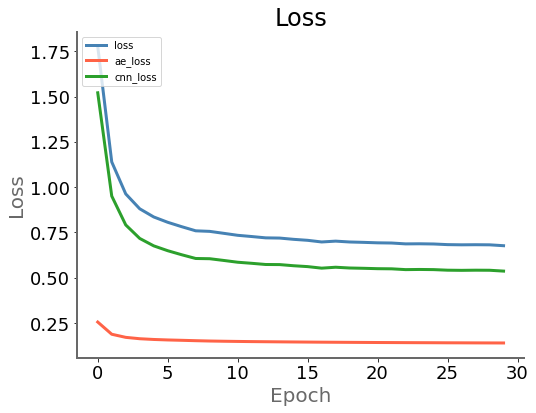

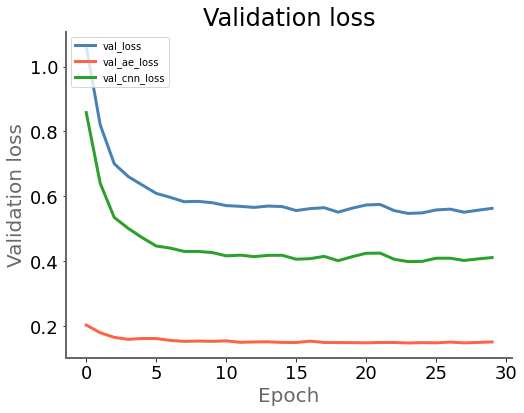

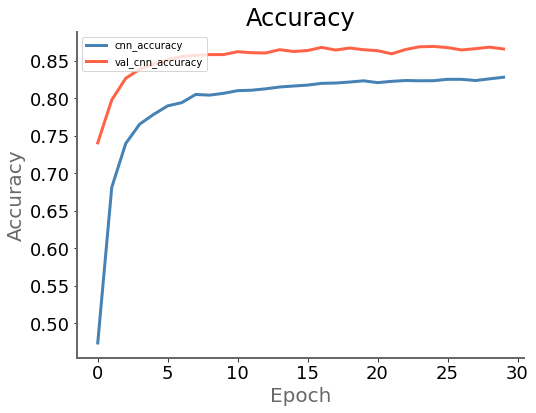

In [12]:
pwk.plot_history(history,  plot={'Loss':['loss', 'ae_loss', 'cnn_loss'],
                                 'Validation loss':['val_loss','val_ae_loss', 'val_cnn_loss'], 
                                 'Accuracy':['cnn_accuracy','val_cnn_accuracy']}, save_as='01-history')

## Step 6 - Denoising progress

<br>**Real images (clean_test) :**

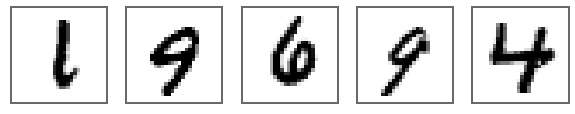

<br>**Noisy images (noisy_test) :**

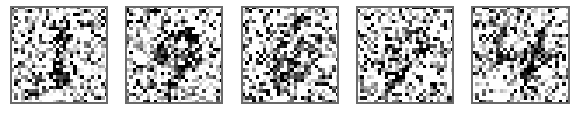

<br>**Evolution during the training period (denoised_test) :**

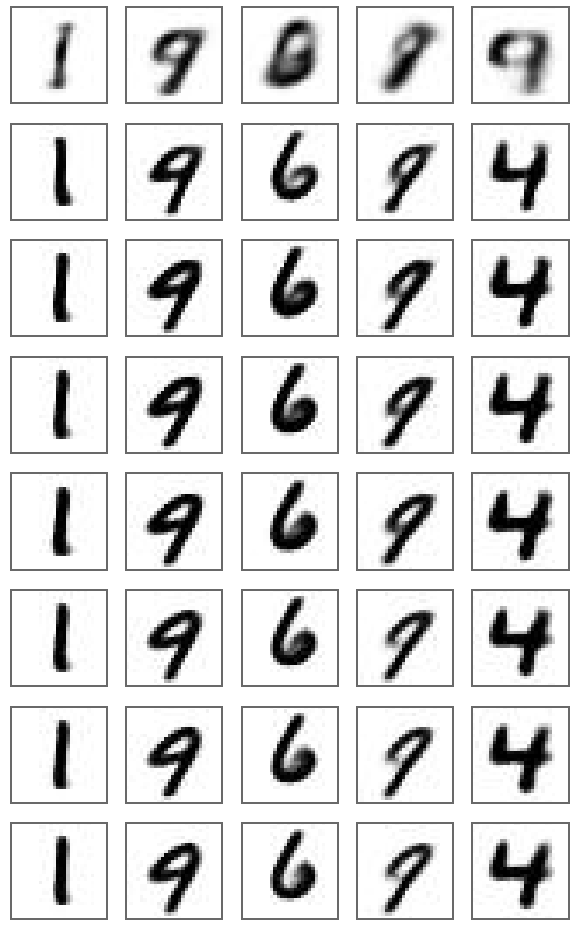

<br>**Noisy images (noisy_test) :**

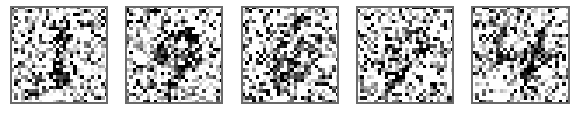

<br>**Real images (clean_test) :**

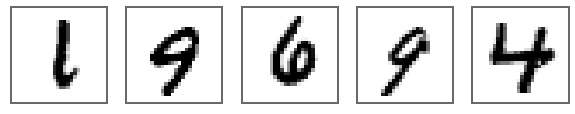

In [13]:
imgs=[]
for epoch in range(0,epochs,4):
    for i in range(5):
        filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)      

pwk.subtitle('Real images (clean_test) :')
pwk.plot_images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='02-original-real')

pwk.subtitle('Noisy images (noisy_test) :')
pwk.plot_images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='03-original-noisy')

pwk.subtitle('Evolution during the training period (denoised_test) :')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, y_padding=0.1, save_as='04-learning')

pwk.subtitle('Noisy images (noisy_test) :')
pwk.plot_images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images (clean_test) :')
pwk.plot_images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


## Step 7 - Evaluation
**Note :** We will use the following data:\
`clean_train`, `clean_test` for noiseless images \
`noisy_train`, `noisy_test` for noisy images\
`class_train`, `class_test` for the classes to which the images belong \
`denoised_test` for denoised images at the output of the model\
`classcat_test` for class prediction in model output (is a softmax)\
`classid_test` class prediction (ie: argmax of classcat_test)
 
### 7.1 - Reload our best model

In [14]:
model = keras.models.load_model(f'{run_dir}/models/best_model.h5')

### 7.2 - Let's make a prediction
Note that our model will returns 2 outputs : **denoised images** from output 1 and **class prediction** from output 2

In [15]:
denoised_test, classcat_test = model.predict(noisy_test)

print('Denoised images   (denoised_test) shape : ',denoised_test.shape)
print('Predicted classes (classcat_test) shape : ',classcat_test.shape)

Denoised images   (denoised_test) shape :  (14000, 28, 28, 1)
Predicted classes (classcat_test) shape :  (14000, 10)


### 7.3 - Denoised images 

<br>**Noisy test images (input):**

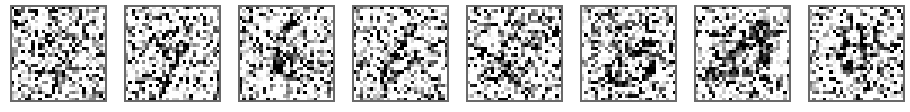

<br>**Denoised images (output):**

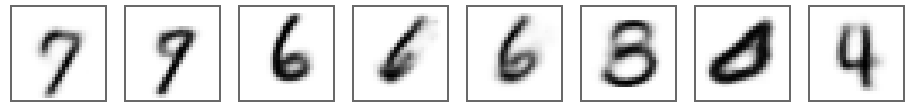

<br>**Real test images :**

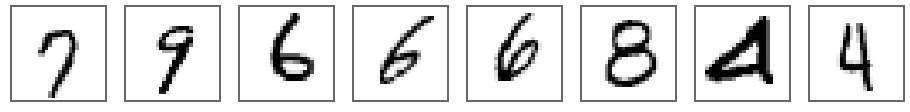

In [16]:
i=random.randint(0,len(denoised_test)-8)
j=i+8

pwk.subtitle('Noisy test images (input):')
pwk.plot_images(noisy_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='05-test-noisy')

pwk.subtitle('Denoised images (output):')
pwk.plot_images(denoised_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='06-test-predict')

pwk.subtitle('Real test images :')
pwk.plot_images(clean_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='07-test-real')

### 7.4 - Class prediction
Note: The evaluation requires the noisy images as input (noisy_test) and the 2 expected outputs:
 - the images without noise (clean_test)
 - the classes (class_test)

<br>**Accuracy :**

Classification accuracy : 0.8688


<br>**Few examples :**

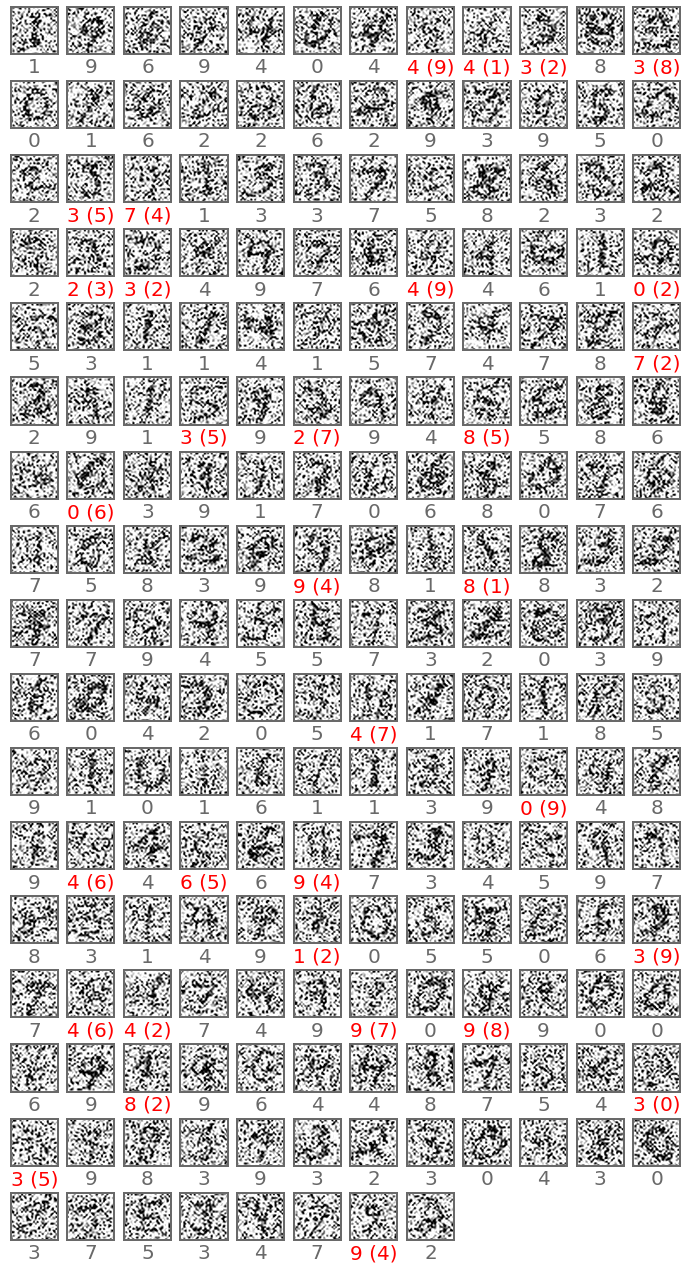

In [17]:
score = model.evaluate(noisy_test, [clean_test, class_test], verbose=0)

pwk.subtitle("Accuracy :")
print(f'Classification accuracy : {score[3]:4.4f}')

pwk.subtitle("Few examples :")
classid_test  = np.argmax(classcat_test, axis=-1)
pwk.plot_images(noisy_test, class_test, range(0,200), columns=12, x_size=1, y_size=1, y_pred=classid_test, save_as='04-predictions')

In [18]:
pwk.end()

End time is : Sunday 14 March 2021, 22:38:02
Duration is : 00:02:23 656ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>